# Сборный проект 1. Исследование данных о компьютерных играх для интернет-магазина «Стримчик».

Проект заказан интернет-магазином «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные до 2016 года о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).       
В представлении, что сейчас декабрь 2016 г., нужно выявить закономерности, определяющие успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017-й. 

### Оглавление:

#### Шаг 1. Загрузка данных и изучение общей информации

#### Шаг 2. Предобработка данных 

#### Шаг 3. Исследовательский анализ данных

#### Шаг 4. Составление портрета пользователя каждого региона

#### Шаг 5. Проверка гипотез

#### Шаг 6. Общий вывод
    

## Шаг 1. Загрузка данных и изучение общей информации

Импортируем библиотеки, которые будут нужны 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from scipy import stats as st
import pandas as pd
import numpy as np

Прочтем исходный файл с данными      
(try...except для того, чтобы можно было читать файл не только локально, но и из общего хранилища). 

In [2]:
try:
    games_raw = pd.read_csv('games.csv')
    
except:
    games_raw = pd.read_csv('/datasets/games.csv')
    

Посмотрим общую информацию о датафрейме, сколько строк в столбцах, много ли пропусков и в каких столбцах, какие у данных типы и насколько это совпадатет с сутью самих данных ...

In [3]:
games_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


... и взглянем как выглядят "голова" и "хвост" датафрейма

In [4]:
games_raw

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Видим:
1. В датафрейме 11 столбцов, что совпадает с описанием проекта.       
Соответственно можем утверждать, что в соответствии с описанием датафрейм содержит следующие столбцы - характеристики конкретных игр:                 
    •	Name — название игры       
    •	Platform — платформа       
    •	Year_of_Release — год выпуска       
    •	Genre — жанр игры       
    •	NA_sales — продажи в Северной Америке (миллионы проданных копий)       
    •	EU_sales — продажи в Европе (миллионы проданных копий)        
    •	JP_sales — продажи в Японии (миллионы проданных копий)       
    •	Other_sales — продажи в других странах (миллионы проданных копий)       
    •	Critic_Score — оценка критиков (максимум 100)       
    •	User_Score — оценка пользователей (максимум 10)       
    •	Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.             
На данном этапе основной неоднозначностью со столбцами видится следующая: по всей видимости данные по продажам не разбиты по годам, а идут консолидировано по релизам (для которых есть данные по году). Поэтому если в датафрейме не найдется какой-то иной признак разбивки по годам, то сделать анализ продаж одного и того же релиза игры, который не менялся несколько лет за эти самые годы - может не получиться.

2. Датафрейм содержит 16715 строк - собственно игр.    
    Если действительно каждая строка это отдельная игра - то навскидку это очень много. Нужно проверить сколько уникальных названий и какая логика их неоднократного упоминания (дубликаты, продажи по годам и т.п.).       
    
    При этом данные по продажам (столбцы "..._sales") полны (по 16715 строк) для всех 4 регионов (NA, EU, JP, Other).    
    
    Однако столбцы с названием игры ("Name") и с жанром ("Genre") содержат только 16713 строк.        
    Отсутствие двух строк с названием игры (если только это не два дубликата одной и той же строки) означает, что в датафрейме есть две безымянные игры, идентифицировать которые мы не проводя дополнительного исследования внешних источников мы вряд-ли сможем, но по которым тем не менее есть все данные по продажам. Канонически правильным было бы исключить их из рассмотрения, однако может оказаться, что какая-то из них ( а может и обе они) окажутся например в "хитах продаж" и будут существенно влиять на выводы исследования. Поэтому мы пока оставим их в рассмотрении в виде двух безымянных игр no_name_1 и no_name_2 (после проверки на дубликаты). Если на этапе исследования мы поймем, что объемы по этим играм невелики и на основные выводы не повлияют - можно будет исключить их из рассмотрения.              
   
   Относительно двух пропусков в столюце "Genre" - ситуация похожа на ситуацию с отсутствующими названиями игр. Нам еще предстоит делать раскладку по жанрам и эти якаобы отсутствующие могт повлиять. Поэтому пока поступим так же: проверим на дубликаты, оставим пока под названием "no_genre_1" и "no_genre_2", а дальше будем смотреть.        
   
   Показатели по оценкам наличествуют только чуть больше, чем у половины игр: оценки экспертов (столбец "Critic_Score") - для 8137 игр, оценки пользователей ("User_Score") - для 10014 игр.    
    Будем считать, что отсутствие данных по оченкам означает отсутствие оценки, отсутствие оценки означает минимально возможную оценку. То есть заменим пропуски в этих слолбцах на 0.         
    
    Разобраться с рейтингом ESRB (столбец "Rating"), где заполнено только - 9949 значений, без сторонних источников не получается: нужно знать логику проставления рейтинга организацией, а в описании проекта этого нет. пока отметим, что когда будем заниматься заполнением пропусков в этом столбце - придется привлекать сторонние источники - википедию или сайт организации ESRB.
    
    Показатели по году выпуска игры присутствуют только в 16446 строках. Что делать с отсутствием этих данных и насколько это критично для анализа - пока непонятно. Соотвестсвенно пока оставим как есть.
    
3. Типы данных, продекларированные в Dtype навскидку не везде соответствуют сути данных:       
    
    Столбец "Year_of_Release" содержит данные о годе выпуска, значит оптимальный тип данных здесь - int64(int32);     
    Судя по всему в столбце "User_Score" стоят усредненные по пользователям данные, то есть здесь тип должен быть float64. 

Типы данных в этих столбцах нужно будет преобразовать. Во всех остальных столбцах тип данных соответствует сути данных в столбце и менять этот тип не нужно.

4. Датафрейм занимает ок.1.5  байт памяти компьютера, что немного даже для ноутбука. Поскольку предстоит ряд пока непонятных и возможно неоднозначных преобразований данных в датафрейме, то для того, чтобы можно было в любой момент в дальнейшем вернуться к исходным данным - возможно есть смысл перед предобработкой сделать копию исходного датафрейма и дальше работать с ней.

Посмотрим на основные статистические данные параметров игр (столбцов) в датафрейме

In [5]:
games_raw.describe(include='all')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
count,16713,16715,16446.000000,16713,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000,10014,9949
unique,11559,31,NaN,12,NaN,NaN,NaN,NaN,NaN,96,8
top,Need for Speed: Most Wanted,PS2,NaN,Action,NaN,NaN,NaN,NaN,NaN,tbd,E
freq,12,2161,NaN,3369,NaN,NaN,NaN,NaN,NaN,2424,3990
mean,NaN,NaN,2006.484616,NaN,0.263377,0.145060,0.077617,0.047342,68.967679,NaN,NaN
std,NaN,NaN,5.877050,NaN,0.813604,0.503339,0.308853,0.186731,13.938165,NaN,NaN
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,13.000000,NaN,NaN
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,60.000000,NaN,NaN
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,71.000000,NaN,NaN
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,79.000000,NaN,NaN


Видим:

1. Уникальных названий игр 11559. Предположительно данные по продажам игр, которые "держатся" не один год все-таки представлены по годам и по платформам. Самая распространенная игра "Need for Speed"

2. Платформ 31, жанров 12, что видится нормальным и не вызывает пока вопросов.    

3. Года варьируются от 1980 до 2016. 1980-й год (равно как и все остальные до 2000-го) видится "стариной глубокой", которая вряд-ли как-то серьезно может повлиять на выводы по кнцу 2016 года и на прогнозы на 2017 год: с тех пор изменилось все (за исключением может быть человеческой психологии). По 2016 году в описании сказано, что данные по нему могут быть неполны: нужно будет быть осторожным с выводами на основе данных только этого года.     

4. В столбце "User_Score" самое распространенное значение "tbd". Во-первых это не соответствует заявленной 10-бальной (числовой) шкале и просто так преобразовывать тип в этом столбце не получится. А во-вторых "tbd" обычно значит to be determined (или аналогичная отсылка в будущее типа to be decided, to be discussed или to be done). Это аналог "пока рано" или "поиграем - посмотрим".       

5. Для столбца с рейтингом ESRB пока можно только отметить, что значений его 8, что что самое распространенное значение Е, все остальное - пока непонятно. Повторим, что в момент, когда будем заниматься пропусками в этом столбце нам необходимо будет понять логику ESRB по простановке этого рейтинга и принимать решение о заполнении пропусков исходя из этой логики.

6. По столбцам с параметрами продаж навскидку есть два наблюдения:       
    а) слишком много нулей, то есть шкала в миллионах проданных экземпляров не очень удобна для анализа цифр. Возможно есть смысл смотреть в тысячах проданных экземпляров;       
    б) очень большое стандартное отклонение, то есть очень большой разброс значений. При этом видно, что максимум составляет десятки миллионов, при том, что первый квартиль равен нулю, а медиана составляет десятки тысяч. Выборка очень неравномерна.

Посмотрим на топ игр в датафрейме

In [6]:
display(games_raw['Name'].value_counts().head(20))

Name
Need for Speed: Most Wanted                    12
Ratatouille                                     9
LEGO Marvel Super Heroes                        9
FIFA 14                                         9
Madden NFL 07                                   9
LEGO The Hobbit                                 8
FIFA Soccer 13                                  8
Terraria                                        8
LEGO Harry Potter: Years 5-7                    8
Monopoly                                        8
Lego Batman 3: Beyond Gotham                    8
Cars                                            8
FIFA 15                                         8
Angry Birds Star Wars                           8
The LEGO Movie Videogame                        8
LEGO Star Wars II: The Original Trilogy         8
LEGO Jurassic World                             8
Madden NFL 08                                   8
FIFA 12                                         7
LEGO Indiana Jones: The Original Adventures  

Посмотрим на примере одной топ игры распределены ли данные по продажам по по годам и по платформам.

In [7]:
display(games_raw[games_raw['Name'] == 'Need for Speed: Most Wanted'])

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Видим:      
Все-таки данные не резбиты по годам, а только по релизам и платформам.

Посмотрим на строчки с "пустыми" играми

In [8]:
display(games_raw[games_raw['Name'].isna()])

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [9]:
games_raw['Platform'].value_counts()

Platform
PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: count, dtype: int64

In [10]:
games_raw['Year_of_Release'].value_counts()

Year_of_Release
2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     939
2002.0     829
2003.0     775
2004.0     762
2012.0     653
2015.0     606
2014.0     581
2013.0     544
2016.0     502
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      62
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1990.0      16
1987.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
Name: count, dtype: int64

Видим:      
1. Похоже, что это одна и та же игра, разделенная по рынкам (Япония и все остальные) - судя по одному и тому же году релиза, платформе и жанру (точнее его отсутствию). Даже если это и две разные игры - на дальнейшие рассуждения это не влияет.   
2. Это довольно "старая" игра (1993 года выпуска) и предположительно уже не очень то популярная.     
3. Суммарные продажи составляют 2,42 М экземпляров, что довольно много в свете статистики с медианой в 100 тысяч. Однако есть гипотеза, что пик этих продаж приходится на 90-е годы и давно все упало до нуля.      
Однако с учетом объема продаж и того факта, что 1993 это далеко не самый "древний" год и что под этим же годом в датафрейме фигурирует еще 60 игр - просто так вычеркивать такую игру наверное нет смысла. Поэтому сделаем почти как планировали:    
    - объединим эти формально две игры в одну;
    - назовем ее no_game с жанром no_genre.

На этом закончим рассматривать датафрейм и перейдем к предобработке.

## Шаг 2. Предобработка данных 

Прежде всего как и планировали - сделаем копию исходного датафрейма и дальше будем работать с ней. 

In [11]:
games = games_raw.copy()

games.head(5)  # Проверка: посмотреть что получилось

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Заменить названия столбцов (привести к нижнему регистру).

In [12]:
games.columns = games.columns.str.lower()

games.columns  # Проверка: посмотреть что получилось

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Названия всех столбцов в нижнем регистре.

На самом деле как мы отмечали выше на этапе первичного анализа данных - есть смысл преобразовать в нижнему регистру не только названия столбцов, но и данные в столбцах 'name', 'platform', 'genre' и 'rating'.     
Сделаем это.

In [13]:
games['name'] = games['name'].str.lower()
games['platform'] = games['platform'].str.lower()
games['genre'] = games['genre'].str.lower()
games['rating'] = games['rating'].str.lower()

games.head(5)  # Проверка: посмотреть что получилось

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,e
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,e
3,wii sports resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,e
4,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Все стрококвые данные в столбцах в нижнем регистре.

Теперь преобразуем типы данных там где планировали.

### Преобразовать данные в нужные типы. Описать, в каких столбцах заменен тип данных и почему.

Посмотрим на типы данных в столбцах датафрейма еще раз (при анализе датафрейма мы уже обращали на это внимание). 

In [14]:
games.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

Ранее, при анализе датафрейма мы отмечали, что: 

1. Столбец "year_of_release" содержит данные о годе выпуска, значит оптимальный тип данных здесь - int64(int32).           
Возможно в замене float64 на int64(int32) и не возникнет необходимости. Дело в том, что хотя год релиза и представлен в датафрейме типом float64, однако как мы увидели ранее (когда смотрели value_counts() этого столбца - его значений получается не более 36, что вполне удобно для анализа. Кроме того мы отмечали, что в этом столбце довольно много пропущенных значений и что с ними делать пока непонятно.      
Тем не менее, судя по описанию проекта, нам придется далее смотреть распределение количества игр, выручки от них и т.п. именно по годам. Поэтому есть смысл все-таки перевести этот столбец в тип int не взирая на обилие пропусков.    

2. Судя по всему в столбце "user_score" стоят усредненные по пользователям данные, то есть здесь тип должен быть float64.   
Однако позднее мы выяснили, что в столбце "user_score" есть значение "tbd", которое не является числовым, но:     
во-первых является самым распространенным значением;      
а во-вторых несет смысловую нагрузку (означая по всей видимости "пока нет рейтинга", "поиграем - посмотрим" и т.п).     
То есть его либо не нужно менять, либо сначала заменить на какое-то осмысленное числовое значение, а уже потом менять тип.

3. Во всех остальных столбцах тип данных соответствует сути данных и менять его нет нужды. 

Поэтому пробразование типов данных до завершения процедуры заполнения пропусков в столбце "user_score" производить не будем. Заменим только тип в столбце "year_of_release"  на Int64.

In [15]:
games['year_of_release'] = games['year_of_release'].astype('Int64')

games['year_of_release'].dtype

Int64Dtype()

###  Обработать пропуски при необходимости: 
##### o	Объяснить, почему заполнили пропуски определённым образом или почему не стали это делать;
##### o	Описать причины, которые могли привести к пропускам;
##### o	Обратить внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разобрать это значение и опишите, как его обработать.


Посмотрим на пропуски еще раз. 

In [16]:
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Разберемся с пропусками в столбцах "name" и "genre".       
Мы подробно разбирали эти пропуски ранее и отметили, что пропуски в обоих столбцах - это пропуски одного и того же происхождения и свойства: мы пришли к выводу, что вероятнее всего эти пропуски относятся к одной и той же игре, которая продавалась (возможно отдельно) на разных рынках. При этом удалять ее из рассмотрения нет смысла.     
Поэтому заполним пропуски в этих столбцах на название "no_name" в столбце "name" и "no_genre" в столбце "genre".

In [17]:
games['name'] = games['name'].fillna('no_name')
games['genre'] = games['genre'].fillna('no_genre')

display(games[games['name'] == 'no_name'])  # Проверка: посмотреть что получилось
display(games.isna().sum())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,no_name,gen,1993,no_genre,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,no_name,gen,1993,no_genre,0.00,0.00,0.03,0.00,NaN,NaN,NaN


name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Разберемся с пропусками в столбцах "critic_score" и "user_score".        

Прежде всего предлагается определиться со значением "tbd" в столбце "user_score".  

Ранее мы отмечали, что оценка "tbd" вероятнее всего означает нечно предварительное и отсылку к будущему - "рано для рейтинга" или "поиграем - посмотрим". Очевидно, что такую оценку пользователи ставят когда у них еще нет мнения о достоинствах и недостатках игры чтобы уверенно ее оценить в цифровом выражении. По всей видимости причина здесь - слишком мало времени с момента начала игры и еще ничего толком непонятно. Когда же более-менее четкое мнение у игрока формируется - для многих оценивать уже нет удобной возможности, времени, желания, своевременного запроса и т.д. В результате "в зачет" идет эта самая предварительная оценка. При этом существенная часть пользователей оценивает игру или сразу, или меняя свой предварительный "tbd" на реальную оценку, однако поскольку таких игроков для некоторых игр оказывается меньшинство - их голоса в зачет для данной игры не идут.  

При любом объяснении оценка "tbd" - это по факту отсутствие оценки, то есть нужно заменять на NaN.

Заменим значение "tbd" в столбце "user_score" на NaN

In [18]:
games['user_score'].replace('tbd', np.nan, inplace=True)

games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

Заменили "tbd" на NaN.     
Оценки действительно в диапазоне от 0 до 10.

Теперь самое время преобразовать тип данных в этом столбце на float64 и затем заняться пропусками в обеих столбцах "critic_score" и "user_score". 

In [19]:
games['user_score'] = games['user_score'].astype(float)

games.dtypes  # Проверка: посмотреть что получилось

name                object
platform            object
year_of_release      Int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

Столбцы "critic_score" и "user_score" имеют одинаковый тип данных float64. 

Разберемся с пропусками в этих двух столбцах "critic_score" и "user_score".        
      
Будем исходить из логики взять "ближайшее" релевантное значение:
-   Прежде всего будем смотреть есть ли оценка у других релизов этой игры и если есть - предполагать, что в релизе, для         которого оценка отсутствует она совпадает со средней по другим релизам этой же игры;       
-   Если оценки по другим релизам нет - будем предполагать, что игра имеет минимальную оценку среди всех игр данного жанра,     то есть оценивать ее как min по столбцу "genre". При этом допускаем, что разные жанры могут по разному "нравиться" и       даже минимальная оценка в одном жанре может быть выше, чем напрмер средняя в другом;    
-   Если оценок нет и по всему жанру - тогда будем брать минимальную оценку по конкретной платформе (столбец "platform").       При этом опять же возможно, что одни платформы более популярны и имеют более высокую оценку, чем  другие (в том числе и     минимальную);    
-   Ну а если и здесь ничего не получится - тогда возьмем просто общую минимальную оценку по всем играм всех жанров на всех     платформах.          

Применим описанную логику к пропускам в столбцах  "critic_score" и "user_score". 

Посмотрим на изначальные "масштабы бедствия" - то есть на суммарное количество пропусков в столбцах

In [20]:
games[['critic_score', 'user_score']].isna().sum()

critic_score    8578
user_score      9125
dtype: int64

Создадим небольшой датафрейм с медианами "critic_score" и "user_score" для каждой игры и проверим для всех ли игр эти значения есть

In [21]:
name_scores = games.groupby(['name', 'genre']).agg({'critic_score': 'median', 'user_score': 'median'})
name_scores = name_scores.reset_index()
name_scores.columns = ['name', 'genre', 'critic_sub', 'user_sub']

name_scores  # Проверка: посмотреть что получилось

,name,genre,critic_sub,user_sub
0,beyblade burst,role-playing,NaN,NaN
1,fire emblem fates,role-playing,NaN,NaN
2,frozen: olaf's quest,platform,NaN,NaN
3,haikyu!! cross team match!,adventure,NaN,NaN
4,tales of xillia 2,role-playing,71.0,7.9
...,...,...,...,...
11560,zumba fitness rush,sports,73.0,6.2
11561,zumba fitness: world party,misc,73.0,6.2
11562,zwei!!,role-playing,NaN,NaN
11563,zyuden sentai kyoryuger: game de gaburincho!!,action,NaN,NaN


In [22]:
name_scores.isna().sum()

name             0
genre            0
critic_sub    6479
user_sub      6871
dtype: int64

Медианные значения оценок экспертов есть только для 5086 игр из 11565, в 6479 случаях по прежнему пропуски (из 8578).      
С оценками пользователей картина примерно такая же - пропусков 5445 из 6701, бывших изначально.     
Но тем не менее около 2 тысяч пропусков нам удастся закрыть наиболее приближенным значением.   

Теперь посчитаем минимальные значения по жанрам и по платформам

In [23]:
genre_scores = games.groupby(['genre']).agg({'critic_score': 'min', 'user_score': 'min'})
genre_scores = genre_scores.reset_index()
genre_scores.columns = ['genre', 'critic_min', 'user_min']

genre_scores  # Проверка: посмотреть что получилось

,genre,critic_min,user_min
0,action,19.0,0.3
1,adventure,17.0,0.0
2,fighting,23.0,0.9
3,misc,19.0,0.5
4,no_genre,NaN,NaN
5,platform,19.0,0.2
6,puzzle,25.0,1.1
7,racing,13.0,0.3
8,role-playing,35.0,1.4
9,shooter,22.0,1.2


Заполним нулевыми оценками наш искусственный жанр "no_genre".

In [24]:
genre_scores.loc[genre_scores['genre'] == 'no_genre', ['critic_min', 'user_min']] = 0

genre_scores  # Проверка: посмотреть что получилось

,genre,critic_min,user_min
0,action,19.0,0.3
1,adventure,17.0,0.0
2,fighting,23.0,0.9
3,misc,19.0,0.5
4,no_genre,0.0,0.0
5,platform,19.0,0.2
6,puzzle,25.0,1.1
7,racing,13.0,0.3
8,role-playing,35.0,1.4
9,shooter,22.0,1.2


In [25]:
genre_scores.isna().sum()

genre         0
critic_min    0
user_min      0
dtype: int64

Видим, что для каждого жанра есть своя минимальная оценка, пропусков нет.      
Значит мы сможем заполнить пропуски в столбцах "critic_score" и "user_score" на основе медианных значений для релизов конкретных игр и минимальных значений оценок для отдельных жанров.      
Соответственно считать минимальные значения по платформам и общий минимум нам не нужно.

 Заполним полученными минимальными значениями по жанрам недостающие значения в датасете name_scores.    
 Для этого объединим датасеты, заполним пропуски в нужных нам столбцах из значений других столбцов и затем удалим ненужные столбцы.

In [26]:
# Объединяем датасеты
scores = pd.merge(name_scores, genre_scores, on='genre', how='left')

scores  # Проверка: посмотреть что получилось

,name,genre,critic_sub,user_sub,critic_min,user_min
0,beyblade burst,role-playing,NaN,NaN,35.0,1.4
1,fire emblem fates,role-playing,NaN,NaN,35.0,1.4
2,frozen: olaf's quest,platform,NaN,NaN,19.0,0.2
3,haikyu!! cross team match!,adventure,NaN,NaN,17.0,0.0
4,tales of xillia 2,role-playing,71.0,7.9,35.0,1.4
...,...,...,...,...,...,...
11560,zumba fitness rush,sports,73.0,6.2,19.0,0.2
11561,zumba fitness: world party,misc,73.0,6.2,19.0,0.5
11562,zwei!!,role-playing,NaN,NaN,35.0,1.4
11563,zyuden sentai kyoryuger: game de gaburincho!!,action,NaN,NaN,19.0,0.3


In [27]:
# Заполняем пропуски в столбцах 'critic_sub' и 'user_sub'
scores['critic_sub'] = scores['critic_sub'].fillna(scores['critic_min'])
scores['user_sub'] = scores['user_sub'].fillna(scores['user_min'])

scores  # Проверка: посмотреть что получилось

,name,genre,critic_sub,user_sub,critic_min,user_min
0,beyblade burst,role-playing,35.0,1.4,35.0,1.4
1,fire emblem fates,role-playing,35.0,1.4,35.0,1.4
2,frozen: olaf's quest,platform,19.0,0.2,19.0,0.2
3,haikyu!! cross team match!,adventure,17.0,0.0,17.0,0.0
4,tales of xillia 2,role-playing,71.0,7.9,35.0,1.4
...,...,...,...,...,...,...
11560,zumba fitness rush,sports,73.0,6.2,19.0,0.2
11561,zumba fitness: world party,misc,73.0,6.2,19.0,0.5
11562,zwei!!,role-playing,35.0,1.4,35.0,1.4
11563,zyuden sentai kyoryuger: game de gaburincho!!,action,19.0,0.3,19.0,0.3


In [28]:
# Удаляем ненужные столбцы
scores.drop(['genre', 'critic_min', 'user_min'], axis= 1 , inplace= True )

scores  # Проверка: посмотреть что получилось

,name,critic_sub,user_sub
0,beyblade burst,35.0,1.4
1,fire emblem fates,35.0,1.4
2,frozen: olaf's quest,19.0,0.2
3,haikyu!! cross team match!,17.0,0.0
4,tales of xillia 2,71.0,7.9
...,...,...,...
11560,zumba fitness rush,73.0,6.2
11561,zumba fitness: world party,73.0,6.2
11562,zwei!!,35.0,1.4
11563,zyuden sentai kyoryuger: game de gaburincho!!,19.0,0.3


 Итак, все данные готовы для замены пропусков в столбцах "critic_score" и "user_score" нашего основного датафрейма games.
 
 Сделаем это аналогично тому, как мы только что проделали с датафреймом scores: сольем два датафрейма, заполним пропуски и удалим лишнее.

In [29]:
# Объединяем датасеты
games = pd.merge(games, scores, on='name', how='left')

# Заполняем пропуски в столбцах 'critic_score' и 'user_score' значениями из столбцов 'critic_sub' и 'user_sub'
games['critic_score'] = games['critic_score'].fillna(games['critic_sub'])
games['user_score'] = games['user_score'].fillna(games['user_sub'])

# Удаляем ненужные столбцы
games.drop(['critic_sub', 'user_sub'], axis= 1 , inplace= True )


games  # Проверка: смотрим что получилось

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,19.0,0.2,NaN
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,35.0,1.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16724,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,19.0,0.3,NaN
16725,lma manager 2007,x360,2006,sports,0.00,0.01,0.00,0.00,19.0,0.2,NaN
16726,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,17.0,0.0,NaN
16727,spirits & spells,gba,2003,platform,0.01,0.00,0.00,0.00,19.0,0.2,NaN


In [30]:
games.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score            0
rating             6775
dtype: int64

 Осталось обработать пропуски в столбцах "year_of_release" и "rating".

 Займемся заполнением пропусков в столбце "rating".
 
Столбец "rating" содержит данные о рейтинге ESRB (Entertainment Software Rating Board) - возрастных ограничениях, налагаемых организацией на конкретную игру.     
Как мы отмечали ранее, когда смотрели общие параметры датафрейма - уникальных значений этого рейтинга в столбце 8, это соответствует тому, что удалось узнать из википедии относительно рейтингов ESRB. Эти 8 значений рейтинга следующие:      
«ec» («Early childhood») — «Для детей младшего возраста»,          
«e» («Everyone») — «Для всех»,        
«e10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»,        
«t» («Teen») — «Подросткам»,        
«m» («Mature») — «Для взрослых»,        
«ao» («Adults Only 18+») — «Только для взрослых»,        
«rp» («Rating Pending») — «Рейтинг ожидается»,        
«rp17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+».       

Для начала проверим так ли это в датафрейме.

In [31]:
games['rating'].value_counts()

rating
e       3990
t       2963
m       1565
e10+    1421
ec         8
k-a        3
rp         3
ao         1
Name: count, dtype: int64

В принципе информация, полученная нами "на стороне" нас не обманула: в датафрейме есть все рейтинги, присваиваемые ESRB, за исключением «rp17+». Вместо отсутствующего "rp17+" есть один "лишний" - "k-a".  Из сторонних источников удалось выяснить, что рейтинг "k-a" ("Kids to Adults") - это устаревшее название рейтинга "e" ("Everyone").     

Чтобы не возвращаться к этому вопросу - сразу заменим "k-a" на  "e".

In [32]:
games.loc[games['rating'] == 'k-a', 'rating'] = 'e'

games['rating'].value_counts()  # Проверка: смотрим что получилось

rating
e       3993
t       2963
m       1565
e10+    1421
ec         8
rp         3
ao         1
Name: count, dtype: int64

Замену "k-a" на  "e" произвели.

Теперь посмотрим чем можно заполнить пропуски в этом столбце.

In [33]:
games['rating'].isna().sum()

6775

Среди тех рейтингов, которые присваивает ESRB для заполнения пропусков нам напрямую не подходит ни один:      
- среди рейтингов нет явного значения типа "все остальные";       
- рейтинги "ожидания" - «rp» «rp17+» напрямую относятся к играм, которые были отправлены в ESRB на оценку и ожидают присвоения рейтинга. Компания напрямую ограничивает эти рейтинги рекламными и в демо версиями игр до официальной даты выпуска в продажу;
- заполнение пропусков одним из "рабочих" рейтингов (типа "е") существенно исказит картину для анализа и повлияет на выводы.     

Поэтому кажется наиболее резонным поступить следующим образом:   
Если у предыдущих или поледующих релизов игры есть какой-то рейтинг - то считать, что у релиза с пропуском этот рейтинг такой-же. То есть заполнить пропуск значением рейтинга например из самого последнего релиза (значением "last" при агрегации);       
Если же у игры нет рейтинга во всех релизах (то есть вообще) - то заполнить пробелы специальным значением "no_rating", означающем отсутствие рейтинга у игры.

Попробуем заполнить пропуски в столбце "rating" исходя из этой логики.

 Сделаем это аналогично тому, как мы только что проделали с пропусками в столбцах "critic_score" и "user_score".      
 Сначала сделаем аггрегацию и создадим вспомогательный датафрейм.

In [34]:
# Аггрегируем данные и создаем вспомоготельный датафрейм
ratings = games.groupby(['name']).agg({'rating': 'last'})
ratings = ratings.reset_index()
ratings.columns = ['name', 'rating_sub']

ratings  # Проверка: смотрим что получилось

,name,rating_sub
0,beyblade burst,None
1,fire emblem fates,None
2,frozen: olaf's quest,None
3,haikyu!! cross team match!,None
4,tales of xillia 2,t
...,...,...
11555,zumba fitness rush,e10+
11556,zumba fitness: world party,e
11557,zwei!!,None
11558,zyuden sentai kyoryuger: game de gaburincho!!,None


In [35]:
# Заполняем пропуски в столбце 'rating_sub'
ratings['rating_sub'] = ratings['rating_sub'].fillna('no_rating')

ratings  # Проверка: смотрим что получилось

,name,rating_sub
0,beyblade burst,no_rating
1,fire emblem fates,no_rating
2,frozen: olaf's quest,no_rating
3,haikyu!! cross team match!,no_rating
4,tales of xillia 2,t
...,...,...
11555,zumba fitness rush,e10+
11556,zumba fitness: world party,e
11557,zwei!!,no_rating
11558,zyuden sentai kyoryuger: game de gaburincho!!,no_rating


In [36]:
# Объединяем датасеты
games = pd.merge(games, ratings, on='name', how='left')

# Заполняем пропуски в столбцах 'critic_score' и 'user_score' значениями из столбцов 'critic_sub' и 'user_sub'
games['rating'] = games['rating'].fillna(games['rating_sub'])

# Удаляем ненужные столбцы
games.drop(['rating_sub'], axis= 1 , inplace= True )


games.head(5)  # Проверка: смотрим что получилось

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,19.0,0.2,no_rating
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,35.0,1.4,no_rating


In [37]:
games.isna().sum()

name                 0
platform             0
year_of_release    269
genre                0
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score         0
user_score           0
rating               0
dtype: int64

Пропуски обработаны везде, за исключением столбца "year_of_release".     

Никаких разумных мыслей о том, каким образом более-менее обоснованно заполнить пропуски с годом выпуска релиза без серьезного поиска по внешним источникам - нет.        

Поэтому предлагается оставить пропуски в столбце "year_of_release" как есть - без заполнения.
 
Таким образом считаем, что пропуски обработаны.

##### Посмотрим теперь на наличие дубликатов и если они есть - удалим их, чтобы потом не возвращаться к этому вопросу. 

Посмотрим есть ли дубликаты. 

In [43]:
games.duplicated().sum()

0

Видим, что есть 5 строк, полностью дублирующих друг друга. 

Удалим дубликаты. 

In [44]:
games = games.drop_duplicates()

games.duplicated().sum()

0

Таким образом - дубликаты обработаны, дубликатов больше нет. 

###  Посчитать суммарные продажи во всех регионах и записать их в отдельный столбец.


Чтобы посчитать продажи во всех регионах достаточно просто просуммировать данные в столбцах "na_sales", "eu_sales", "jp_sales" и "other_sales".   
Создадим в датафрейме games столбец "total_sales" и запишем туда результат суммирования. 

In [45]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

games.head(5)  # Проверка: посмотреть что получилось

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e,82.54
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,19.0,0.2,no_rating,40.24
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e,35.52
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e,32.77
4,pokemon_red_pokemon_blue,gb,1996,role_playing,11.27,8.89,10.22,1.00,35.0,1.4,no_rating,31.38


Столбец "total_sales" с данными о суммарных по всем регионам продажах создан и данные в нем похожи на правду (суммарные продажи по миру у топ игр на уровне десятков миллионов экземпляров в год).

Обработаем потенциальные "неявные" дубликаты ( то есть возможные написания одного и того же, но разными способами).     
Такие "неявные" дубликаты могут быть в столбцах "name", "platform" и "genre". Теоретически они так-же возможны в столбцах "year_of_release" и "rating", однако эти столбцы мы ранее просматривали поэлементно (в них всего 37 и 8 уникальных значений соответственно) и дубликатов там нет.

Поэтому для столбцах "name" , "platform" и "genre" удалим возможные пробелы в начале и конце текста, затем заменим пробелы внутри текста, а так-же символы  точка, запятая, тире и / на нижнее подчеркивание "_". Кроме того удалим двоеточия и заменим символ & на текст and.            
И затем методом duplicated() проверим появятся ли у нас еще дубликаты. Если да - удалим.

In [46]:
for col in ['name', 'platform', 'genre']:
    # Удалим в столбцах пробелы в начале и конце текста если они есть
    games[col].str.strip()
    # Заменим в столбцах пробелы и символы "." "," "-" и "/" если они есть на "_"   
    games[col] = games[col].str.replace(' ', '_')
    games[col] = games[col].str.replace('.', '_')
    games[col] = games[col].str.replace(',', '_')
    games[col] = games[col].str.replace('-', '_')
    games[col] = games[col].str.replace('/', '_')
    # Заменим в столбцах "&" если они есть на "and"
    games[col] = games[col].str.replace('&', 'and')
    # Удалим ":" внутри строк
    games[col] = games[col].str.replace(':', '')

# Смотрим что получилось
games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii_sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e,82.54
1,super_mario_bros_,nes,1985,platform,29.08,3.58,6.81,0.77,19.0,0.2,no_rating,40.24
2,mario_kart_wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e,35.52
3,wii_sports_resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e,32.77
4,pokemon_red_pokemon_blue,gb,1996,role_playing,11.27,8.89,10.22,1.00,35.0,1.4,no_rating,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16724,samurai_warriors_sanada_maru,ps3,2016,action,0.00,0.00,0.01,0.00,19.0,0.3,no_rating,0.01
16725,lma_manager_2007,x360,2006,sports,0.00,0.01,0.00,0.00,19.0,0.2,no_rating,0.01
16726,haitaka_no_psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,17.0,0.0,no_rating,0.01
16727,spirits_and_spells,gba,2003,platform,0.01,0.00,0.00,0.00,19.0,0.2,no_rating,0.01


Проверим методом duplicated() появятся ли у нас еще дубликаты. Если да - удалим.

In [47]:
games.duplicated().sum()

0

Дубликатов не появилось.

Поскольку мы не знаем способ формирования анализируемого датафрейма мы должны допустить ситуацию, что данные собирались из разных источников, в результате данные в некоторых колонках не совпадают за счет ошибок, и мы рассматривали эти данные как разные игры, а на самом деле это дубликаты одной и той же игры. Их нужно так-же обработать.

Прежде всего есть смысл понять какой минимальный набор данных, который однозначно определяет игру.      
Представляется, что минимально достаточний набор следующий:         
- название (ну если ошибка в названии, которую мы не "вычислили" предыдущими приседаниями - то даже не знаю что и делать),
- платформа (одна и та же игра по-моему может быть на разных платформах, но если одна и та же игра да на одной и той же платформе - то отличаться наверное могут только релизы по годам),
- год релиза ( допускаем, хотя это только наше допущение, что игра может выходить с одним и тем же названием на одной и той же платформе в нескольких релизах в разные годы).        
Остальные данные в датафрейме по сути их появления могут "плыть" - разные источники формирования данных (а мы должны предположить, что таковые возможно были) могли:        
- относить одну и ту же игру к разным жанрам ( в разных странах и регионах могло быть например "свое мнение" или просто по ошибке),       
- иметь "на руках"  и внсти в датафрейм отличающиеся данные по продажам, и разное количество и значения оценок критиков и пользователей (какие-то данные собирались чуть раньше, какие-то чуть позже, соответственно кто-то учел больше продаж и оценок, а кто-то меньше и т.д.),      
- по разному интерпретировать, не так "прочитать" или по ошибке перепутать рейтинг ESRB ( тем более, что он есть далеко не для всех игр). 

Попробуем проверить (тем же методом duplicated() ) и приналичии обработать дубликаты по в этим тем столбцам - "name", "genre" и "year_of_release".

In [48]:
games.duplicated(['name', 'platform', 'year_of_release']).sum()

12

Такие дубликаты на самом деле есть и их всего 12.        
Думается, что их можно удалить, поскольку их совсем немного и такое удаление врят-ли ухудшит качество анализа и как-то повлияет на выводы.          

Удалим эти дубликаты.

In [49]:
# Удаляем
games.drop_duplicates(['name', 'platform', 'year_of_release'], inplace=True)

# Смотрим что получилось
games.duplicated(['name', 'platform', 'year_of_release']).sum()

0

Итак,
Дубликатов по трем столбцам не осталось.  

Однако поскольку      
с одной стороны у нас нет уверенности в том, что одна и та же игра действительно может выпускаться в нескольких релизах в разные годы совсем без всяких изменений в названии,      
а с другой - в годе выпуска довольно легко допустить ошибку     
представляется, что есть резон проверить много ли осталось игр с абсолютно одинаковыми названиями и на динаковых платформах.      
Если их не много и они не "хиты продаж", то возможно их тоже есть смысл исключить из рассмотрения

Посмотрим.

In [50]:
games.duplicated(['name', 'platform']).sum()

4

Посмотрим что это за игры такие.

In [51]:
games.loc[games.duplicated(['name', 'platform'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1591,need_for_speed_most_wanted,x360,2005,racing,1.00,0.13,0.02,0.10,83.0,8.5,t,1.25
4128,sonic_the_hedgehog,ps3,<NA>,platform,0.00,0.48,0.00,0.00,43.0,4.1,e10+,0.48
11720,need_for_speed_most_wanted,pc,2012,racing,0.00,0.06,0.00,0.02,82.0,8.5,t,0.08
12328,xgra_extreme_g_racing_association,ps2,2003,racing,0.03,0.02,0.00,0.01,68.0,8.6,t,0.06


Хотя среди этих четырех "подозреваемых" есть и релизы "лидера продаж", однако значимый объем продаж фигурирует у не последней и наверняка "неактуальной" версии этой игры, и значит удаление дубликатов и этих четырех игр будет скорее полезно для дальнейшего анализа, нежели ухудншит его качество.  

Поэтому методом drop_duplicates() удалим и эти дубликаты. 

In [52]:
# Удаляем
games.drop_duplicates(['name', 'platform'], inplace=True)

# Смотрим что получилось
games.duplicated(['name', 'platform']).sum()

0

Таким образом: 

Похоже, что мы таки добрались до сиуации "дубликаты все сделаны, дубликатов больше нет".      
При этом не "отрезали" ничего нужного.

In [53]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16709 entries, 0 to 16728
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16709 non-null  object 
 1   platform         16709 non-null  object 
 2   year_of_release  16441 non-null  Int64  
 3   genre            16709 non-null  object 
 4   na_sales         16709 non-null  float64
 5   eu_sales         16709 non-null  float64
 6   jp_sales         16709 non-null  float64
 7   other_sales      16709 non-null  float64
 8   critic_score     16709 non-null  float64
 9   user_score       16709 non-null  float64
 10  rating           16709 non-null  object 
 11  total_sales      16709 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.7+ MB


В рассмотрении осталось 16709 строк, что более чем достаточно для качественного анализа.

## Шаг 3. Исследовательский анализ данных 

### Посмотреть, сколько игр выпускалось в разные годы.  Ответить на вопрос: важны ли данные за все периоды?

Чтобы посмотреть сколько игр выпускалось каждый год нужно будет отсортировать данные по годам и посчитать количество игр (например по столбцу "name") за каждый год (применив функцию "count").

Сделаем это.

In [54]:
# Аггрегируем и сохраняем результат в отдельном фрейме
sales_per_year = games.groupby('year_of_release').agg({'name': ['count'], 'total_sales': ['sum']})

# Сбрасываем индекс, чтобы было два полноценных столбца с датами и количеством
sales_per_year.reset_index(inplace=True)

# Переименовуем столбцы поудобнее
sales_per_year.columns = ['year', 'num_games', 'sum_sales']

# Значения в столбцах по сути целочисленные: приводим типы в соответствие
sales_per_year['year'] = sales_per_year['year'].astype(int)
sales_per_year['num_games'] = sales_per_year['num_games'].astype(int)

# Сортируем по возрастанию года
sales_per_year = sales_per_year.sort_values(by='year')

# Смотрим что получилось
sales_per_year 

,year,num_games,sum_sales
0,1980,9,11.38
1,1981,46,35.68
2,1982,36,28.88
3,1983,17,16.80
4,1984,14,50.35
5,1985,14,53.95
6,1986,21,37.08
7,1987,16,21.70
8,1988,15,47.21
9,1989,17,73.45


In [55]:
sales_per_year.describe()

,year,num_games,sum_sales
count,37.000000,37.000000,37.000000
mean,1998.000000,444.351351,238.252973
std,10.824355,451.504474,207.496930
min,1980.000000,9.000000,11.380000
25%,1989.000000,36.000000,49.370000
50%,1998.000000,338.000000,201.070000
75%,2007.000000,762.000000,361.240000
max,2016.000000,1427.000000,671.500000


In [56]:
display(sales_per_year['num_games'].sum())
display(sales_per_year['sum_sales'].sum())

16441

8815.36

Визуализируем столбчатой диаграммой количество выпущенных игр по годам.

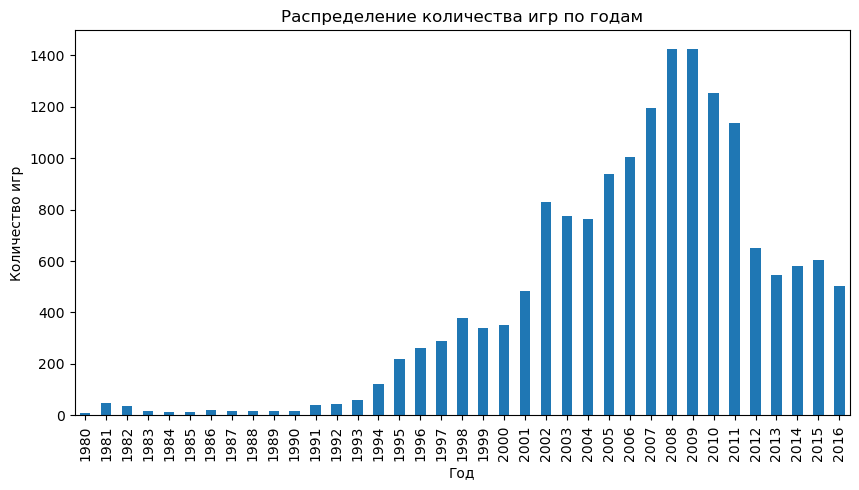

In [57]:
sales_per_year.plot.bar( x='year', y='num_games', legend=False, figsize = (10,5))
plt.title('Распределение количества игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

Аналогичную визуализацию по количеству игр можно было сделать гистограммой прямо из основного датафрейма games

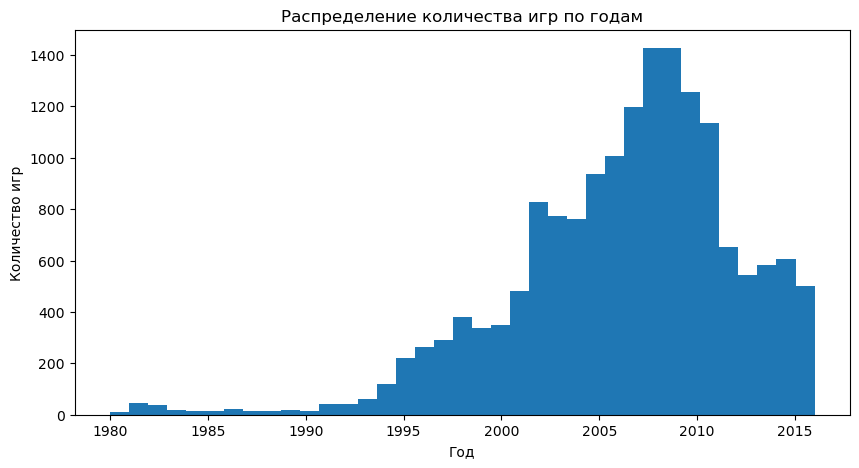

In [58]:
games.hist('year_of_release', bins=37, grid=False, figsize=(10,5))
plt.title('Распределение количества игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

Сделаем такую же визуализацию столбчатой диаграммой для объема продаж по годам.

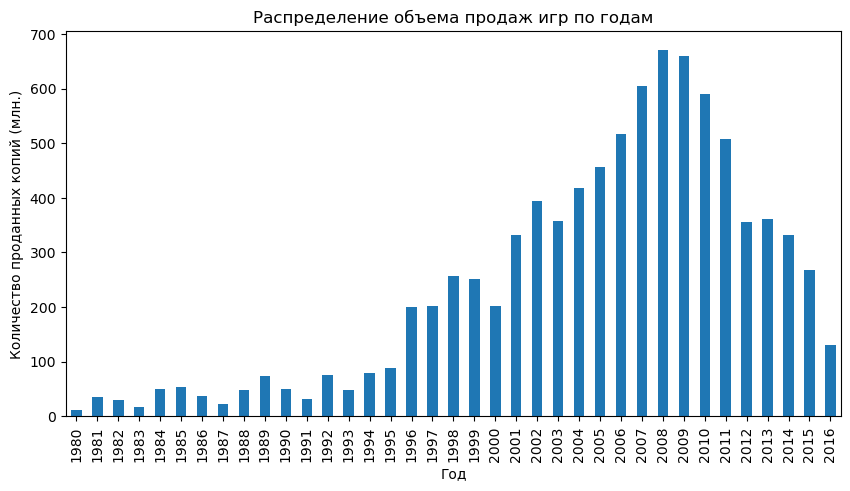

In [59]:
sales_per_year.plot.bar( x='year', y='sum_sales', legend=False, figsize = (10,5))
plt.title('Распределение объема продаж игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество проданных копий (млн.)')
plt.show()

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Отличная визуализация. При желании можно немного улучшить. Смотри: Для того, чтобы построить графить, нужно сгруппировать данные (в нашем случае год релиза и колличество)
    
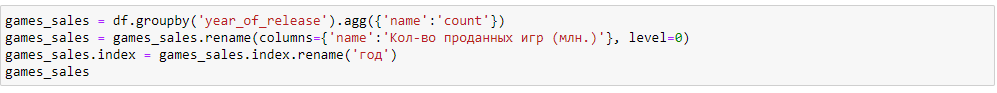
    
---
А потом с помощью библиотеки sns (она мощная, и с ней можно делать всё, что угодно). По данным сгруппированной таблицы строим график. При желании забирай себе =) Главное поиграйся с аргументами и разберись. В дальнейших проектах вы будете строить мощные графики, там пригодится такой навык    
    
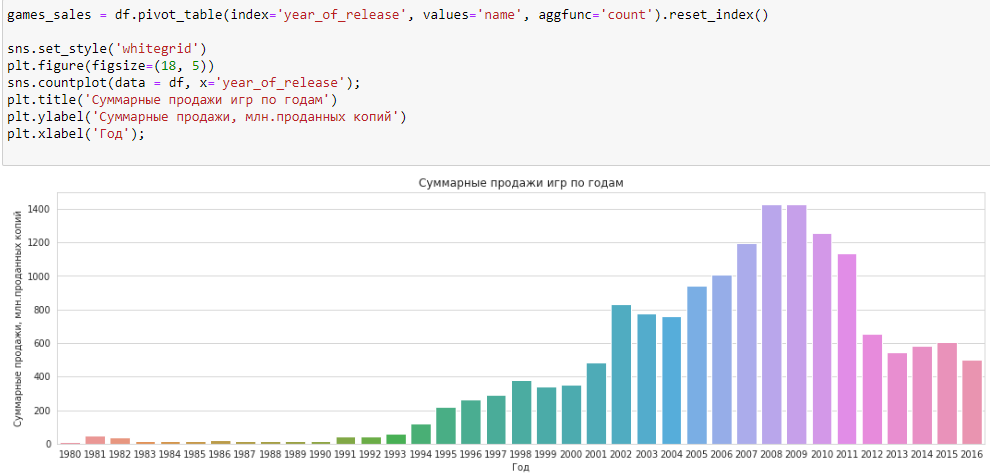  
</div>

Видим следующее:

1. Период выпуска игр, представленный в датафрейме - с 1980 по 2016 год. За эти 37 лет было выпущено 16455 релизов игр. Общий объем продаж составил более 8.8 миллиардов проданных копий.

2. За рассматриваемый период ежегодно в среднем выпускалось 445 игр. Продавалось же 238 миллионов копий.

3. Вид распределения очень напоминает классическое нормальное распределение, немного "скошенное" вправо. То есть нарастание выпуска игр шло несколько медленнее, чем последующий спад.

В качестве рублики "это забавно" отметим, что 1980 год - выглядит очень иртересно: если память не изменяет, то первый персональный компьютер появился только через год - в 81-м. То есть игры начали делать еще не то что до распространения, а и до появления персоналок, то естьначерное для того, чтобы сотрудники компаний играли на "больших машинах" типа mainframe. 

4. После относительного всплеска (пренебрежимо малого на фоне дальнейшего роста) в 1981-82 годах (46 и 37 игр соответственно), который очевидно обусловлен новизной рынка персональных компьютеров и пользовательского программного обеспечения для них; все 80-е и самое начало 90-х годов количествовыпускаемых игр было минимально (около 15 игр ежегодно).     
5. Резкий рост начался с 1993 года, что хорошо соответствует изобретению и взрывному росту популярности интернета (1991 год создания). Максимальные значения количества ежегодно выпускаемых игр равно 1427 и достигнуто было в 2008 и 2009 годах.    
Здесь можно отметить, что на этом этапе роста довольно четко виден всплеск в 2002 году и последующий после этого локальный спад в 2003-04 годах. Это соответствует надуванию и последующему сдутию "пузыря доткомов".

6. После 2009 года видно снижение выпуска игр вплоть до локального минимума в 541 выпущенную игру в 2013 году. Это снижение может быть объяснено как общим начыщением рынка на существующих технологиях, так и заметным влиянием на отрасль  экономического кризиса 2008-09 годов.

7. После локального минимума в 2013 году в 2014 и 2015 мы наблюдаем рост, что возможно объясняется бурным развитием рынка смартфонов и разработки мобильных игр. 

8. В принципе эта тенденция роста обязана была продолжиться и в 2016 году и далее: в этот период никаких кризисов не было, технологии развивались, количество и игроков и "писателей игр" увеличивалось ... то есть причин снижения не видится.   
Однако в 2016 году мы видим снижение количества выпущенных игр. Единственное разумное объяснение этому - это то, что данные за 2016 год могут быть неполны, о чем говорилось в описании проекта.

При этом график объемов продаж фактически повторяет и по форме и по этапам график выпуска игр, с поправкой на то, что последний по времени рост (2012-15 годов) не столь явно выражен. 

Отвечая на вопрос: важны ли данные за все периоды можно утверждать, что с учетом всего отмеченного выше реальной ценностью для прогноза на 2017 обладают данные за 2012-2015 годы и частично - за 2016 (но осторожно - они неполны). Именно в этот период отрасль преодолев кризис по всей видимости вышла на подъем, сформированы все технологические основы создания игр (компьютерные и платформенные с хорошей графикой, мобильные с элементами сетевой игры на 4G и т.д.), но в то же время никаких "революционных" изобретений (как то какие-то принципиально новые платформы, ИИ или дополненная реальность) - пока в нет на массовом рынке. На более ранних периодах были принципиально отличающиеся от этих и технологические и экономические условия, поэтому релевантные выводы на основе данных этих периодов делать гораздо сложнее. 

### Посмотреть, как менялись продажи по платформам. Выбрать платформы с наибольшими суммарными продажами и пострить распределение по годам.  Ответить на вопрос: за какой характерный срок появляются новые и исчезают старые платформы?

Чтобы посмотреть как менялись продажи по платформам наверное есть смысл сгруппировать данные по платформам и просуммировать значения ранее нами созданного столбца "total_sales" по всем играм конкретной платформы за конкретный год.

Для начала вспомним сколько у нас платформ в анализе.

In [60]:
display(games['platform'].value_counts().count())

31

Посмотрим какие платформы самые крупные (топ-5).

In [61]:
top5_games_per_platforms_alltime = games['platform'].value_counts().head(5)

display(top5_games_per_platforms_alltime)

platform
ps2     2160
ds      2151
ps3     1329
wii     1320
x360    1261
Name: count, dtype: int64

Визуализируем.

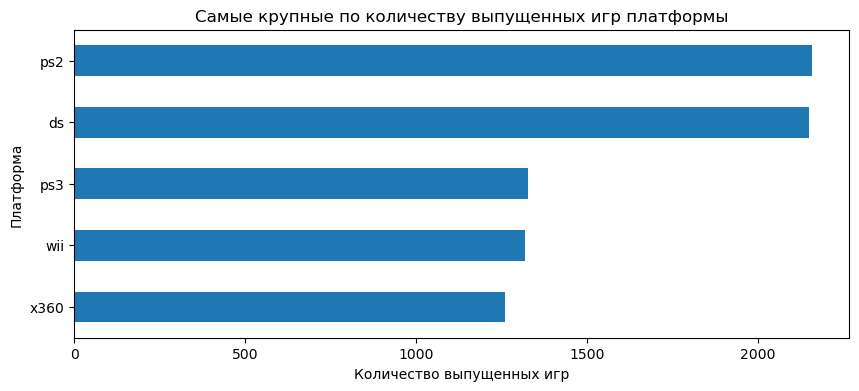

In [62]:
top5_games_per_platforms_alltime.sort_values(ascending=True). \
plot( kind = 'barh', legend=False, figsize = (10,4))

plt.title('Самые крупные по количеству выпущенных игр платформы')
plt.xlabel('Количество выпущенных игр')
plt.ylabel('Платформа')

plt.show()

У каждой из платформ из топ5 больше 1000 игр за все годы. Может быть в топе продаж будут эти же платформы, но не факт.           
Всего в рассмотрении 31 платформа. Будет не очень удобно отображать на одном графике. Нужно будет как-то группировать.

Аггрегируем данные по платформам и посчитаем столбца "total_sales" по всем играм за годы.

In [63]:
# Аггрегируем и сохраняем результат в отдельном фрейме
sales_per_platform_years = games.groupby(['platform', 'year_of_release']).agg({'name': ['count'], 'total_sales': ['sum']})

# Сбрасываем индекс так, чтобы для каждой платформы было два полноценных столбца с годами и суммой продаж
sales_per_platform_years.reset_index(inplace=True)
#sales_per_platform_years.reset_index(level=1, inplace=True)

# Переименовуем столбцы поудобнее
sales_per_platform_years.columns = ['platform', 'year', 'num_games', 'sum_sales']

# Значения в столбцах по сути целочисленные: приводим типы в соответствие
sales_per_platform_years['year'] = sales_per_platform_years['year'].astype(int)
sales_per_platform_years['num_games'] = sales_per_platform_years['num_games'].astype(int)

# Смотрим что получилось
sales_per_platform_years 

,platform,year,num_games,sum_sales
0,2600,1980,9,11.38
1,2600,1981,46,35.68
2,2600,1982,36,28.88
3,2600,1983,11,5.84
4,2600,1984,1,0.27
...,...,...,...,...
233,xb,2008,1,0.18
234,xone,2013,19,18.96
235,xone,2014,61,54.07
236,xone,2015,80,60.14


Просуммируем продажи по годам и выявим самые коммерчески успешные платформы.

In [64]:
sales_per_platforms = sales_per_platform_years.groupby('platform').agg({'sum_sales': ['sum']})
sales_per_platforms.reset_index(inplace= True)
sales_per_platforms.columns = ['platform', 'sales_total']
sales_per_platforms.sort_values(by='sales_total', ascending= False, inplace= True)

top5_sales_per_platforms_alltime = sales_per_platforms.head(5)

display(top5_sales_per_platforms_alltime)  # Смотрим что получилось

,platform,sales_total
16,ps2,1233.50
28,x360,959.99
17,ps3,931.33
25,wii,891.18
4,ds,802.78


Визуализируем.

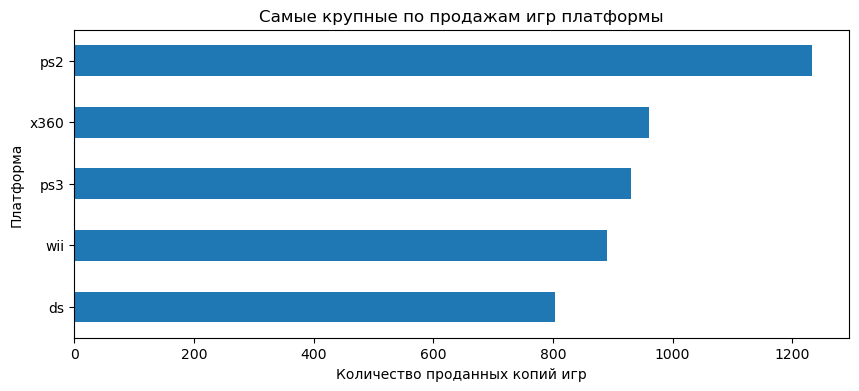

In [65]:
top5_sales_per_platforms_alltime.sort_values(by='sales_total', ascending=True). \
plot( kind = 'barh', x='platform', y= 'sales_total', legend=False, figsize = (10,4))

plt.title('Самые крупные по продажам игр платформы')
plt.xlabel('Количество проданных копий игр')
plt.ylabel('Платформа')

plt.show()

Для того, чтобы разобраться с характерным сроком "жизни" платформы нам нужно посмотреть на распределение продаж игр на каждой платформе по годам и посмотреть как платформы "себя ведут".     
Визуализируем столбчатой диаграммой продажи по годам по всем платформам отдельно для каждой платформы.

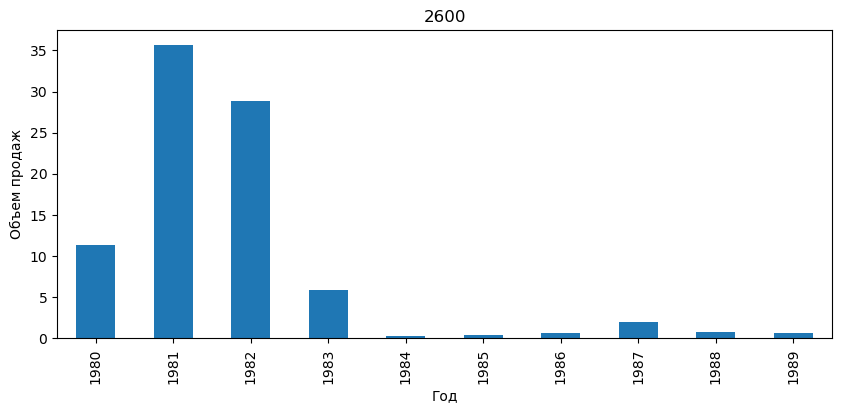

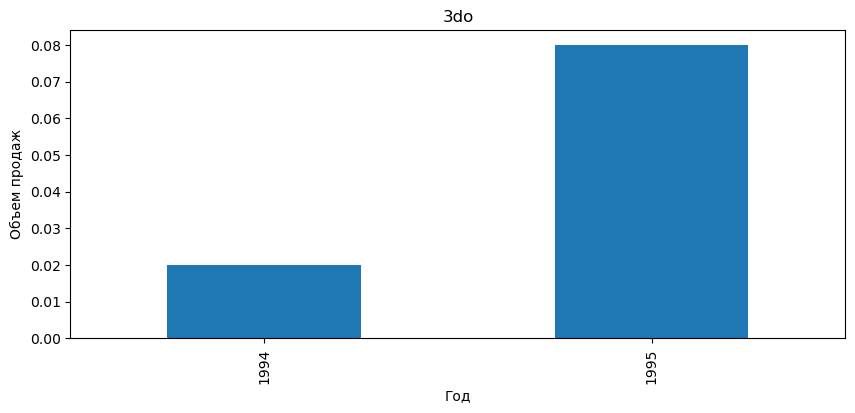

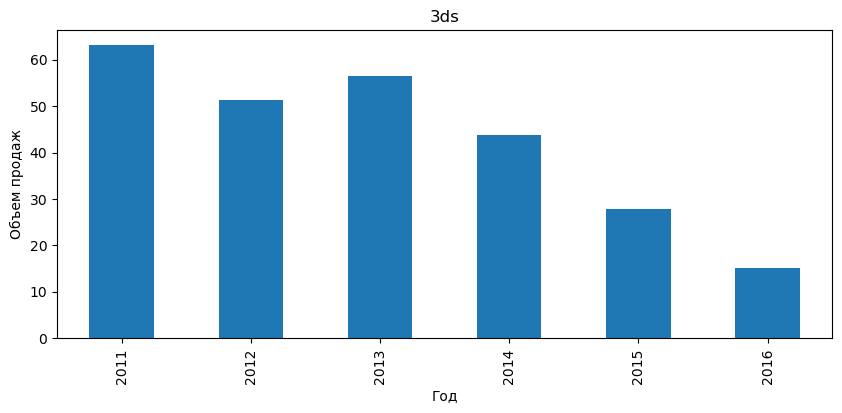

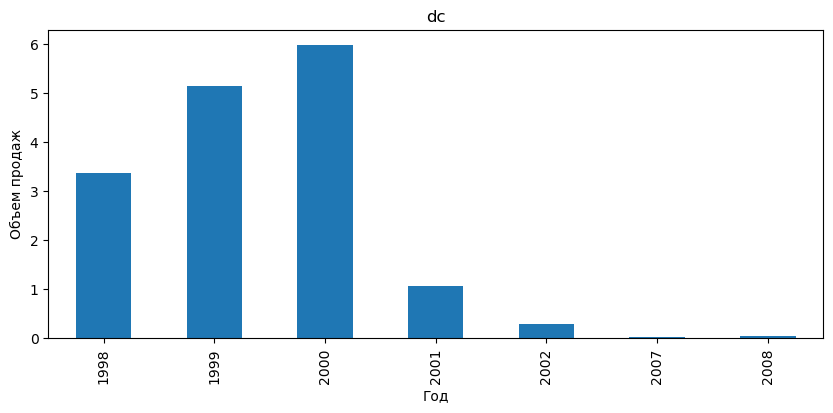

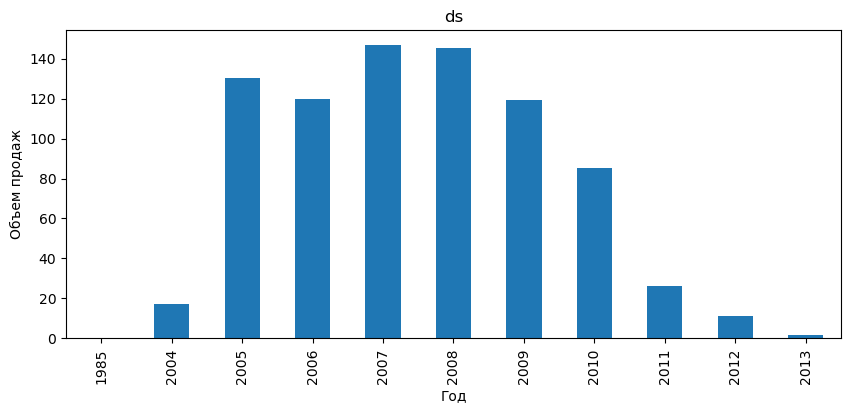

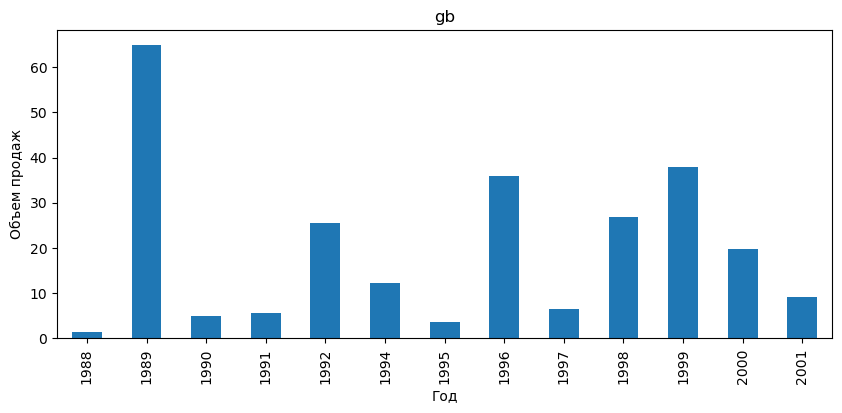

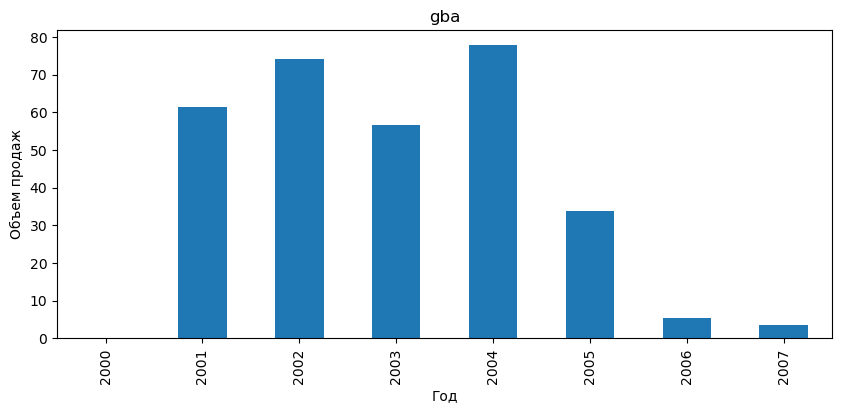

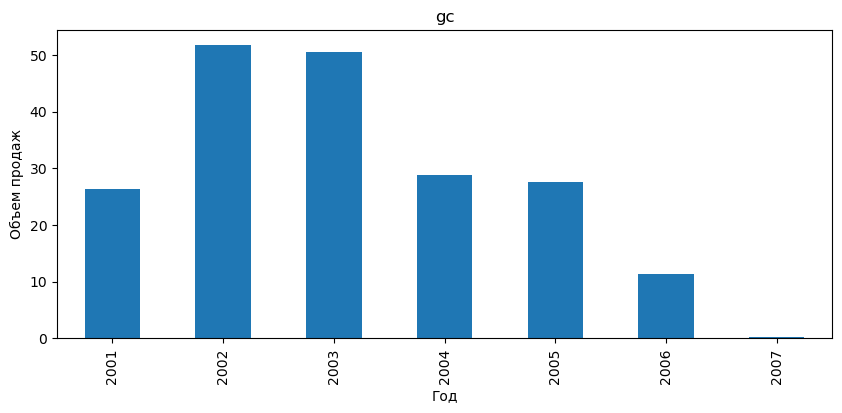

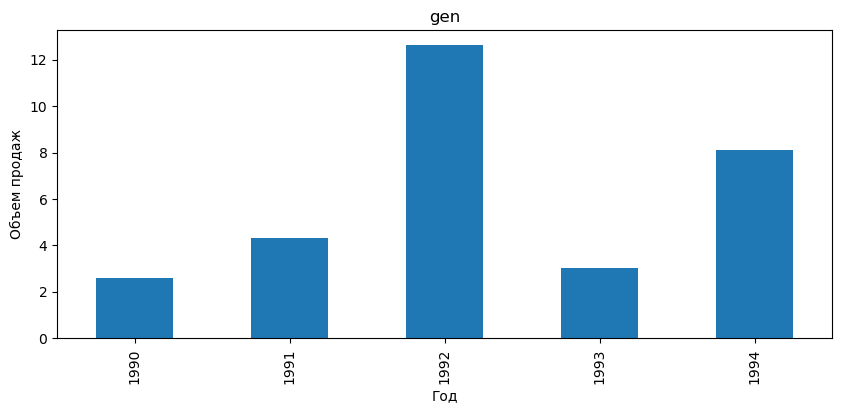

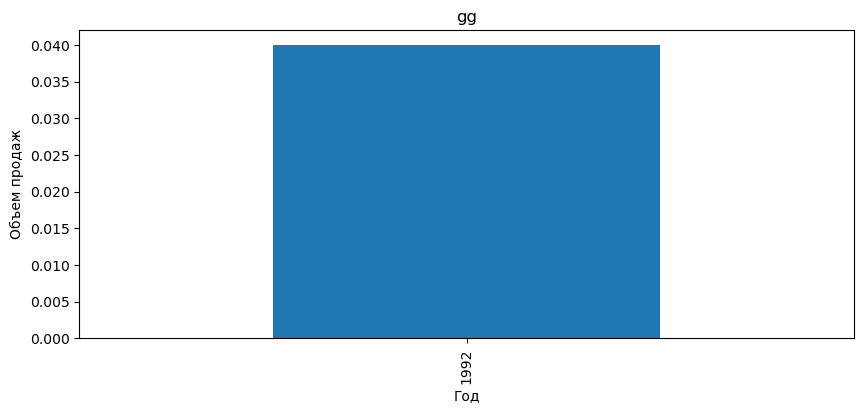

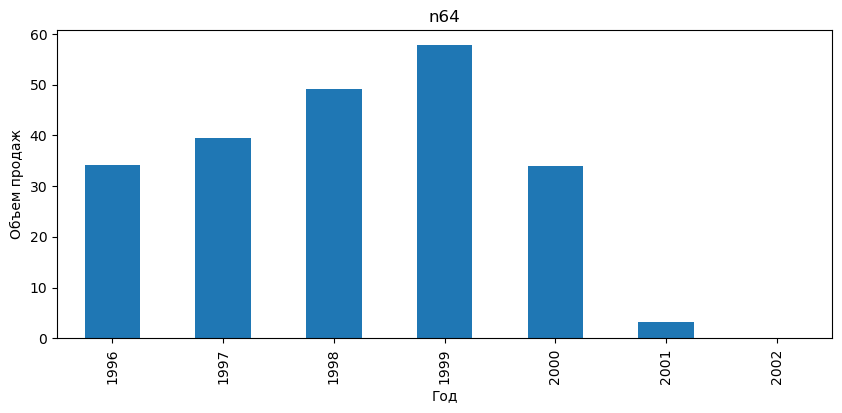

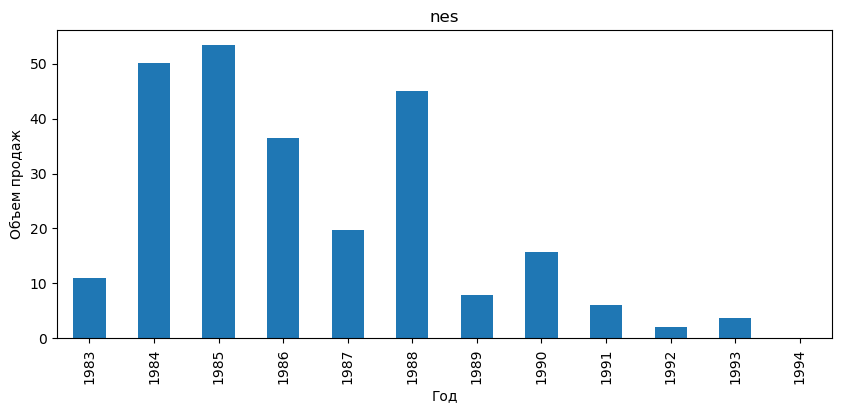

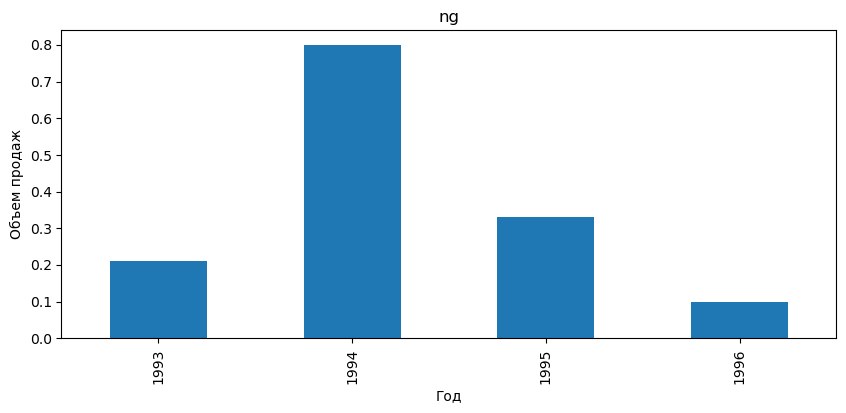

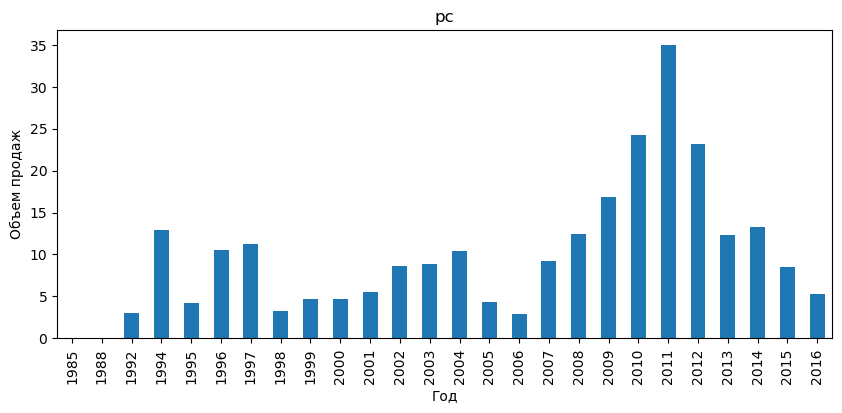

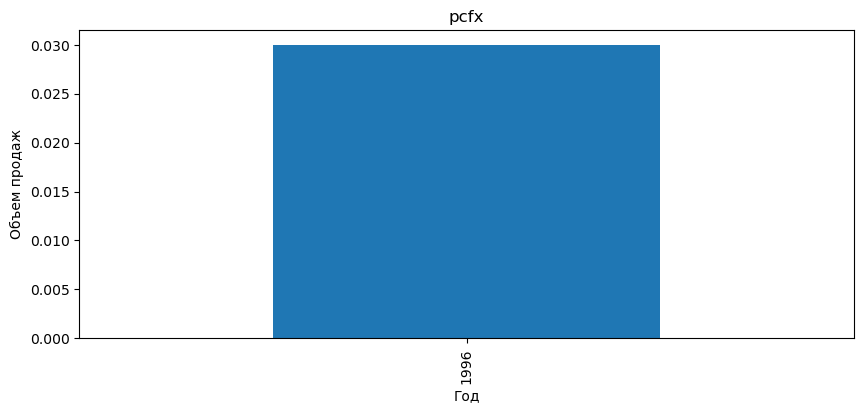

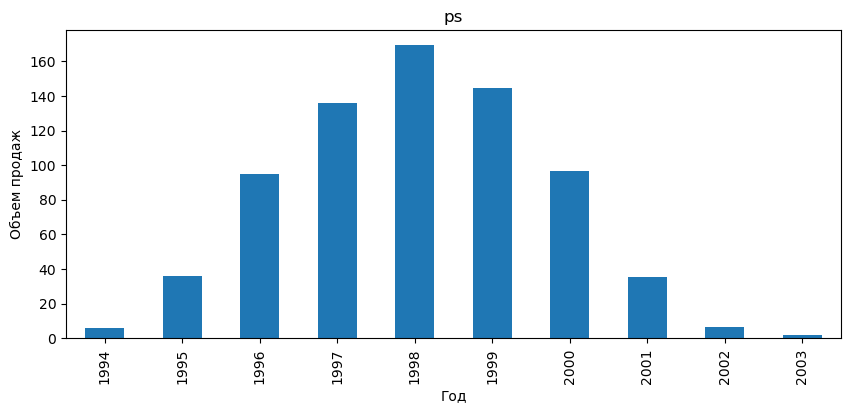

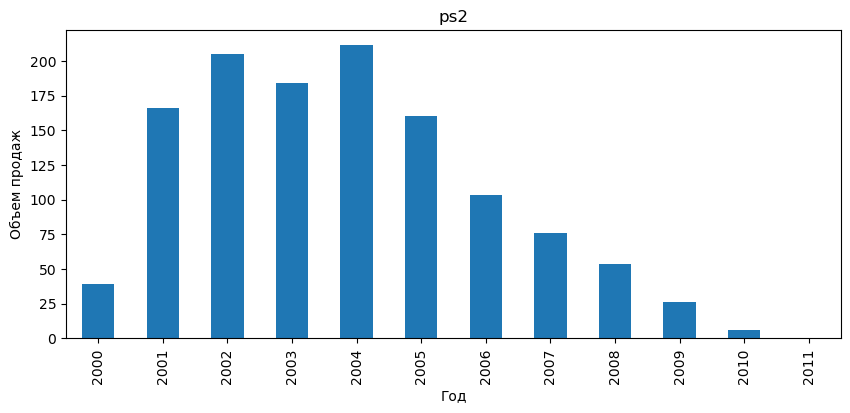

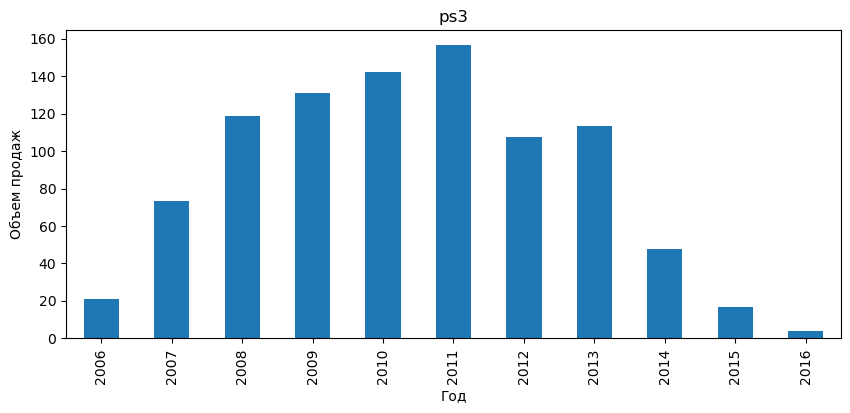

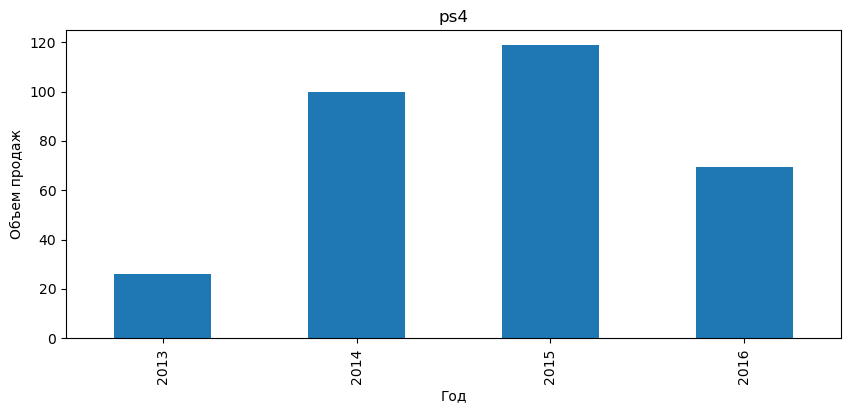

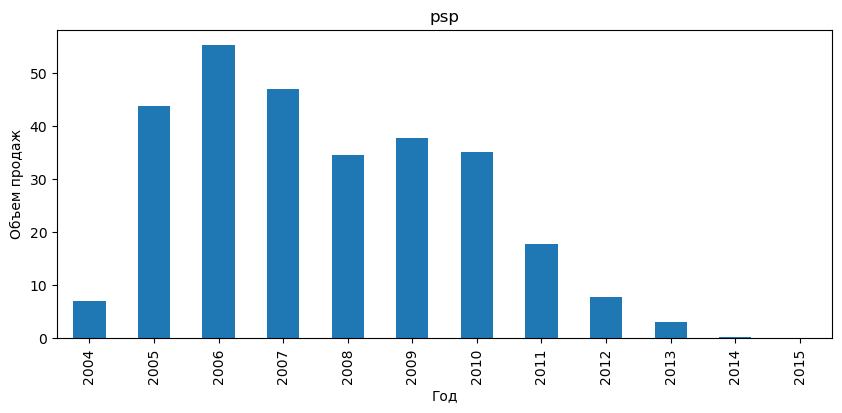

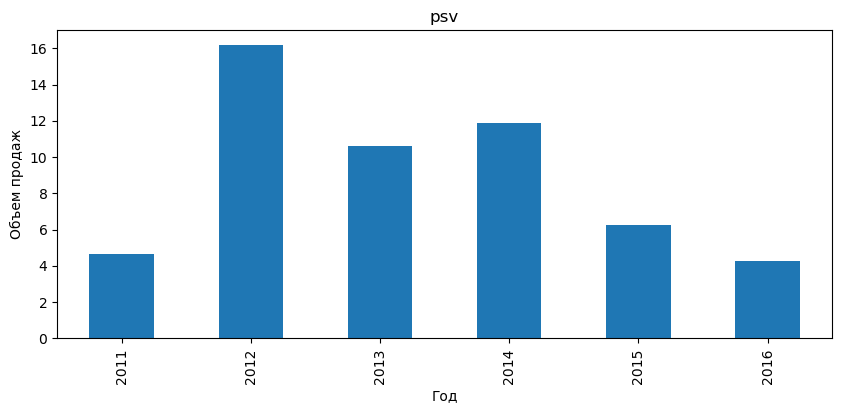

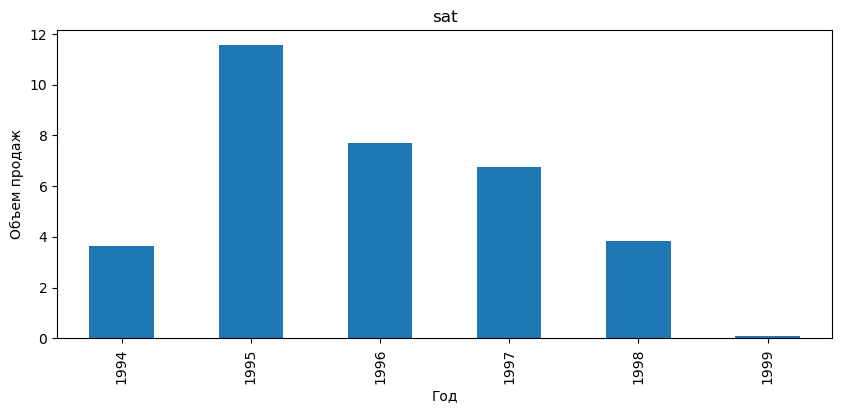

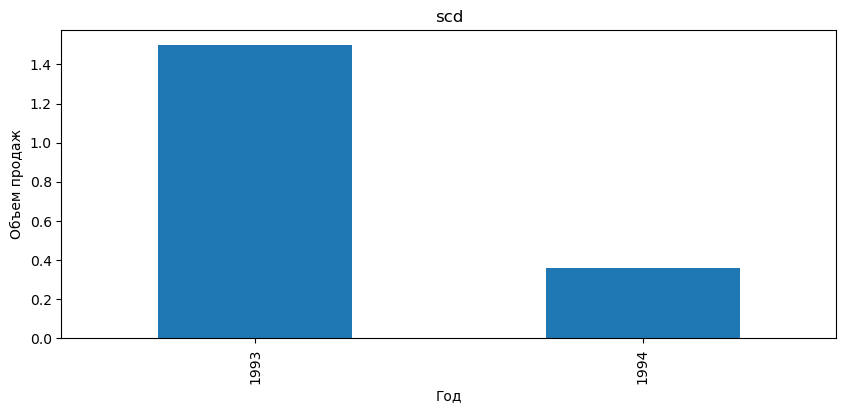

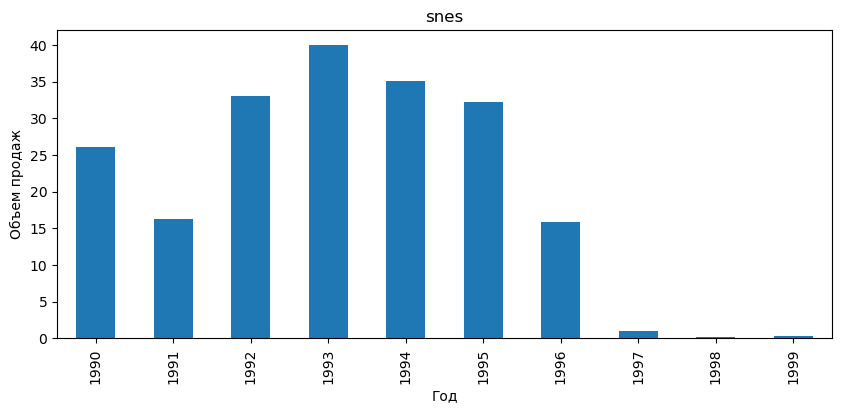

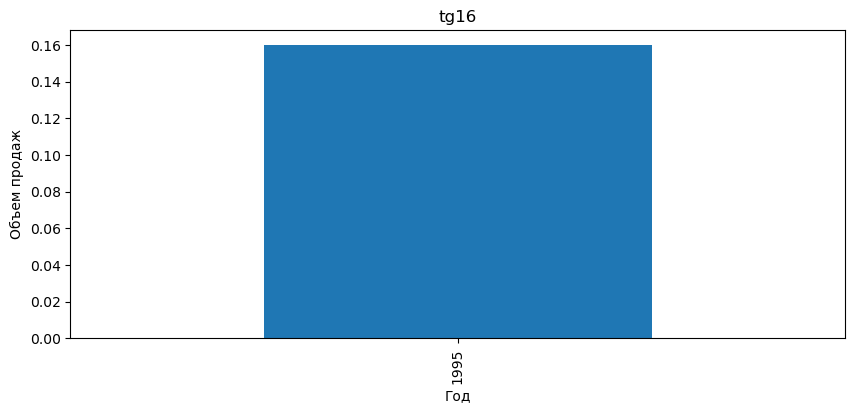

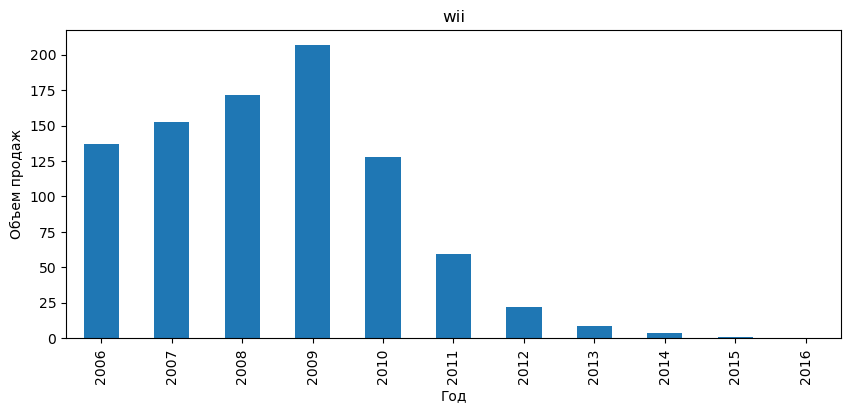

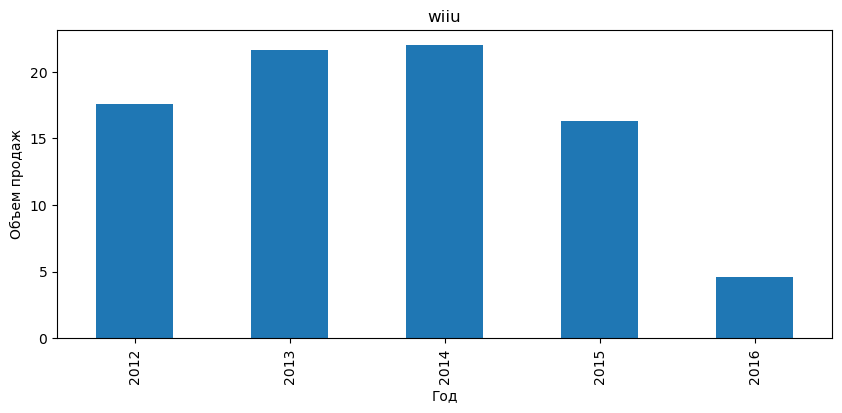

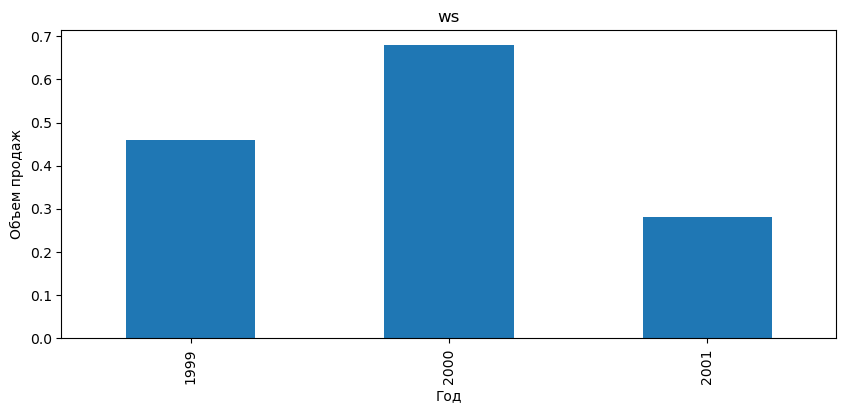

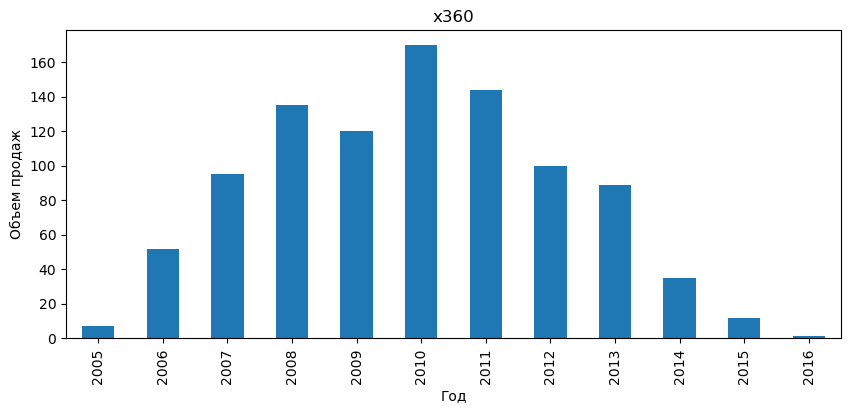

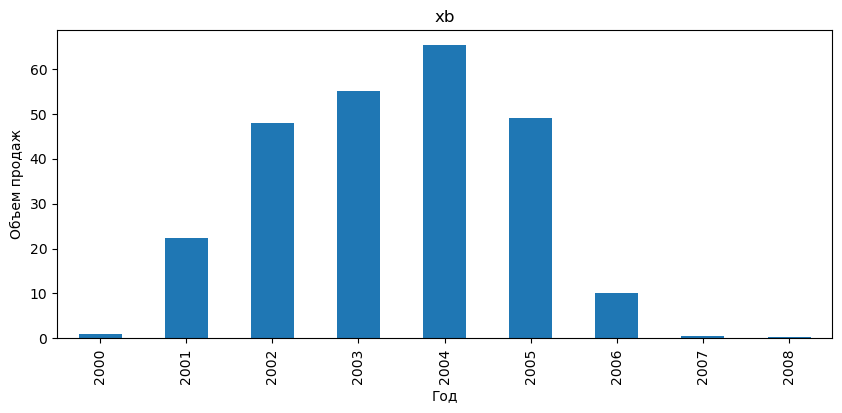

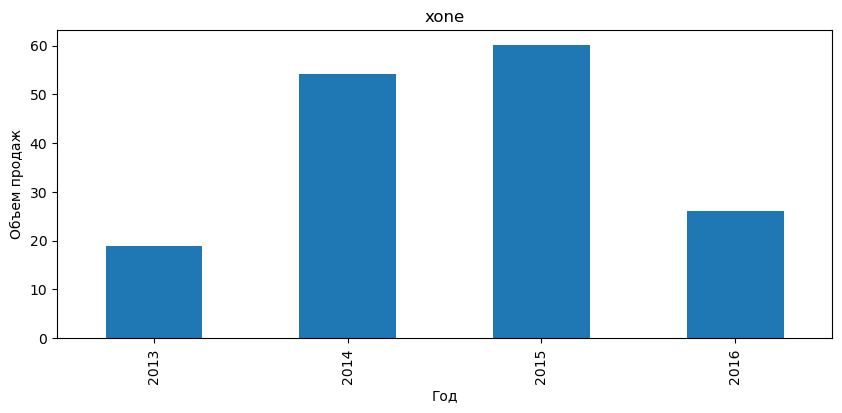

In [66]:
for plat in sales_per_platform_years['platform'].unique():
    sales_per_platform_years.query('platform == @plat'). \
    plot.bar( x= 'year', y='sum_sales', xlim = (1980,2016), legend=False, figsize = (10,4))
    plt.title(plat)
    plt.xlabel('Год')
    plt.ylabel('Объем продаж')
    plt.show()

Видим следующее:

1. Как мы уже отмечали, анализируя выпуск игр по годам - период выпуска игр в датафрейме - с 1980 по 2016 год. Всего платформ представлено 31.

2. Лидерами продаж (топ-5) за все время являются игры на платформах 
    - ps2 - 1233.6 миллиона проданных экземпляров игр, 
    - x360 - 961.3 миллиона экземпляров игр,
    - ps3 - 931.4 миллиона копий игр,
    - wii - 891.2 миллиона игр,
    - ds - 802.8 миллиона.          


3. Платформы разделяются по объемам продаж довольно четко на три категории:         
    - Платформы, которые "жили" в 80-90-е годы и прекратили свое существование или до начала нулевых, или в начале нулевых, по всей видимости в результпте обвала доткомов. Таких платформ 15.
    - Платформы, которые "родились" в 90-е или начале 2000-х и просуществовали до начала десятых годов. Прекращение их деятельности можно объяснить скорее бурным ростом смартфонов как конкурента и превращением их в платформу для игр; однако для некоторых возможно влияние экономического кризиса 2008-09 годов. Таких платформ 5.
    - Платформы, которые возникли в начале или середине нулевых и существуют до сих пор. Таких платформ 11.
    - Отдельно среди "нуне живущих" десяти платформ нужно выделить PC (персональные компьютеры), которые появились в качестве платформы вскоре после своего появления и распространения ( в 1985-м году) и продолжают оставаться одной из основных платформ для игр на момент исследования (то есть на конец 2016-го года). Необходимо так-же отметить, что этой платформы нет среди топ-5 наиболее коммерчески успешных платформ (возможно потому, что рынок игр для РС более открыт, диверсифицирован и меньше поддается учету).
    

4. Исходя из приведенных крафиков "характерный срок жизни" платформы видится равным 8-12 лет (в среднем - 10 лет). За этот срок большинство платформ "умирают" и на их смену приходят новые. Исключением здес является персональные компьютеры как плтформа.

С учетом всего отмеченного выше реальной ценностью для прогноза на 2017 обладают 11 платформ, которые демонстрируют хоть какой-то объем продаж с начала десятых годов по конец 2016 года. 

### Взять данные за соответствующий актуальный период. Актуальный период определить  в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывать в работе данные за предыдущие годы.

Как мы отметили ранее, когда анализировали выпуск игр по годам, характерным и наиболее полезным для задач исследования является период с 2012 по 2016 год включительно.      
При этом в рассмотрение есть смысл включать только те платформы, которые были активны в этот период.

Сформируем отдельный датафрейм, в который включим данные только за период 2012-2016 и посмотрим на него.

In [67]:
actual_games = games[(games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]

actual_games  # Смотрим что получилось

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,grand_theft_auto_v,ps3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,m,21.05
23,grand_theft_auto_v,x360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,m,16.27
31,call_of_duty_black_ops_3,ps4,2015,shooter,6.03,5.86,0.36,2.38,22.0,1.2,no_rating,14.63
33,pokemon_x_pokemon_y,3ds,2013,role_playing,5.28,4.19,4.35,0.78,35.0,1.4,no_rating,14.60
34,call_of_duty_black_ops_ii,ps3,2012,shooter,4.99,5.73,0.65,2.42,83.0,5.3,m,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16717,strawberry_nauts,psv,2016,adventure,0.00,0.00,0.01,0.00,17.0,0.0,no_rating,0.01
16721,aiyoku_no_eustia,psv,2014,misc,0.00,0.00,0.01,0.00,19.0,0.5,no_rating,0.01
16724,samurai_warriors_sanada_maru,ps3,2016,action,0.00,0.00,0.01,0.00,19.0,0.3,no_rating,0.01
16726,haitaka_no_psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,17.0,0.0,no_rating,0.01


In [63]:
display(actual_games['year_of_release'].value_counts().count())
display(actual_games['platform'].value_counts().count())
display(actual_games['name'].value_counts().count())

5

11

1671

Датафрейм сформирован.   
Данных существенно меньше, чем в изначальном - 2890 строк против 16724. 

Теперь в рассмотрении данные:       
    - за 5 лет;         
    - по 11 платформам;      
    - по 1671 игре.

### Ответить на вопрос: какие платформы лидируют по продажам, растут или падают? Выбрать несколько потенциально прибыльных платформ..

Начнем с лидеров продаж.

Выберем из 11 платформ топ-5, которые "дожили" до 2017-го года и показали максимальные суммарные продажи за эти 5 лет так же, как мы делали выборку для распределения продаж по годам.

In [68]:
# Аггрегируем по платформе и году и сохраняем результат в отдельном фрейме
actual_platforms = actual_games.groupby(['platform', 'year_of_release']) \
.agg({'name': ['count'], 'total_sales': ['sum']})

# Сбрасываем индекс и переименовуем столбцы
actual_platforms.reset_index(inplace=True)
actual_platforms.columns = ['platform', 'year', 'num_games', 'sum_sales']

# Аггрегируем только по платформе и сохраняем результат в отдельном фрейме
top_actual_platforms = actual_platforms.groupby(['platform']) \
.agg({'year': ['last'], 'num_games': ['sum'], 'sum_sales': ['sum']})

# Снова сбросим индекс и переименуем столбцы поудобнее
top_actual_platforms.reset_index(inplace=True)
top_actual_platforms.columns = ['platform', 'last_year', 'num_games', 'sum_sales']

# Сделаем сортировку по объему продаж и выделим топ-5 тех, кто "дожил" до 2017-го
top_actual_platforms = top_actual_platforms.sort_values(by='sum_sales', ascending=False)
top5_actual_platforms = top_actual_platforms.head(5)

# Смотрим что получилось
top5_actual_platforms

,platform,last_year,num_games,sum_sales
4,ps4,2016,392,314.14
3,ps3,2016,492,288.78
9,x360,2016,292,236.54
0,3ds,2016,396,194.61
10,xone,2016,247,159.32


Визуализируем. 

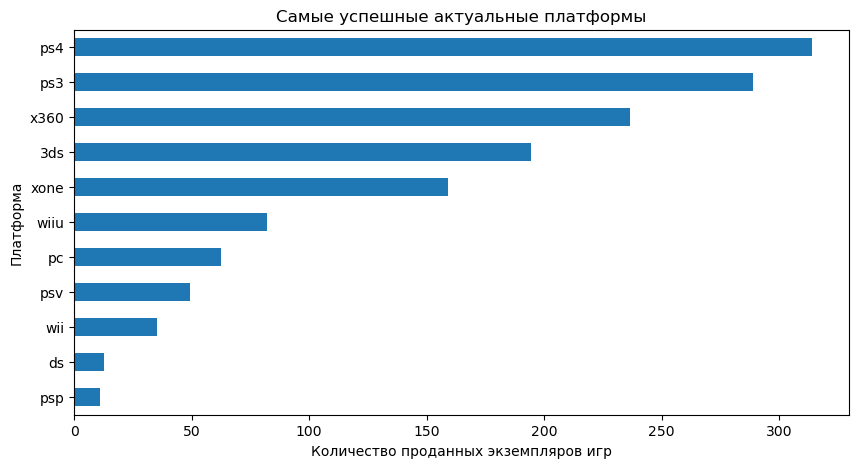

In [71]:
top_actual_platforms.sort_values(by='sum_sales', ascending=True). \
plot( kind = 'barh', x='platform', y= 'sum_sales', legend=False, figsize = (10,5))

plt.title('Самые успешные актуальные платформы')
plt.xlabel('Количество проданных экземпляров игр')
plt.ylabel('Платформа')

plt.show()

И посмотрим суммарные продажи для 11-ти актуальных платформ. 

In [72]:
top_actual_sales_sum = top_actual_platforms['sum_sales'].sum()
top5_actual_sales_sum = top5_actual_platforms['sum_sales'].sum()

display(top_actual_sales_sum)
display(top5_actual_sales_sum)

1446.44

1193.39

Таким образом: 

Суммарные продажи на 11-ти актуальных платформах составили 1447 миллионов экземпляров игр.   

В топ-5 платформ, которые не закончили активность до 2016 года и которые показали самые крупные продажи игр суммарно за последние 5 лет (с 2012 по 2016 включительно) входят: ps4, ps3, x360 3ds и xone.     
Отметим что pc как игровая платформа находится в этом списке только на 7-м месте.

Посмотрим как распределялись продажи у платформ из этой пятерки по годам. Сделаем это аналогично тому, как мы делали это для продаж по годам по всем платформам на основе датафрейма actual_platforms. 

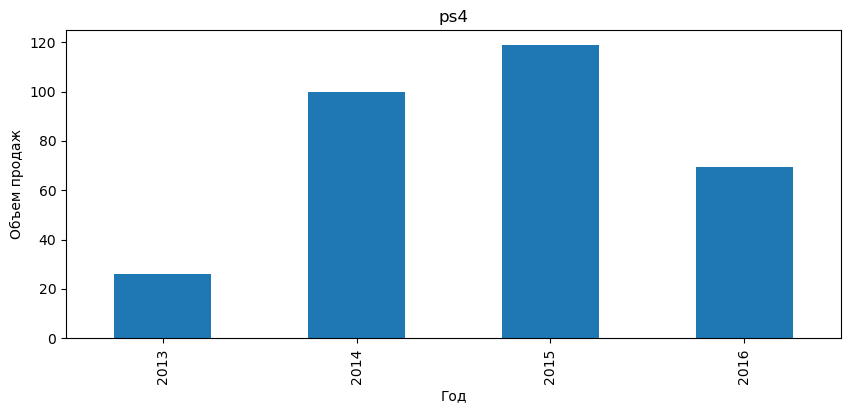

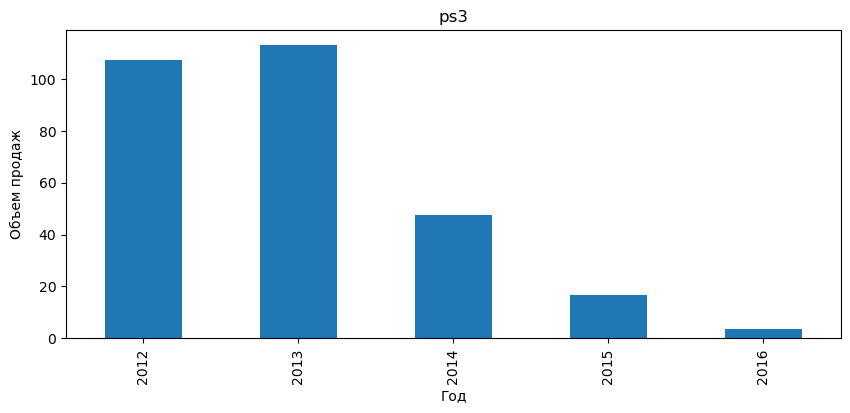

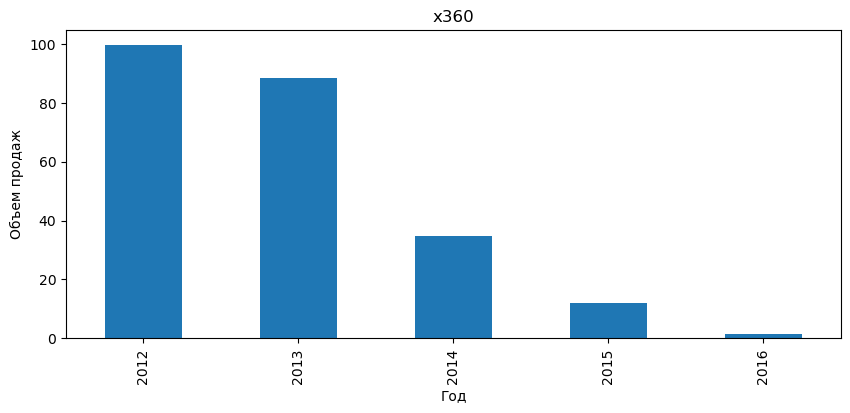

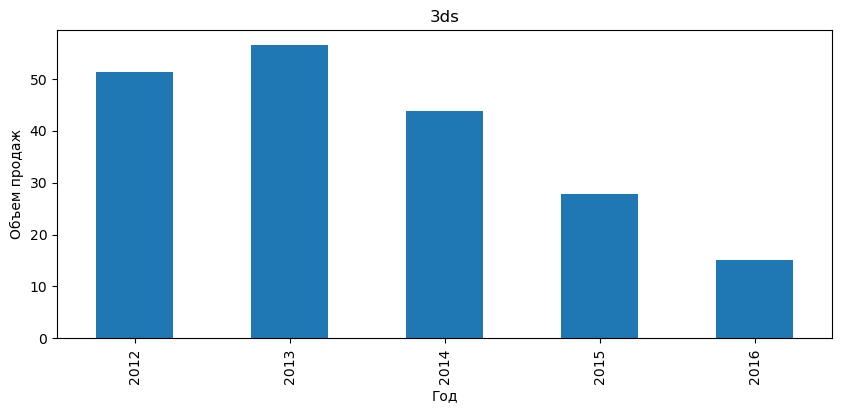

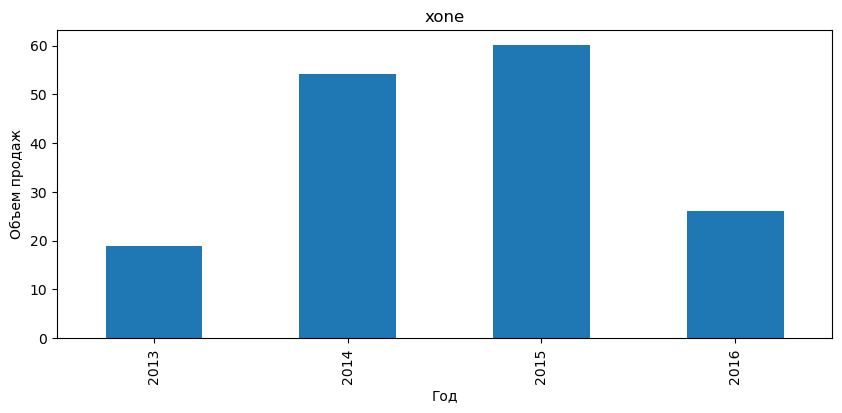

In [73]:
for plat in top5_actual_platforms['platform']:
    actual_platforms.query('platform == @plat').plot.bar( x= 'year', y='sum_sales', xlim = (2012,2016), legend=False, figsize = (10,4))
    plt.title(plat)
    plt.xlabel('Год')
    plt.ylabel('Объем продаж')
    plt.show()

По графикам видим:

Из топ-5 коммерчески успешных современных платформ, у ps3 и x360 продажи стабильно снижались с 2013-го года и в 2016-м упали практически до нуля. Думаестя, что вариантов какго-либо восстановления продаж на этих платформах нет. Там более, что по всей видимости платформа ps4 является апгрейдом для платформы ps3.       
Платформа 3ds хоть и не "уронила" продажи до нуля, однако на протяжении 2013-16 годов демонстрирует стабильный спад продаж, который вероятнее всего продолжится и в 2017-м году.      
Платформы xone и ps4 показывали стабильный рост продаж на протяжении 2013-15 годов. Данные за 2016-й год показывают снижжение, но нужно иметь вииду, что данные за этот год могут быть неполны (что по всей видимости так и есть). На самом деле похоже, что эти платформы  показали рост продаж в 2016-м году и вероятнее всего продолжат демонстрировать рост и в 2017-м году.
Помимо этих двух платформ не стоит забывать платформу, не входящую в топ-5, однако входящую в топ-10 и являющуюся самой универсальной и в этом отношении "вечной" - pc.

Таким образом предлагается считать перспективными потенциально прибыльными платформами ps4, xone и возможно не сбрасывать со счетов pc как наиболее "универсальную" платформу. 

### Построить график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Описать результат.

Как мы сформулировали чуть выше в дальнейшем есть смысл анализировать только те платформы, которые показывали активность за последние 5 лет (с 2012-го по 2016-й годы): чтобы не засорять анализ и не искажать выводы.        
Таких как мы выяснили 11, что видится вполне достаточным для полноценного анализа и формулировки выводов. Только если будут неоднозначности с выводами на основе этих актуальных данных - можно будет "углубиться в историю".

Построим график «ящик с усами» для платформ, перечисленных в датафрейме actual_platforms.

In [74]:
actual_platforms.groupby('platform').agg({'sum_sales': 'describe'})

sum_sales                                                        \
             count     mean        std    min      25%     50%       75%   
platform                                                                   
3ds            5.0  38.9220  17.170394  15.14  27.7800  43.760   51.3600   
ds             2.0   6.2750   6.696301   1.54   3.9075   6.275    8.6425   
pc             5.0  12.5140   6.749710   5.25   8.5200  12.380   13.2800   
ps3            5.0  57.7560  50.615455   3.60  16.8200  47.760  107.3500   
ps4            4.0  78.5350  40.567917  25.99  58.4350  84.625  104.7250   
psp            4.0   2.7975   3.547942   0.12   0.2100   1.690    4.2775   
psv            5.0   9.8360   4.724000   4.25   6.2500  10.590   11.9000   
wii            5.0   7.0740   8.807657   0.18   1.1400   3.750    8.5900   
wiiu           5.0  16.4380   7.068244   4.60  16.3500  17.560   21.6500   
x360           5.0  47.3080  44.599522   1.52  11.9600  34.740   88.5800   
xone           4.0  39.8300  20.313977  18.96  24.3525  40.110   55.5875   

                  
             max  
platform          
3ds        56.57  
ds         11.01  
pc         23.14  
ps3       113.25  
ps4       118.90  
psp         7.69  
psv        16.19  
wii        21.71  
wiiu       22.03  
x360       99.74  
xone       60.14

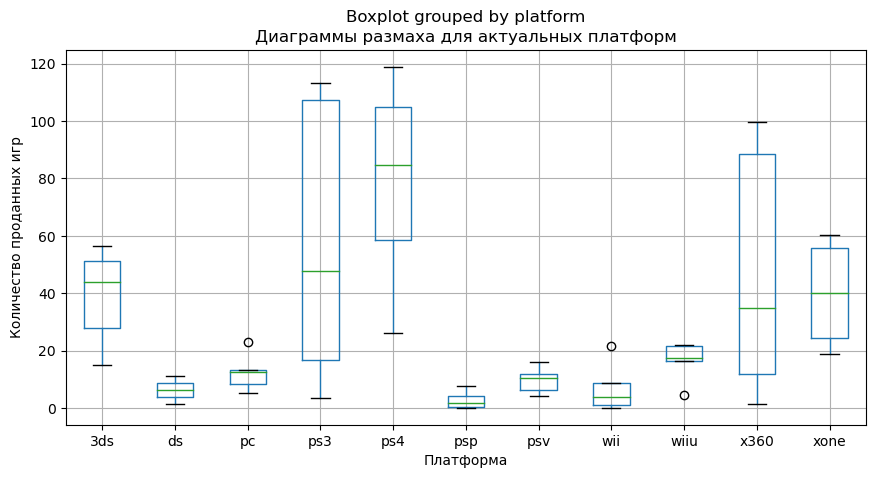

In [75]:
actual_platforms.boxplot(column=['sum_sales'], by='platform', figsize=(10,5))
plt.title('Диаграммы размаха для актуальных платформ')
plt.xlabel('Платформа')
plt.ylabel('Количество проданных игр')
plt.show()

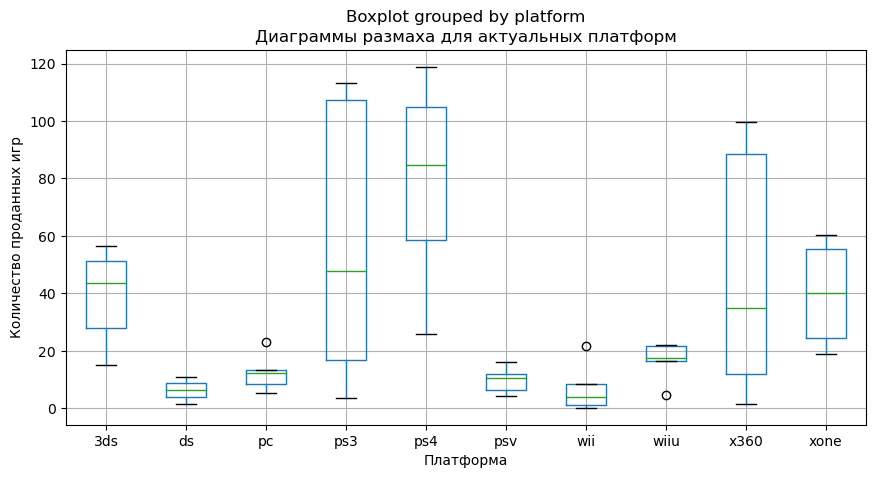

In [76]:
actual_platforms_no_psp = actual_platforms.loc[actual_platforms['platform'] != 'psp']
actual_platforms_no_psp.boxplot(column=['sum_sales'], by='platform', figsize=(10,5))
plt.title('Диаграммы размаха для актуальных платформ')
plt.xlabel('Платформа')
plt.ylabel('Количество проданных игр')
plt.show()

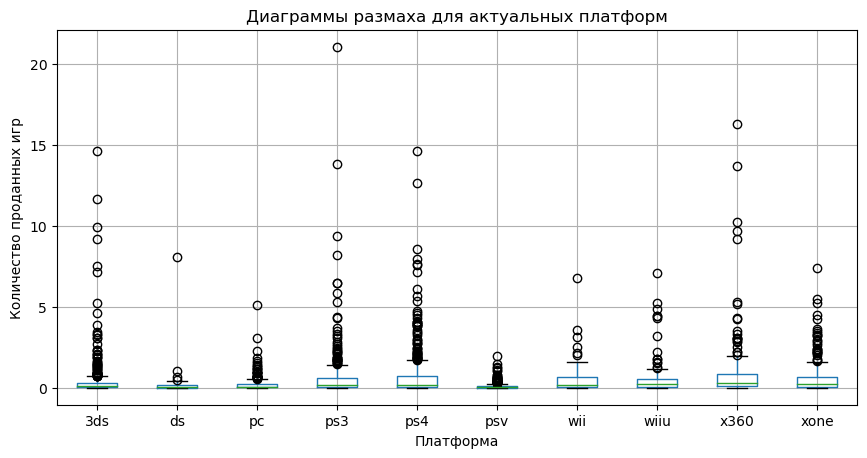

In [77]:
actual_games_no_psp = actual_games.loc[actual_games['platform'] != 'psp']
actual_games_no_psp.boxplot(column=['total_sales'], by='platform', return_type='dict', figsize=(10,5))
plt.suptitle(None)
plt.title('Диаграммы размаха для актуальных платформ')
plt.xlabel('Платформа')
plt.ylabel('Количество проданных игр')
plt.show()

По диаграммам размаха видим:

Из 11 анализируемых платформ 6 обладают довольно "компактным" видом, то есть относительно небольшие средние и медианные параметры (в пределах 20 миллионов проданных экземпляров), небольшим межквартильным размахом (около 5 М) и довольно компактными "усами" (в пределах 10 М). При этом 4 из этих 6-то имеют средний и медианный объемы продаж меньше 10 М экземпляров.      
"Выбросы" присутствуют только у терх платформ в выборке, это pc, wii и wiiu. Все они входят в шестерку "малых" платформ.   
Следующие 4 относительно больших с точки зрения продаж платформ: 3ds, ps3, x360 и xone, имеют средний объем продаж на уровне от 35 до 60 миллионов экземпляров игр, медианы на уровне от 35 до 48 М и  подразделяются на две части по две платформы.      
3ds и xone имеют средние чуть пониже второй группы, но являются довольно стабильными с небольшим межквартильным размахом (чуть больше 20 М) и "усами" (около 40 М);      
ps3 и x360 деманстрируют отличающиеся средние (57 и 47 М соответственно), столь же разные медианы (48 и 35 М) и довольно значительный "разброс" - межквартильный размах на уровне 90 и 75 М соответственно и "усы" - около 100 миллионов.

На диаграмме размаха, учитывающей продажи всех игр за все периоды отчетливо видим, что практически на каждой платформу очень много "выбросов вверх". По всей видимости это свидетельствует о том, что игры - это продукт "эмоциональный", которому свойственен разброс эмоционального восприятия отдельных игр и элементы ажтотажа.

Самой коммерчески успешной платформой можно считать ps4. Ее средние продажи составляют 78  миллионов экземпляров, медиана равна 104 М, межквартильный размах ок. 47 М и усы ок 90 М. С учетом того, что как мы отмечали ранее эта платформа появилась в 2013 году и с тех пор демонстрирует стабильный рост продаж - ее можно считать неоспоримым лидером. 

### Посмотреть, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построить диаграмму рассеяния и посчитать корреляцию между отзывами и продажами. Сформулировать выводы.

В качестве "подопытного кролика" предлагается взять например платформу 3ds: эта платформа возможно все еще актуальна (она имеет ненулевые продажи в 2016-м году), она входит в топ-5, она на протяжении полседних 5 лет демонстрировала и увеличение и спад продаж ( в отличие от ps4 и xone, которые демонстрируют стабильный рост и от ps3 и x360, которые стабильно "падают") и на ней продавалось 397 игр (ежегодно около 80-90 игр), что даст хороший базис для сопоставления.

Построим на ее основные параметры.

In [78]:
actual_platforms.loc[actual_platforms['platform'] == '3ds'].describe()

,year,num_games,sum_sales
count,5.0,5.000000,5.000000
mean,2014.0,79.200000,38.922000
std,1.581139,19.227584,17.170394
min,2012.0,46.000000,15.140000
25%,2013.0,80.000000,27.780000
50%,2014.0,86.000000,43.760000
75%,2015.0,91.000000,51.360000
max,2016.0,93.000000,56.570000


Наверное есть смысл делать анализ на основе датафрейма actual_games.

In [79]:
games_3ds = actual_games.loc[actual_games['platform'] == '3ds']

# Аггрегируем по играм
sales_3ds = games_3ds.groupby(['name']) \
.agg({'critic_score': ['mean'], 'user_score': ['mean'], 'total_sales': ['mean']})

# Сбрасываем индекс и переименовуем столбцы
sales_3ds.reset_index(inplace=True)
sales_3ds.columns = ['name', 'critic_score', 'user_score', 'total_sales']

# Смотрим что получилось
sales_3ds

,name,critic_score,user_score,total_sales
0,12_sai__honto_no_kimochi,17.0,0.0,0.07
1,12_sai__koisuru_diary,17.0,0.0,0.05
2,3ds_classic_collection,19.0,0.5,0.03
3,50_classic_games,19.0,0.5,0.01
4,7th_dragon_iii_code_vfd,77.0,8.2,0.16
...,...,...,...,...
391,yu_gi_oh!_zexal_world_duel_carnival,19.0,0.5,0.17
392,yumi's_odd_odyssey,74.0,7.7,0.03
393,zero_escape_virtue's_last_reward,88.0,8.8,0.03
394,zero_escape_zero_time_dilemma,81.0,8.5,0.08


Посчитаем коэффициент корреляции для данных из столбца "total_sales" и данных из столбцов "critic_score" и "user_score" и посмотрим.

In [80]:
# Считаем коэффициент корреляции между "total_sales" и "critic_score" 
corr_sales_critics_3ds = sales_3ds['total_sales'].corr(sales_3ds['critic_score'])

# Считаем коэффициент корреляции между "total_sales" и "user_score"
corr_sales_users_3ds = sales_3ds['total_sales']. corr(sales_3ds['user_score'])

# Смотрим что получилось
print('корреляция между "total_sales" и "critic_score" = ', corr_sales_critics_3ds )
print('корреляция между "total_sales" и "user_score" = ', corr_sales_users_3ds )

корреляция между "total_sales" и "critic_score" =  0.18720871522730398
корреляция между "total_sales" и "user_score" =  0.14246821489909195


Построим диаграмму рассеяния для этих же пар: столбца "total_sales" и столбцов "critic_score" и "user_score" и посмотрим.

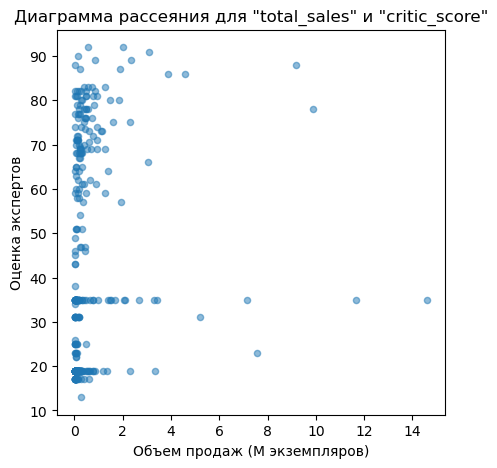

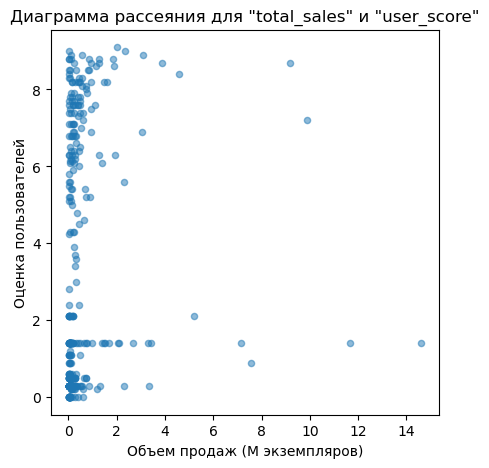

In [81]:
# Построим диаграмму рассеяния для "total_sales" и "critic_score"
sales_3ds.plot( x = 'total_sales', y = 'critic_score', kind = 'scatter', alpha = 0.5, figsize = (5,5))
plt.title('Диаграмма рассеяния для "total_sales" и "critic_score"')
plt.xlabel('Объем продаж (М экземпляров)')
plt.ylabel('Оценка экспертов')

# Аналогично построим диаграмму рассеяния для "total_sales" и "user_score"
sales_3ds.plot( x = 'total_sales', y = 'user_score', kind = 'scatter', alpha = 0.5, figsize = (5,5))
plt.title('Диаграмма рассеяния для "total_sales" и "user_score"')
plt.xlabel('Объем продаж (М экземпляров)')
plt.ylabel('Оценка пользователей')

plt.show()


Получилось не очень. 

Коэффициент корреляции между оценкой критиков и количеством проданных экземпляров игр равен 0.19, а между тем же количеством проданных игр и оценкой пользователей - 0.13.     
То есть можно предполагать, что объем продаж никак не зависит от оценок как экспертов, так и пользователей.    
Диаграммы рассеяния подтверждают такой вывод, хотя интуитивно это кажется сомнительным: хочется верить в хорошее и предполагать, что голоса пользователей все-таки на что-то влияют.

### Соотнести выводы с продажами игр на других платформах..

Посчитаем коэффициенты корреляции и построим диаграммы рассеяния для остальных четырех платформ из топ-5: ps4, ps3, x360 и xone.

Сделаем это на основе того же датафрейма actual_games.

In [82]:
# Аггрегируем по платформам и играм
sales_actual_platforms = actual_games.groupby(['platform','name']) \
.agg({'critic_score': ['mean'], 'user_score': ['mean'], 'total_sales': ['mean']})

# Сбрасываем индекс и переименовуем столбцы
sales_actual_platforms.reset_index(inplace=True)
sales_actual_platforms.columns = ['platform', 'name', 'critic_score', 'user_score', 'total_sales']

# оставляем только нужные нам столбцы
top5_platforms_no3ds = ['ps3', 'ps4', 'x360', 'xone']
sales_actual_platforms_no3ds = sales_actual_platforms.query('platform in @top5_platforms_no3ds')
#sales_actual_platforms_no3ds = sales_actual_platforms.loc[sales_actual_platforms['platform'] in top5_platforms_no3ds]

# Смотрим что получилось
display(sales_actual_platforms_no3ds['platform'].unique())
sales_actual_platforms_no3ds.head(5)

array(['ps3', 'ps4', 'x360', 'xone'], dtype=object)

,platform,name,critic_score,user_score,total_sales
676,ps3,2014_fifa_world_cup_brazil,73.0,4.3,0.61
677,ps3,3rd_super_robot_wars_z_jigoku_hen,35.0,1.4,0.23
678,ps3,3rd_super_robot_wars_z_tengoku_hen,19.0,0.3,0.15
679,ps3,[prototype_2],79.0,6.8,0.74
680,ps3,_hack_sekai_no_mukou_ni_+_versus,19.0,0.3,0.03


Посмотрим на коэффициенты корреляции для каждой платформы.

Платформа ps3
корреляция между "total_sales" и "critic_score" =  0.31172098597033465
корреляция между "total_sales" и "user_score" =  0.18849246170709555


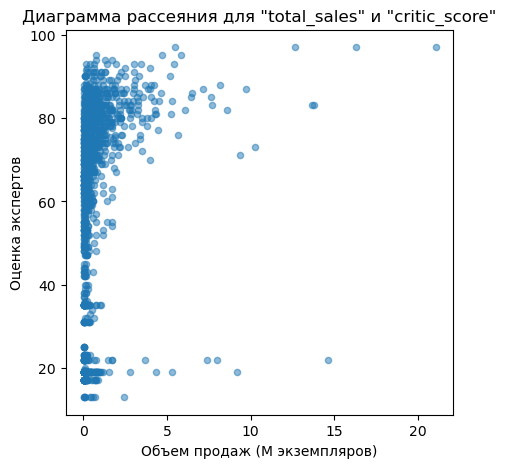

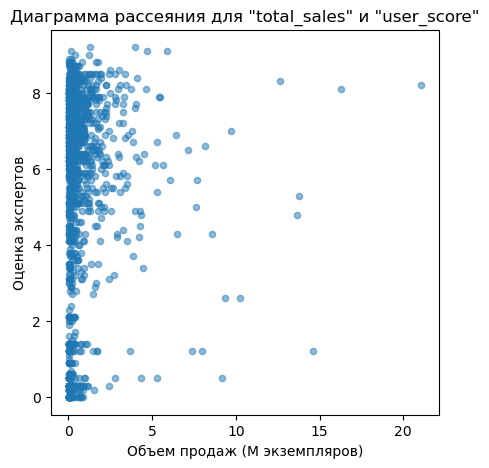

----------------------------------------------------------------------
Платформа ps4
корреляция между "total_sales" и "critic_score" =  0.24927021610786546
корреляция между "total_sales" и "user_score" =  0.10347199148229859


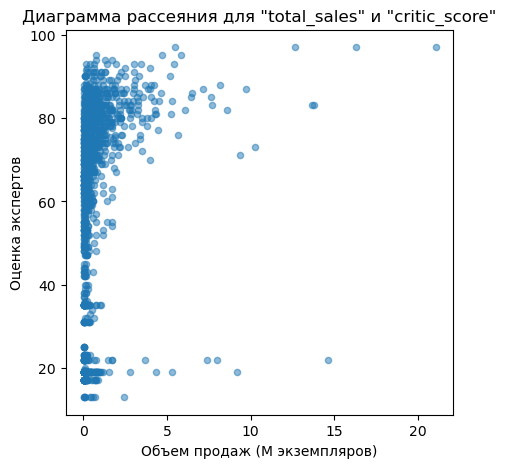

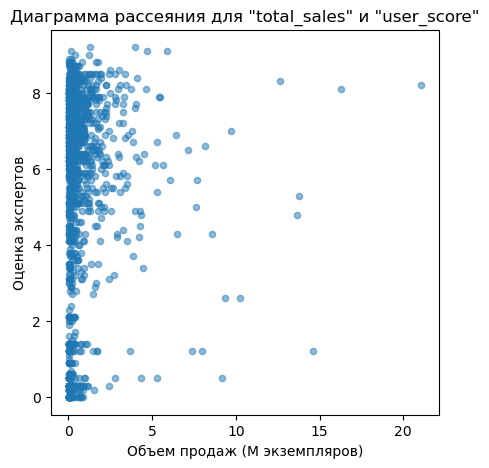

----------------------------------------------------------------------
Платформа x360
корреляция между "total_sales" и "critic_score" =  0.2646999276955722
корреляция между "total_sales" и "user_score" =  0.07381966096627542


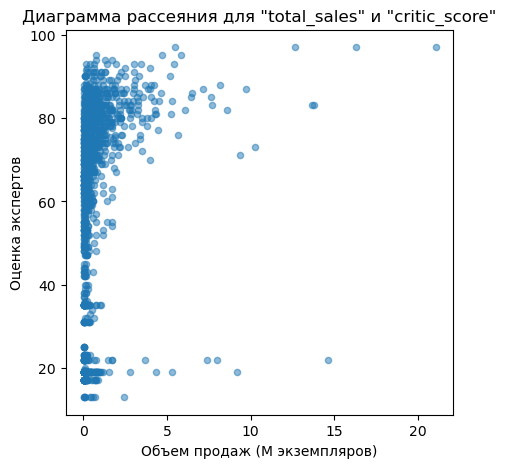

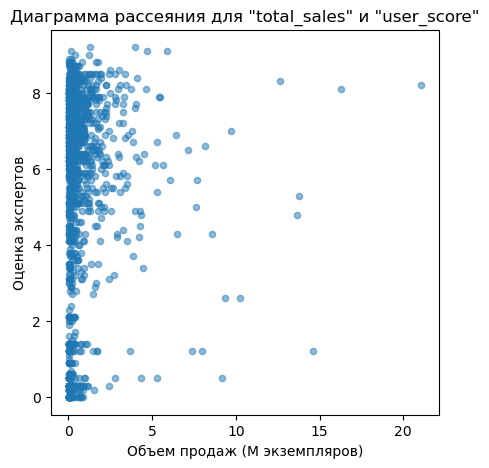

----------------------------------------------------------------------
Платформа xone
корреляция между "total_sales" и "critic_score" =  0.2336479822356271
корреляция между "total_sales" и "user_score" =  0.026114569145721134


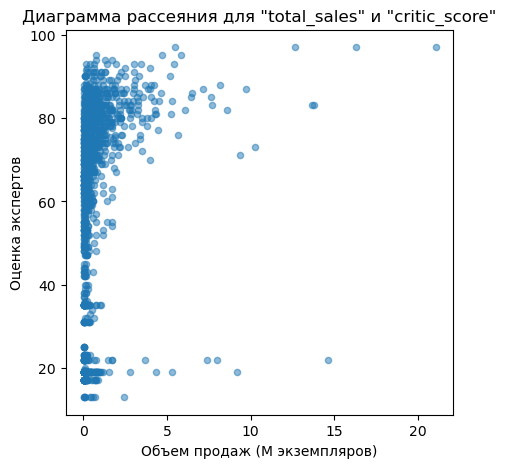

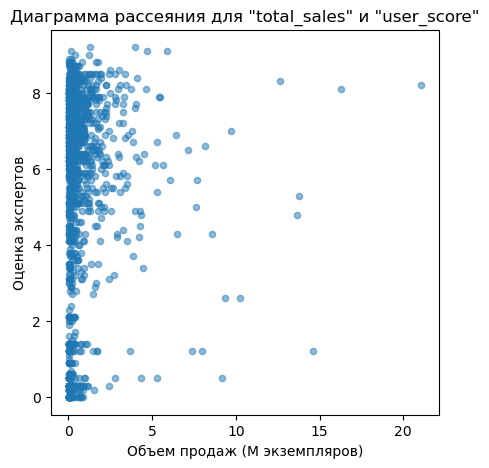

----------------------------------------------------------------------


In [83]:
# Для каждой четырех платформ
for plat in sales_actual_platforms_no3ds['platform'].unique():
    
    print('Платформа', plat)
    sales_plat = sales_actual_platforms_no3ds.loc[sales_actual_platforms_no3ds['platform'] == plat]
    
    # Посчитаем и выведем коэффициент корреляции между "total_sales" и "critic_score" и "user_score"
    corr_sales_critics_no3ds = sales_plat['total_sales'].corr(sales_plat['critic_score'])
    corr_sales_users_no3ds = sales_plat['total_sales'].corr(sales_plat['user_score'])
    print('корреляция между "total_sales" и "critic_score" = ', corr_sales_critics_no3ds )
    print('корреляция между "total_sales" и "user_score" = ', corr_sales_users_no3ds )
    
    # Построим диаграммы рассеяния 
    sales_actual_platforms_no3ds.plot( x = 'total_sales', y = 'critic_score', kind = 'scatter', alpha = 0.5, figsize = (5,5))
    plt.title('Диаграмма рассеяния для "total_sales" и "critic_score"')
    plt.xlabel('Объем продаж (М экземпляров)')
    plt.ylabel('Оценка экспертов')
    plt.show()
    
    sales_actual_platforms_no3ds.plot( x = 'total_sales', y = 'user_score', kind = 'scatter', alpha = 0.5, figsize = (5,5))
    plt.title('Диаграмма рассеяния для "total_sales" и "user_score"')
    plt.xlabel('Объем продаж (М экземпляров)')
    plt.ylabel('Оценка экспертов')
    plt.show()
    
    print('----------------------------------------------------------------------')

Остальные платформы из топ-5 только подтвердили неутешительный вывод, который мы сделали на основании анализа платформы 3ds:         
Коэффициенты корреляции для оценок критиков варьируются от 0.23 до 0.31, а для оценок пользователей - от 0.06 до 0.22.     
Такие коэффициенты корреляции свидетельствуют о том, что зависимости объема продаж от оценок как критиков, так и пользователей фоактически нет никакой.      
Этот же вывод подтверждает и вид диаграмм рассеяния, где не наблюдается никакой формы, сколько-нибудь напоминающей "веретино", направленное в какую-нибудь сторону.

### Посмотреть на общее распределение игр по жанрам. Ответить на вопросы: что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

По всей видимости здесь так-же, как и для платформ есть смысл анализировать игры и жанры, представленные на 11 "живых" платформах, не "углубляясь в историю" (как бы это ни было интересно) чтобы не подвергать выводы риску искажения неактуальной информацией.

Посмотрим сколько жанров у нас в рассмотрении судя в датафрейме actual_games.

In [84]:
display(actual_games['genre'].value_counts().count())
actual_games['genre'].value_counts()

12

genre
action          1031
role_playing     370
adventure        302
sports           267
shooter          235
misc             192
racing           114
fighting         109
platform          85
simulation        80
strategy          71
puzzle            28
Name: count, dtype: int64

Итак у нас есть данные:
- по 1671 игре
- в 12 жанрах;
так-же помним, что
- данные за 5 лет;
- по 11 платформам.

Сгруппируем данные по жанрам, отсортируем по объему продаж в каждом жанре и посмотрим на самые прибыльные (и не самые прибыльные) жанры (так же, как мы это делали выше для платформ).

In [85]:
actual_games.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,grand_theft_auto_v,ps3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,m,21.05
23,grand_theft_auto_v,x360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,m,16.27
31,call_of_duty_black_ops_3,ps4,2015,shooter,6.03,5.86,0.36,2.38,22.0,1.2,no_rating,14.63
33,pokemon_x_pokemon_y,3ds,2013,role_playing,5.28,4.19,4.35,0.78,35.0,1.4,no_rating,14.60
34,call_of_duty_black_ops_ii,ps3,2012,shooter,4.99,5.73,0.65,2.42,83.0,5.3,m,13.79


In [86]:
# Аггрегируем по жанру и году и сохраняем результат в отдельном фрейме
actual_genres = actual_games.groupby(['genre', 'year_of_release']) \
.agg({'name': ['count'], 'total_sales': ['sum']})

# Сбрасываем индекс и переименовуем столбцы
actual_genres.reset_index(inplace=True)
actual_genres.columns = ['genre', 'year', 'num_games', 'sum_sales']

# Аггрегируем только по жанру и сохраняем результат в отдельном фрейме
top_actual_genres = actual_genres.groupby(['genre']) \
.agg({'year': ['last'], 'num_games': ['sum'], 'sum_sales': ['sum']})

# Снова сбросим индекс и переименуем столбцы поудобнее
top_actual_genres.reset_index(inplace=True)
top_actual_genres.columns = ['genre', 'last_year', 'num_games', 'sum_sales']

# Сделаем сортировку по объему продаж и выделим топ-5
top_actual_genres = top_actual_genres.sort_values(by='sum_sales', ascending=False)
top5_actual_genres = top_actual_genres.head(5)

# Смотрим что получилось
top_actual_genres
#top5_actual_genres

,genre,last_year,num_games,sum_sales
0,action,2016,1031,441.12
8,shooter,2016,235,304.73
7,role_playing,2016,370,192.80
10,sports,2016,267,181.06
3,misc,2016,192,85.04
4,platform,2016,85,61.00
6,racing,2016,114,53.42
2,fighting,2016,109,44.49
9,simulation,2016,80,35.12
1,adventure,2016,302,29.43


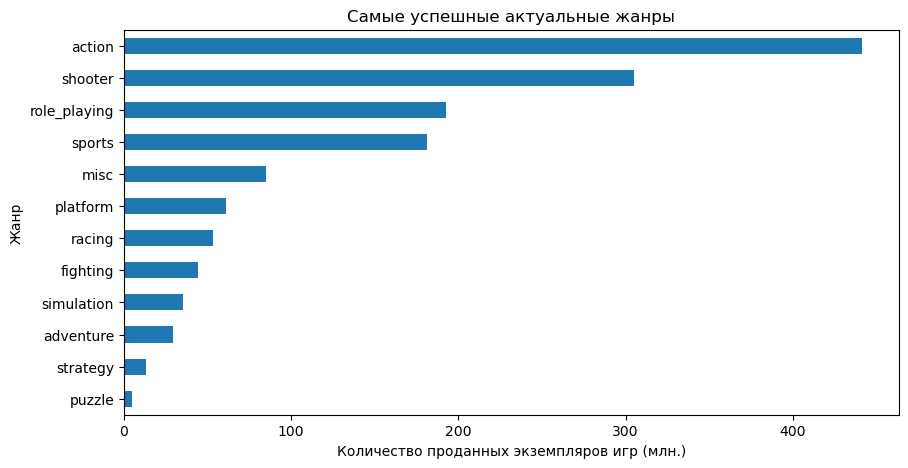

In [88]:
top_actual_genres.sort_values(by='sum_sales', ascending=True). \
plot( kind = 'barh', x= 'genre', y= 'sum_sales', legend=False, figsize = (10,5))

plt.title('Самые успешные актуальные жанры')
plt.xlabel('Количество проданных экземпляров игр (млн.)')
plt.ylabel('Жанр')

plt.show()

И посмотрим суммарные продажи для 12-ти актуальных жанров. 

In [89]:
top_actual_genres_sum = top_actual_genres['sum_sales'].sum()
top5_actual_genres_sum = top5_actual_genres['sum_sales'].sum()

display(top_actual_genres_sum)
display(top5_actual_genres_sum)

1446.44

1204.75

Навскидку кажется, что топ-5 самых успешных жанров - это "action", "shooter", "role-playing", "sports" и "misc".   
Однако прежде чем самые перспективные жанры учтем, что количество игр в разных жанрах разное цифры по суммарным продажам могут не в полной мере отражать "успешность" и "перспективность" жанра. 

В качестве перспективных есть смысл брать жанры, в которых игры стабильно приносят высокий доход, то есть жанры с высоким средним доходом на игру и с малым количеством "выбросов" в распределении.
Поэтому сначала посмотрим параметр средней доходности на игру в каждом из 12 актуальных жанров, проверим их на выбросы и только после этого сделаем окончательный вывод. 

Вычислим среднее количество проданных копий на одну игру разделив в датафрейме top_actual_genres данные о суммарных продажах ( из столбца "sum_sales") на данные о количестве продававшихся игр в этом жанре (из столбца "num_games") и добавим отдельным столбцом в этот же датафрейм.

In [90]:
top_actual_genres['sales_per_game'] = top_actual_genres['sum_sales'] / top_actual_genres['num_games']

top_actual_genres

,genre,last_year,num_games,sum_sales,sales_per_game
0,action,2016,1031,441.12,0.427856
8,shooter,2016,235,304.73,1.296723
7,role_playing,2016,370,192.80,0.521081
10,sports,2016,267,181.06,0.678127
3,misc,2016,192,85.04,0.442917
4,platform,2016,85,61.00,0.717647
6,racing,2016,114,53.42,0.468596
2,fighting,2016,109,44.49,0.408165
9,simulation,2016,80,35.12,0.439000
1,adventure,2016,302,29.43,0.097450


И посмотрим как распределены платформы по среднему доходу на игру. 

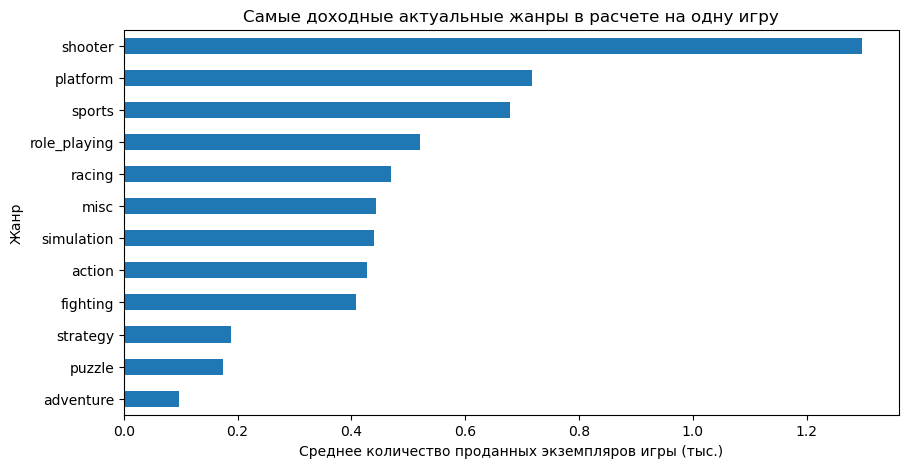

In [92]:
top_actual_genres.sort_values(by='sales_per_game', ascending=True). \
plot( kind = 'barh', x= 'genre', y= 'sales_per_game', legend=False, figsize = (10,5))

plt.title('Самые доходные актуальные жанры в расчете на одну игру')
plt.xlabel('Среднее количество проданных экземпляров игры (тыс.)')
plt.ylabel('Жанр')

plt.show()

Построим  размаха для всех жанров в цифрах.

In [93]:
actual_genres.groupby('genre').agg({'sum_sales': 'describe'})

sum_sales                                                        
                 count    mean        std    min    25%    50%     75%     max
genre                                                                         
action             5.0  88.224  38.272239  30.11  72.02  97.23  119.25  122.51
adventure          5.0   5.886   1.548396   3.82   5.57   5.79    6.09    8.16
fighting           5.0   8.898   4.250938   4.47   7.09   7.90    9.18   15.85
misc               5.0  17.008   9.659067   2.60  11.57  22.22   23.38   25.27
platform           5.0  12.200   8.945949   3.23   6.05   8.81   18.37   24.54
puzzle             5.0   0.978   0.674885   0.01   0.71   0.96    1.49    1.72
racing             5.0  10.684   5.380593   2.79   8.07  12.37   13.53   16.66
role_playing       5.0  38.560  11.942037  18.18  37.64  44.45   45.62   46.91
shooter            5.0  60.946  13.187704  38.22  62.04  65.21   67.51   71.75
simulation         5.0   7.024   4.272813   1.89   5.58   5.66    8.63   13.36
sports             5.0  36.212   8.963823  23.49  30.41  40.84   41.17   45.15
strategy           5.0   2.668   2.130181   0.98   1.13   1.85    3.26    6.12

Построим диаграмму размаха («ящик с усами») для всех жанров за пять последних лет...

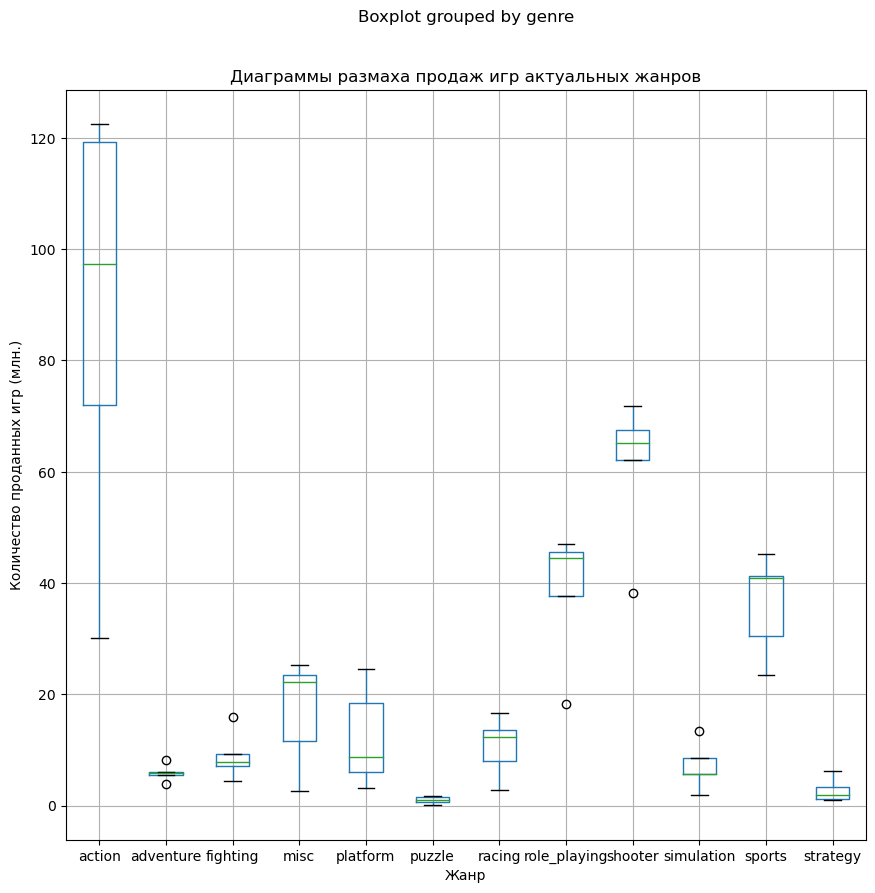

In [95]:
actual_genres.boxplot(column=['sum_sales'], by='genre', figsize=(10,10))
plt.title('Диаграммы размаха продаж игр актуальных жанров')
plt.xlabel('Жанр')
plt.ylabel('Количество проданных игр (млн.)')
plt.show()

... и за все время

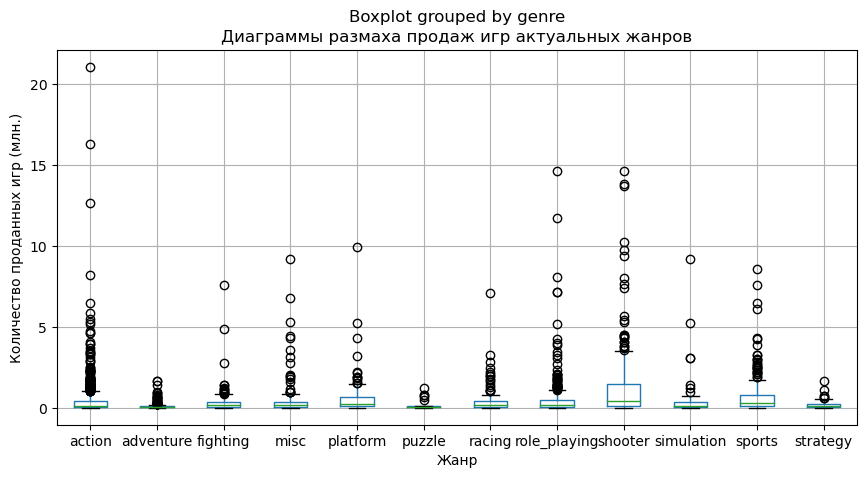

In [96]:
actual_games_no_psp.boxplot(column=['total_sales'], by='genre', figsize=(10,5))
plt.title('Диаграммы размаха продаж игр актуальных жанров')
plt.xlabel('Жанр')
plt.ylabel('Количество проданных игр (млн.)')
plt.show()

Видим следующее:

1. Как мы уже отмечали, игры, которые продавались за поледние 5 лет - с 2012 по 2016 год представлены в 12 жанрах. Суммарные продажи игр этих жанров составили за 5 лет 1447 миллионов экземпляров.

2. Представленные жанры разделяются по объемам продаж довольно четко на четыре выраженных категории:         
    - Явного лидера продаж - жанр action с 1033 играми в этом жанре и 441 миллионом проданных копий этих игр;
    - Ближайших преследователей, которые представлены четырьмя жанрами
        - ближайший преследователь - жанр shooter с 235 играми в этом жанре и 305 миллионами проданных копий,
        - занимающий третье место жанр - role-playing, с 370 играми и 193 миллионами проданных экземпляров,
        - и наконец четвертый жанр - sports, который насчитывает 268 игр и 181 миллион продаж;
        - к этой же группе есть смысл отнести и жанр misc, который хоть и уступает остальным в количестве игр (их 193) и             объеме продаж (85 миллионов копий), но по крайней мере входит в топ-5 и в нем еще может что-то произойти.
    - Жанры, которые можно назвать "середняками" или "болотом". Это обладают гораздо объемами продаж, вдвое меньшими, чем у       категории "преследователей" - от 30 до 61 миллионов. Таких жанров 5. При этом количество игр в этих жанрах                 варьируется от 80 в жанре simulation до 303 в жанре adventure. 
    - Два явных аутсайдера - жанры, продажи у которых в разы меньше, чем даже у предыдущей категории - "середнячков". Это
        - strategy с 71 представленной игрой и 13 миллионами проданных копий, 
        - puzzle c 28 играми и 5-ю миллионами продаж.
    
При этом разрыв в продажах между первыми двумя группами и всеми остальными таков, что возникают большие сомнения, что игры  в этих жанрах групп "середнячки" и "аутсайдеры" смогут когда-нибудь вырваться в топ.     
Исключение может теоретически составить каких-нибудь отдельная гениальная разработка, но это безусловно будет представлять собой "выброс", то есть исключение.    
Однако нужно иметь ввиду, что самый "топовый" жанр является и самым волатильным, демонстрируя "размах усов" примерно на 100 миллионов игр, что делает его очень рискованным для продвижения: в этом жанре игра игре - рознь с точки зрения успешности.
Кроме того нужно цчитывать, что большинство жанров имеют "выбросы". Успокаивает только то, что практически все эти выбросы - вверх (в сторону большей успешности). 

С точки зрения перспективности наше предположение о том, что перспективными являются "глупо" лидеры продаж, должно быть скорректировано с учетом данных о средней "доходности игры" и разброса параметров продаж.

С учетом того, что в качестве перспективных есть смысл брать жанры, в которых игры стабильно приносят высокий доход, то есть жанры с высоким средним доходом на игру и с малым количеством "выбросов" в распределении, можно предложить самыми песпективными играми на 2017 считать следующие:  "shooter", "platform", "role-playing" и "sports". При этом в отношении "shooter" и "role-playing" нужно иметь ввиду, что у них бывают "выбросы вниз" (то есть провалы продаж). Даже в качестве "запасного" есть смысл взять не жанр "action", показывающий высокую волатильность и довольно среднюю доходность на игру, а например жанр "racing" или "misc", демонстрирующих большую доходность на игру и большую "компактность".

## Шаг 4. Составление портрета пользователя каждого региона

### Определить для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5). Описать различия в долях продаж.

Будем анализировать игры, представленные на 11 "живых" платформах. 

Поскольку в описании проекта и в представленных данных явно выделены 4 региона, будем проводить дальнейший анализ для этих 4-х регионов:     
США и Канада (столбец "na_sales"),       
Европа = Евросоюз (столбец "eu_sales"),       
Япония (столбец "jp_sales"),        
и весь остальной мир (столбец "other_sales").        

Чтобы не терять полноты картины будем выводить не только топ-5, но все 11 платформ, уделяя основное внимание верхней части при формулировании выводов.       

За основу возьмем датафрейм actual_games.

Для начала посмотрим на распределение по регионам продаж игр на актуальных платформах за последние 5 лет

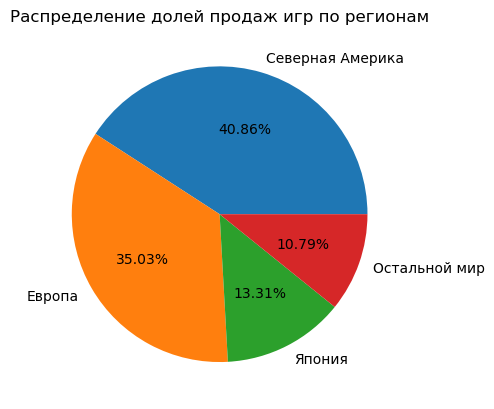

In [97]:
# Создадим "заготовку" для построения диаграммы
regions = np.array( ['Северная Америка', 'Европа', 'Япония', 'Остальной мир'] )
sales = np.array( [actual_games['na_sales'].sum(), actual_games['eu_sales'].sum(), \
                   actual_games['jp_sales'].sum(), actual_games['other_sales'].sum()])

# Создадим саму диаграмму
plt.pie( sales, labels=regions, autopct = '%.2f%%')

# зададим название
plt.title('Распределение долей продаж игр по регионам')

# Зададим размер
plt.rcParams ['figure.figsize'] = [7, 7]


# Выведем все "в сборе"
plt.show()

Стоит отметить, что регионы Северной Америки и Европы - "два кита" на рынке компьютерных игр ( и не только).

Далее на основе датафрейма actual_games будем выделять самые популярные платформы так же, как делали это ранее для всех регионов (на базе столбца "total_sales", только теперь для каждого региона (на базе столбцов продаж соответствующего региона).


Начнем с региона Северной Америки: США и Канада (столбец "na_sales").

In [98]:
# Аггрегируем по платформе и году и сохраняем результат в отдельном фрейме
na_actual_platforms = actual_games.groupby(['platform', 'year_of_release']) \
.agg({'name': ['count'], 'na_sales': ['sum']})

# Сбрасываем индекс и переименовуем столбцы
na_actual_platforms.reset_index(inplace=True)
na_actual_platforms.columns = ['platform', 'year', 'num_games', 'sum_sales']

# Аггрегируем только по платформе и сохраняем результат в отдельном фрейме
na_top_actual_platforms = na_actual_platforms.groupby(['platform']) \
.agg({'year': ['last'], 'num_games': ['sum'], 'sum_sales': ['sum']})

# Снова сбросим индекс и переименуем столбцы поудобнее
na_top_actual_platforms.reset_index(inplace=True)
na_top_actual_platforms.columns = ['platform', 'last_year', 'num_games', 'sum_sales']

# Сделаем сортировку по объему продаж
na_top_actual_platforms = na_top_actual_platforms.sort_values(by='sum_sales', ascending=False)
na_top5_actual_platforms = na_top_actual_platforms.head(5)

# Смотрим что получилось
na_top_actual_platforms

,platform,last_year,num_games,sum_sales
9,x360,2016,292,140.05
4,ps4,2016,392,108.74
3,ps3,2016,492,103.38
10,xone,2016,247,93.12
0,3ds,2016,396,55.31
8,wiiu,2016,147,38.10
2,pc,2016,249,19.12
7,wii,2016,54,17.45
6,psv,2016,411,10.98
1,ds,2013,31,4.59


Визуализируем. 

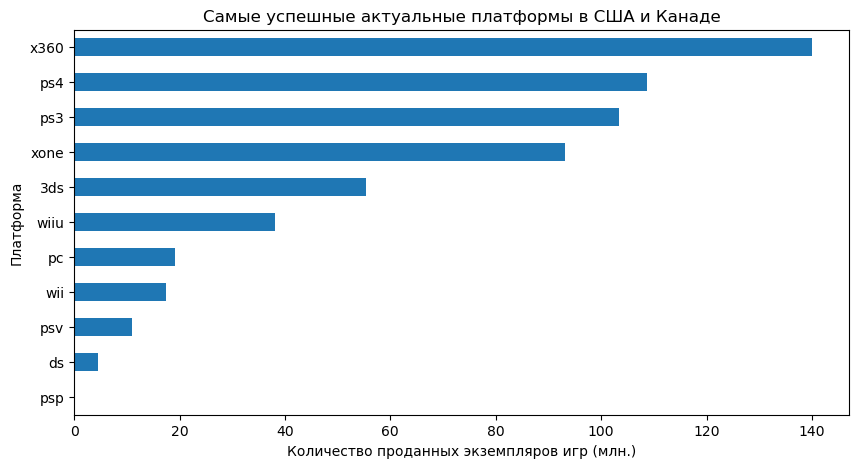

In [99]:
na_top_actual_platforms.sort_values(by='sum_sales', ascending=True). \
plot( kind = 'barh', x='platform', y= 'sum_sales', legend=False, figsize = (10,5))

plt.title('Самые успешные актуальные платформы в США и Канаде')
plt.xlabel('Количество проданных экземпляров игр (млн.)')
plt.ylabel('Платформа')

plt.show()

И посмотрим суммарные продажи для 11-ти актуальных платформ. 

In [100]:
na_top_actual_sales_sum = na_top_actual_platforms['sum_sales'].sum()
na_top5_actual_sales_sum = na_top5_actual_platforms['sum_sales'].sum()

display(na_top_actual_sales_sum)
display(na_top5_actual_sales_sum)

590.97

500.6

По NA видим следующее: 

Суммарные продажи на 11-ти актуальных платформах составили 591 миллион экземпляров игр, что составляет 40.8% от общемировых (от 1447 М).  Продажи на топ-5 платформах составили 501 миллион копий игр, то есть 42% от общемировых (1194 М).  

В топ-5 платформ, которые не закончили активность до 2016 года и которые показали самые крупные продажи игр входят те же самые платформы, что и мировом рейтинге: ps4, ps3, x360 3ds и xone.     

При этом распределение платформ по местам и соотношение объемов продаж между платформами имеет существенные отличия от гобального распределения:       
    - если в глобальном рейтинге явным лидером является платформа ps4, то в североамериканском - платформа x360, при этом процентная разница в продажах между этими платформами примерно одинаковая, но в разных направлениях (с разницей в 22-24%).     - примерно в таком же положении находятся платформы, занимающие 4 и 5 места - 3ds и xone: в мировом рейтинге 3ds на 20% больше xone, а всевероамериканском рейтинге наоборот  xone превосходит 3ds причем где-то на треть.
    - кроме того стоит отметить, что популярность платформы wii в Северной Америке существенно выше, чем в общем в мире, где она занимает 9 место (с объемом продаж в 35 М копий, что практически вдвое меньше, чем у pc), а в NA эта платформа занимает уже 8 место и ее объем продаж практически такой же, как и pc.
    
Таким образом жители Северной Америки предпочитают современные игровые платформы от американской Microsoft (x360 и xone) и японских Sony (ps3, ps4) и Nintendo (3ds).         
При этом в лидерах приставки, предназначенные для игр дома перед телевизором, а не "на бегу" в городе. Соответственно американцы и канадцы в основном предпочитают играть дома, в спокойной обстановке и на хорошем экране.
Поскольку Северная Америка составляет около 41% от общемировых, и мы видим разницу в распределении платформ, то скорее мы увидим разницу между NA и другими регионами (которые и "вытягивают" не стольпопулярные в NA платформы вверх). 

Посмотрим аналогичную раскладку по Европе (ЕС) (столбец "eu_sales").

In [101]:
# Аггрегируем по платформе и году и сохраняем результат в отдельном фрейме
eu_actual_platforms = actual_games.groupby(['platform', 'year_of_release']) \
.agg({'name': ['count'], 'eu_sales': ['sum']})

# Сбрасываем индекс и переименовуем столбцы
eu_actual_platforms.reset_index(inplace=True)
eu_actual_platforms.columns = ['platform', 'year', 'num_games', 'sum_sales']

# Аггрегируем только по платформе и сохраняем результат в отдельном фрейме
eu_top_actual_platforms = eu_actual_platforms.groupby(['platform']) \
.agg({'year': ['last'], 'num_games': ['sum'], 'sum_sales': ['sum']})

# Снова сбросим индекс и переименуем столбцы поудобнее
eu_top_actual_platforms.reset_index(inplace=True)
eu_top_actual_platforms.columns = ['platform', 'last_year', 'num_games', 'sum_sales']

# Сделаем сортировку по объему продаж
eu_top_actual_platforms = eu_top_actual_platforms.sort_values(by='sum_sales', ascending=False)
eu_top5_actual_platforms = eu_top_actual_platforms.head(5)

# Смотрим что получилось
eu_top_actual_platforms

,platform,last_year,num_games,sum_sales
4,ps4,2016,392,141.09
3,ps3,2016,492,106.85
9,x360,2016,292,74.52
10,xone,2016,247,51.59
0,3ds,2016,396,42.64
2,pc,2016,249,37.70
8,wiiu,2016,147,25.13
7,wii,2016,54,11.92
6,psv,2016,411,11.36
1,ds,2013,31,3.53


Визуализируем. 

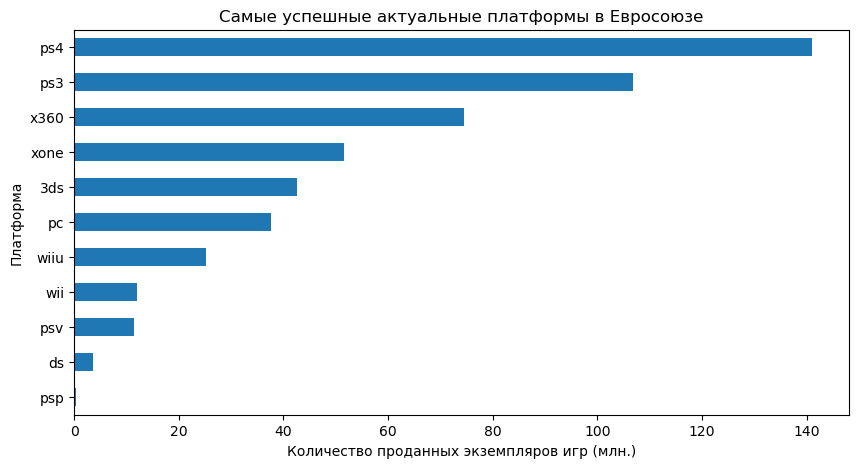

In [102]:
eu_top_actual_platforms.sort_values(by='sum_sales', ascending=True). \
plot( kind = 'barh', x='platform', y= 'sum_sales', legend=False, figsize = (10,5))

plt.title('Самые успешные актуальные платформы в Евросоюзе')
plt.xlabel('Количество проданных экземпляров игр (млн.)')
plt.ylabel('Платформа')

plt.show()

И посмотрим суммарные продажи для 11-ти актуальных платформ. 

In [103]:
eu_top_actual_sales_sum = eu_top_actual_platforms['sum_sales'].sum()
eu_top5_actual_sales_sum = eu_top5_actual_platforms['sum_sales'].sum()

display(eu_top_actual_sales_sum)
display(eu_top5_actual_sales_sum)

506.74999999999994

416.68999999999994

По EU видим следующее: 

Суммарные продажи на 11-ти актуальных платформах составили в Европе 507 миллион экземпляров игр, что несколько ниже (на 14.2%), чем в США и Канаде (там 591 М) составляет 35.0% от общемировых (от 1447 М). Для представителей платформ из топ-5 продажи равны 417 миллионов копий, что составляет 35% от мировых и на 17% меньше, чем в Северной Америке.

В топ-5 платформ входят те же самые платформы, что и в Северной Америке и мировом рейтинге: ps4, ps3, x360 3ds и xone.     

При этом распределение платформ по местам и соотношение продаж между платформами в EU похоже на общемировой рейтинг в верхней части и скорее ближе к американском - в нижней части. По сравнению с общемировым рейтингом есть следующие отличия:     - так же, как и для Северной Америки популярность платформы xone выше популярности 3ds (не на треть как в Америке, но где-то на 20%).
    - как и в Америке популярность платформы wii в выше, чем в общем в мире: в Европе эта платформа занимает 8 место, хотя в отличие от Америки ее продажи существенно отстают от продаж игр на pc.
    - кроме того стоит отметить, что pc является в EU более популярной платформой, чем в NA: объемы продаж отличаются практически вдвое. Абсолютно обратная ситуация в платформой wiiu - для нее продажи в NA  в полтора раза выше, чем в EU.
    
В общем похоже, что с точки зрения предпочтений жителей в части игровых платформ Европа представляет из себя нечто среднее, между Америкой и остальным миром, но больше все-таки склоняясь к Америке. 

Теперь проделаем то же для Японии (столбец "jp_sales").

In [104]:
# Аггрегируем по платформе и году и сохраняем результат в отдельном фрейме
jp_actual_platforms = actual_games.groupby(['platform', 'year_of_release']) \
.agg({'name': ['count'], 'jp_sales': ['sum']})

# Сбрасываем индекс и переименовуем столбцы
jp_actual_platforms.reset_index(inplace=True)
jp_actual_platforms.columns = ['platform', 'year', 'num_games', 'sum_sales']

# Аггрегируем только по платформе и сохраняем результат в отдельном фрейме
jp_top_actual_platforms = jp_actual_platforms.groupby(['platform']) \
.agg({'year': ['last'], 'num_games': ['sum'], 'sum_sales': ['sum']})

# Снова сбросим индекс и переименуем столбцы поудобнее
jp_top_actual_platforms.reset_index(inplace=True)
jp_top_actual_platforms.columns = ['platform', 'last_year', 'num_games', 'sum_sales']

# Сделаем сортировку по объему продаж
jp_top_actual_platforms = jp_top_actual_platforms.sort_values(by='sum_sales', ascending=False)
jp_top5_actual_platforms = jp_top_actual_platforms.head(5)

# Смотрим что получилось
jp_top_actual_platforms

,platform,last_year,num_games,sum_sales
0,3ds,2016,396,87.79
3,ps3,2016,492,35.29
6,psv,2016,411,21.04
4,ps4,2016,392,15.96
8,wiiu,2016,147,13.01
5,psp,2015,173,10.47
1,ds,2013,31,3.72
7,wii,2016,54,3.39
9,x360,2016,292,1.57
10,xone,2016,247,0.34


Визуализируем. 

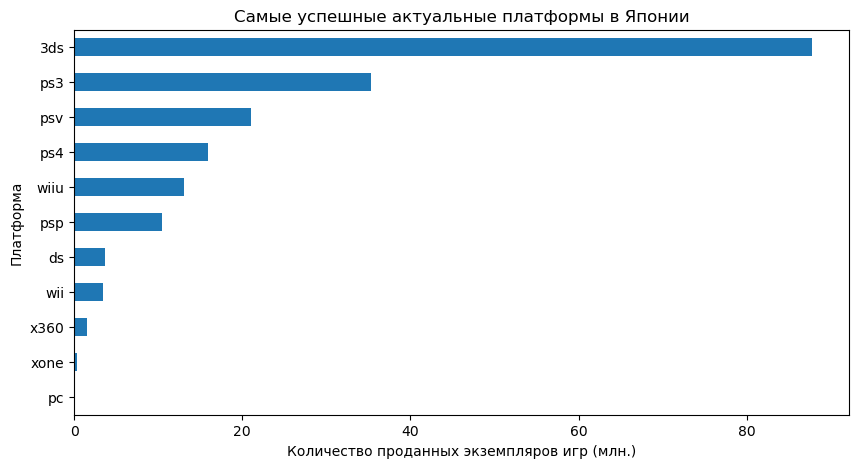

In [105]:
jp_top_actual_platforms.sort_values(by='sum_sales', ascending=True). \
plot( kind = 'barh', x='platform', y= 'sum_sales', legend=False, figsize = (10,5))

plt.title('Самые успешные актуальные платформы в Японии')
plt.xlabel('Количество проданных экземпляров игр (млн.)')
plt.ylabel('Платформа')

plt.show()

И посмотрим суммарные продажи для актуальных платформ. 

In [106]:
jp_top_actual_sales_sum = jp_top_actual_platforms['sum_sales'].sum()
jp_top5_actual_sales_sum = jp_top5_actual_platforms['sum_sales'].sum()

display(jp_top_actual_sales_sum)
display(jp_top5_actual_sales_sum)

192.58

173.09

По JP видим следующее: 

Суммарные продажи в Японии составили 193 миллиона экземпляров игр ( 173 миллиона - для платформ топ-5), что составляет 13% от общемировых продаж, 38% от европейских продаж и 33% - от североамериканских (для топ-5 - это показатель составляет 15% от мировых, 42% от европейских и 35% - от североамериканских.

Этот рынок кардинально отличается от европейского и североамериканского.

В топ-5 платформ уже не входят платформы те же самые платформы x360 и xone, их места в пятерке заняли psv с объемом продаж 21 миллион экземпляров (то есть 11% от всех продаж против 2% например в Европе) и wiiu  с объемом продаж в 13 миллионов ( 7% от всего объема против 5 в Европе). 

Остальные три платформы - лидеры мирового рейтинга ps4, ps3 и 3ds так-же присутствуют в топе японского рейтинга. Однако распределение платформ по местам (и соответственно - долям в общей массе продаж по рынку) существенно отличаются от уже рассмотренных:
    - в то время, как в Америке ps4 и ps3 от Сони довольно близко следуют за х360, составляя от ее объемов 78% и 73% соответственно, а в Европе эти платформы уверенно занимают первые места - в Японии продажи ps4 и ps3 не превышают 18% и 40% от лидера соответственно;
    - а вот 3ds от Nintendo уверенно лидироует в Японии с объемом продаж в 88 миллионов копий, больше чем в два раза превосходя ближайшего конкурента;
    - интересными фактами так-же являются следующие:
        - в топ-5 японского рейтинга ps3 пратктически вдвое опережает продажи своего последователя - ps4;
        - pc как платформа для игр находится на последнем месте с ищезающе малым по сравнению с лидерами объемом продаж.

Таким образом мы можем сделать несколько заключений относительно предпочтений жителей Японии в отношении компьютерных игр:
1. Судя по тому, что лидирует в рейтингке со значительным отрывом портативная игровая консоль x360 и кроме нее в топ-5 рейтинга входит такая-же портативная платформа psv (она же psp2) и их суммарные продажи превосходят все остальные платформы вместе взятые - можно предположить что в подавляющем большинстве японцы предпочитают играть не сидя за компьютером или перед телевизором, а в движении и "между делом": в дороге, на улице, в транспорте и т.д.
2. Насколько мы знаем в Японии уровень зарплат вполне сопоставим с Американским и Западноевропейским. Тем не менее мы видим, что японцы не только покупают более дешевые мобильные платформы, но и не спешат "гнаться" за последними новинками (судя по тому, что продажи на платформе ps3 превышают продажи на ps4 больше чем в два раза). То есть по крайней мере с точки зрения выбора игровых платформ японцы проявляют изрядную долю консерватизма.

Ну и наконец посмотрим на весь остальной мир. (столбец "other_sales").

In [107]:
# Аггрегируем по платформе и году и сохраняем результат в отдельном фрейме
rw_actual_platforms = actual_games.groupby(['platform', 'year_of_release']) \
.agg({'name': ['count'], 'other_sales': ['sum']})

# Сбрасываем индекс и переименовуем столбцы
rw_actual_platforms.reset_index(inplace=True)
rw_actual_platforms.columns = ['platform', 'year', 'num_games', 'sum_sales']

# Аггрегируем только по платформе и сохраняем результат в отдельном фрейме
rw_top_actual_platforms = rw_actual_platforms.groupby(['platform']) \
.agg({'year': ['last'], 'num_games': ['sum'], 'sum_sales': ['sum']})

# Снова сбросим индекс и переименуем столбцы поудобнее
rw_top_actual_platforms.reset_index(inplace=True)
rw_top_actual_platforms.columns = ['platform', 'last_year', 'num_games', 'sum_sales']

# Сделаем сортировку по объему продаж
rw_top_actual_platforms = rw_top_actual_platforms.sort_values(by='sum_sales', ascending=False)
rw_top5_actual_platforms = rw_top_actual_platforms.head(5)

# Смотрим что получилось
rw_top_actual_platforms

,platform,last_year,num_games,sum_sales
4,ps4,2016,392,48.35
3,ps3,2016,492,43.26
9,x360,2016,292,20.40
10,xone,2016,247,14.27
0,3ds,2016,396,8.87
8,wiiu,2016,147,5.95
6,psv,2016,411,5.80
2,pc,2016,249,5.75
7,wii,2016,54,2.61
1,ds,2013,31,0.71


Визуализируем. 

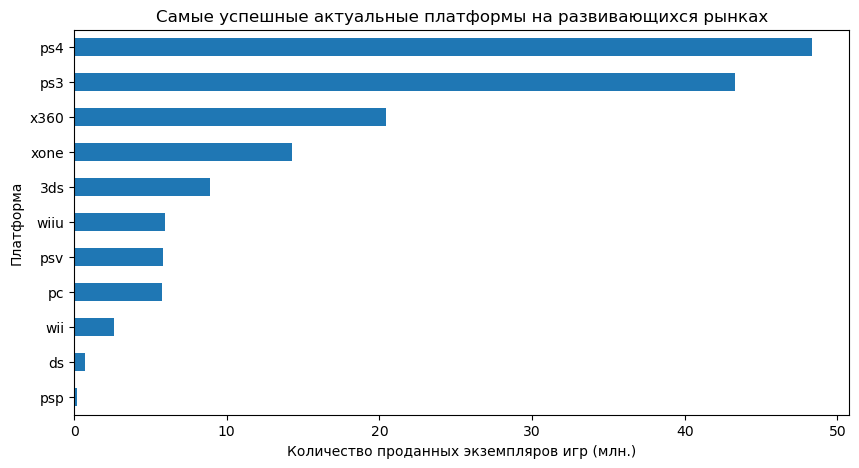

In [108]:
rw_top_actual_platforms.sort_values(by='sum_sales', ascending=True). \
plot( kind = 'barh', x='platform', y= 'sum_sales', legend=False, figsize = (10,5))

plt.title('Самые успешные актуальные платформы на развивающихся рынках')
plt.xlabel('Количество проданных экземпляров игр (млн.)')
plt.ylabel('Платформа')

plt.show()

И посмотрим суммарные продажи на остальных мировых рынках для 11-ти актуальных платформ. 

In [109]:
rw_top_actual_sales_sum = rw_top_actual_platforms['sum_sales'].sum()
rw_top5_actual_sales_sum = rw_top5_actual_platforms['sum_sales'].sum()

display(rw_top_actual_sales_sum)
display(rw_top5_actual_sales_sum)

156.14000000000001

135.15

По Other видим следующее: 

Суммарные продажи на развивающихся рынках (Китай, Индия, Россия, Азия, Африка, Латинская Америка) составили 156 миллионов экземпляров игр, что составляет 11% от общемировых продаж. Из них продажи для топ-5 плтформ составляют 135 миллионов.

Эти рынки наверняка имеют какие-то свои особенности каждый, однако агрегированно очень напоминают Европейский рынок (который как мы предположили ранее является чем-то средним между Северной Америкой и остальным миром).   

В топ-5 платформ входят те же платформы, что и в Европе: ps4, ps3, x360 3ds и xone. 

При этом распределение платформ по местам и соотношение продаж между платформами так-же очень похоже на европейский рынок, с той только разницей, что "преимущество" лидирующих платформ ps4 и ps3 по отношению к остальным платформам более  весомо.

Таким образом на развивающихся рынках (как и в Европе и как и в Америке) люди больше предпочитают играть дома перед телевизором, чем не "на бегу" в городе. Для этого выбирают платформы те же, что выбирают американцы или европейцы, отдавая чуть больше предпочтерия продукции фирмы Сони, возможно просто обладающей большей узнаваемостью на этих рынках.

Попробуем еще визуализировать это распределение долей разных платформ для всех регионов на одном графике.      
Поскольку все выводы мы уже сделали - эта визуализация нам не нужна по сути, однако она может быть полезна для презентации заказчику, чтобы не загружать ее предыдущей серией графикаов, а показать все в одном. 

Создадим "заготовку" для графика

In [110]:
# Создадим небольшой датафрейм, столбцы которого будем выводить на график
top_actual_platforms_for_print = pd.DataFrame(columns=['platform', 'na_sales', 'eu_sales', 'jp_sales', 'rw_sales','total_sales', \
                                                        'na_shares', 'eu_shares', 'jp_shares', 'rw_shares', 'total_shares'])

# Наполним данными

top_actual_platforms_for_print[['platform', 'total_sales']] = top_actual_platforms[['platform', 'sum_sales']]

for platform in top_actual_platforms_for_print['platform']:
    # Америка
    top_actual_platforms_for_print.loc[top_actual_platforms_for_print['platform'] == platform,'na_sales'] = \
    na_top_actual_platforms.loc[na_top_actual_platforms['platform'] == platform, 'sum_sales']
    # Европа
    top_actual_platforms_for_print.loc[top_actual_platforms_for_print['platform'] == platform,'eu_sales'] = \
    eu_top_actual_platforms.loc[eu_top_actual_platforms['platform'] == platform, 'sum_sales']
    # Япония
    top_actual_platforms_for_print.loc[top_actual_platforms_for_print['platform'] == platform,'jp_sales'] = \
    jp_top_actual_platforms.loc[jp_top_actual_platforms['platform'] == platform, 'sum_sales']
    # Остальной мир
    top_actual_platforms_for_print.loc[top_actual_platforms_for_print['platform'] == platform,'rw_sales'] = \
    rw_top_actual_platforms.loc[rw_top_actual_platforms['platform'] == platform, 'sum_sales']

top_actual_platforms_for_print[['na_shares', 'eu_shares', 'jp_shares', 'rw_shares', 'total_shares']] = \
top_actual_platforms_for_print[['na_sales', 'eu_sales', 'jp_sales', 'rw_sales','total_sales']] / \
top_actual_platforms_for_print[['na_sales', 'eu_sales', 'jp_sales', 'rw_sales', 'total_sales']].sum()    

# Смотрим что получилось    
top_actual_platforms_for_print

,platform,na_sales,eu_sales,jp_sales,rw_sales,total_sales,na_shares,eu_shares,jp_shares,rw_shares,total_shares
4,ps4,108.74,141.09,15.96,48.35,314.14,0.184003,0.278421,0.082875,0.309658,0.217181
3,ps3,103.38,106.85,35.29,43.26,288.78,0.174933,0.210853,0.183249,0.277059,0.199649
9,x360,140.05,74.52,1.57,20.4,236.54,0.236983,0.147055,0.008152,0.130652,0.163533
0,3ds,55.31,42.64,87.79,8.87,194.61,0.093592,0.084144,0.455862,0.056808,0.134544
10,xone,93.12,51.59,0.34,14.27,159.32,0.157571,0.101806,0.001766,0.091392,0.110146
8,wiiu,38.1,25.13,13.01,5.95,82.19,0.06447,0.049591,0.067556,0.038107,0.056822
2,pc,19.12,37.7,0.0,5.75,62.57,0.032354,0.074396,0.0,0.036826,0.043258
6,psv,10.98,11.36,21.04,5.8,49.18,0.01858,0.022417,0.109253,0.037146,0.034001
7,wii,17.45,11.92,3.39,2.61,35.37,0.029528,0.023522,0.017603,0.016716,0.024453
1,ds,4.59,3.53,3.72,0.71,12.55,0.007767,0.006966,0.019317,0.004547,0.008676


Построим график распределения продаж ...

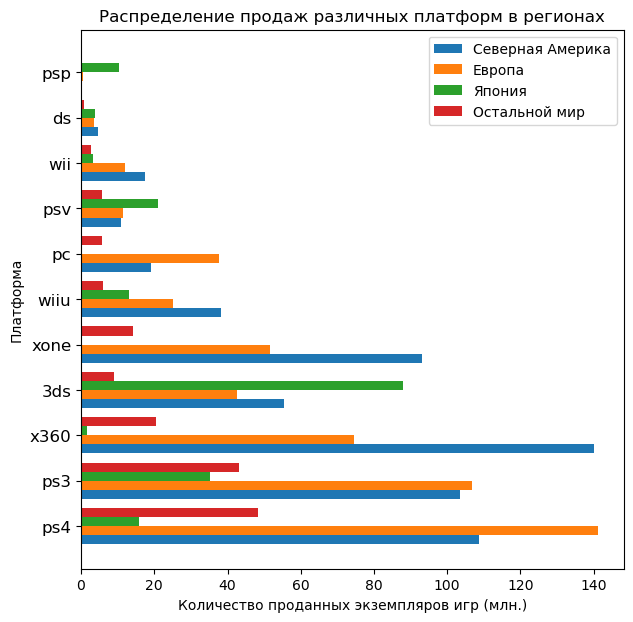

In [111]:
# Платформ у нас 11, поэтому серий будет 11
x = np.arange(11)

# Регионов у нас 4, поэтому "столбцов" в серии будет 4, но чтобы их немного "раздвинуть" возьмем ширину равной 5
bw = 1/5

# Зададим данные для графика
y_na = top_actual_platforms_for_print['na_sales']
y_eu = top_actual_platforms_for_print['eu_sales']
y_jp = top_actual_platforms_for_print['jp_sales']
y_rw = top_actual_platforms_for_print['rw_sales']

# Создадим собственно графики
plt.barh(x, y_na, bw, label='Северная Америка')
plt.barh(x+1*bw, y_eu, bw, label='Европа')
plt.barh(x+2*bw, y_jp, bw, label='Япония')
plt.barh(x+3*bw, y_rw, bw, label='Остальной мир')

# Подпишем оси и графики
plt.yticks(x+1.5*bw, top_actual_platforms_for_print['platform'], fontsize=12)

plt.xlabel('Количество проданных экземпляров игр (млн.)')
plt.ylabel('Платформа')
plt.title('Распределение продаж различных платформ в регионах')

# Включим легенду
plt.legend()

# Зададим размер
plt.rcParams ['figure.figsize'] = [10, 10]

# Выведем график
plt.show()


... и график распределения долей различных платформ по регионам.

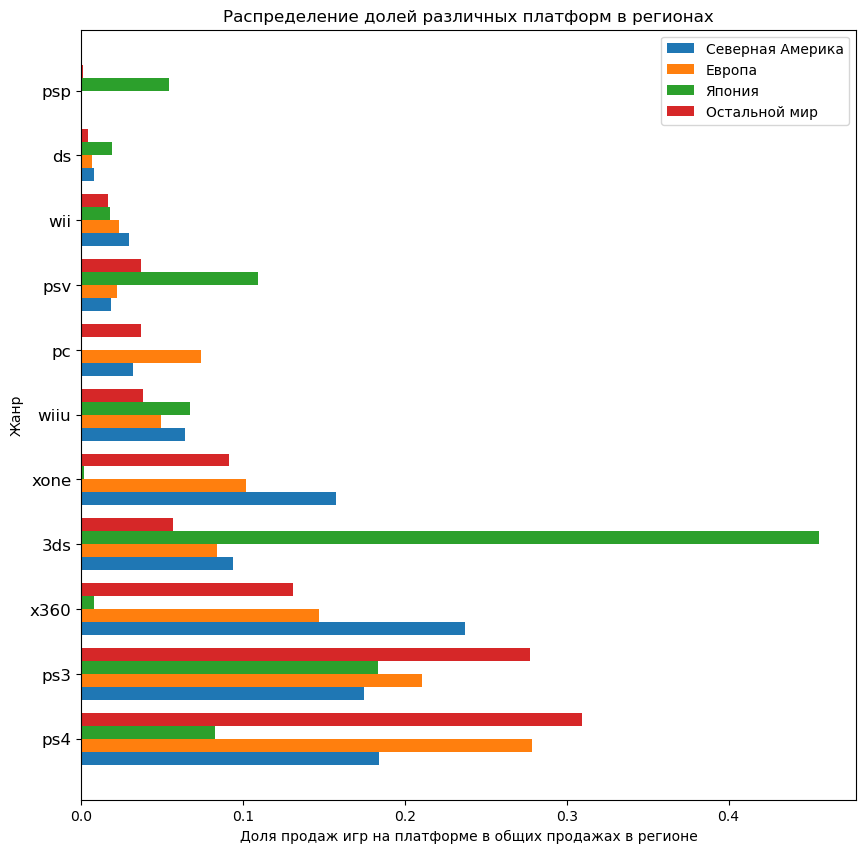

In [112]:
# Платформ у нас 11, поэтому серий будет 11
x = np.arange(11)

# Регионов у нас 4, поэтому "столбцов" в серии будет 4, но чтобы их немного "раздвинуть" возьмем ширину равной 5
bw = 1/5

# Зададим данные для графика
y_na = top_actual_platforms_for_print['na_shares']
y_eu = top_actual_platforms_for_print['eu_shares']
y_jp = top_actual_platforms_for_print['jp_shares']
y_rw = top_actual_platforms_for_print['rw_shares']

# Создадим собственно графики
plt.barh(x, y_na, bw, label='Северная Америка')
plt.barh(x+1*bw, y_eu, bw, label='Европа')
plt.barh(x+2*bw, y_jp, bw, label='Япония')
plt.barh(x+3*bw, y_rw, bw, label='Остальной мир')

# Подпишем оси и графики
plt.yticks(x+1.5*bw, top_actual_platforms_for_print['platform'], fontsize=12)

plt.xlabel('Доля продаж игр на платформе в общих продажах в регионе')
plt.ylabel('Жанр')
plt.title('Распределение долей различных платформ в регионах')

# Включим легенду
plt.legend()

# Зададим размер
plt.rcParams ['figure.figsize'] = [10, 10]

# Выведем график
plt.show()


### Определить для пользователя каждого региона (NA, EU, JP)  самые популярные жанры (топ-5). Пояснить разницу.

С жанрами поступим так же, как и с платформами:

Будем анализировать игры, представленные на 11 "живых" платформах.     

Будем проводить анализ для тех же 4-х регионов:     
США и Канада (столбец "na_sales"),       
Европа = Евросоюз (столбец "eu_sales"),       
Япония (столбец "jp_sales"),
и развивающиеся рынки или весь остальной мир (столбец "other_sales").

Чтобы не терять полноты картины будем выводить не только топ-5, но все жанры, представленные на платформах (а ка мы уже замечали ранее их всего 12), уделяя основное внимание верхней части при формулировании выводов.

На основе датафрейма actual_games выделим и проанализируем самые популярные жанры так же, как делали это ранее для всех регионов создав и проанализировав датафрейм actual_genres, только теперь для каждого региона отдельно.

Начнем с региона Северной Америки: США и Канада (столбец "na_sales").

In [113]:
# Аггрегируем по жанру и году и сохраняем результат в отдельном фрейме
na_actual_genres = actual_games.groupby(['genre', 'year_of_release']) \
.agg({'name': ['count'], 'na_sales': ['sum']})

# Сбрасываем индекс и переименовуем столбцы
na_actual_genres.reset_index(inplace=True)
na_actual_genres.columns = ['genre', 'year', 'num_games', 'sum_sales']

# Аггрегируем только по жанру и сохраняем результат в отдельном фрейме
na_top_actual_genres = na_actual_genres.groupby(['genre']) \
.agg({'year': ['last'], 'num_games': ['sum'], 'sum_sales': ['sum']})

# Снова сбросим индекс и переименуем столбцы поудобнее
na_top_actual_genres.reset_index(inplace=True)
na_top_actual_genres.columns = ['genre', 'last_year', 'num_games', 'sum_sales']

# Сделаем сортировку по объему продаж и выделим топ-5
na_top_actual_genres = na_top_actual_genres.sort_values(by='sum_sales', ascending=False)
na_top5_actual_genres = na_top_actual_genres.head(5)

# Смотрим что получилось
na_top_actual_genres
#na_top5_actual_genres

,genre,last_year,num_games,sum_sales
0,action,2016,1031,177.84
8,shooter,2016,235,144.77
10,sports,2016,267,81.53
7,role_playing,2016,370,64.00
3,misc,2016,192,38.19
4,platform,2016,85,25.38
2,fighting,2016,109,19.79
6,racing,2016,114,17.22
1,adventure,2016,302,8.92
9,simulation,2016,80,7.97


Визуализируем. 

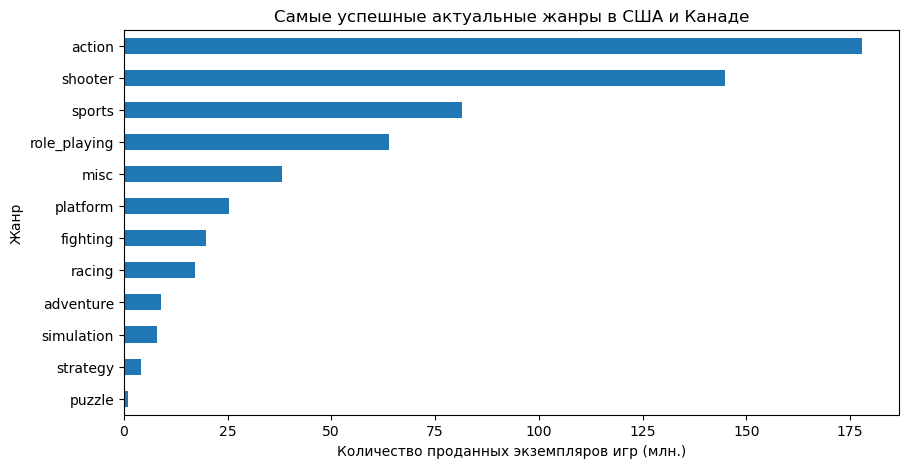

In [114]:
na_top_actual_genres.sort_values(by='sum_sales', ascending=True). \
plot( kind = 'barh', x= 'genre', y= 'sum_sales', legend=False, figsize = (10,5))

plt.title('Самые успешные актуальные жанры в США и Канаде')
plt.xlabel('Количество проданных экземпляров игр (млн.)')
plt.ylabel('Жанр')

plt.show()

И посмотрим суммарные продажи для актуальных жанров. 

In [115]:
na_top_actual_genres_sum = na_top_actual_genres['sum_sales'].sum()
na_top5_actual_genres_sum = na_top5_actual_genres['sum_sales'].sum()

display(na_top_actual_genres_sum)
display(na_top5_actual_genres_sum)

590.97

506.33

Как мы отмечали ранее в мировом масштабе     
игры, которые продавались за поледние 5 лет представлены в 12 жанрах. Суммарные продажи составляют 591 миллион экземпляров игр, продажи топ-5 = 506 миллионов копий игр.   

Явный лидер продаж -  жанр action с 1033 играми в этом жанре и 441 миллионом проданных копий этих игр;
в топ-5 входят жанры: "action", "shooter", "role-playing", "sports" и "misc".

По NA видим следующее: 

На рынке США и Канады представлены все 12 жанров.

При этом в топ-5 есть ряд отличий:
    - вместо одного явоного лидера рейтинга видим два жанра-лидера: жанр action с 178 миллионом проданных копий игр и             приближающийся к нему жанр shooter с 145 миллионами проданных копий. Напару эти два жанра дают 55% от общего объема         продаж в регионе и 64% от продаж жанров из топ-5;
    - их ближайший преследователь - это не жанр role-playing, находящийся на третьем месте в мировом рейтинге, а жанр             sports. Однако объем его продаж сосавляет 82 миллиона экземпляров, то есть 14% от всех продаж, 16% от продаж жанров         топ-5, 46% от лидера и 57% от второго места;
    - таким образом жанр role-playing переместился на червертое место с 64 миллионами продаж ( 11% от овсех продаж, 13% от       продаж жанров топ-5 и 36% от лидера);
    - замыкает пятерку лидеров жанр misc, который уступает вышестоящему жанру role-playing 41% , составляя 6.4% от овсех         продаж и 7.5% от суммарных продаж топ-5; в то же самое время он в полтора раза опережает "преследующий его" жанр           platform (на 13 М проданных копий).
    
В "нижней части" рейтинга ситуация похожа на общемировую:     
    - 5 жанров, следующие за топ-5 представляют собой "болото" с суммарными объемами продаж этой группы 79 миллионов             проданных экземпляров игр, что меньше, чем объем продаж жанра sports, находящегося на третьем месте и составляет лишь       44% от продаж лидера рейтинга - жанра action;
    - как и в мировом рейтинге, явные аутсайдера - это жанры strategy с 4 миллионами проданных копий и puzzle c  1 млн.
        
Таким образом жители Северной Америки оказались "типичными представительями мировой цивилизации" с точки зрения своих предпочтений по жанрам игр, отдав предпочтения жанрам action и shooter, однако в отличие от других регионов поставив жанр sport на почетное третье место. 

Посмотрим аналогичную раскладку по Европе (ЕС) (столбец "eu_sales").

In [116]:
# Аггрегируем по жанру и году и сохраняем результат в отдельном фрейме
eu_actual_genres = actual_games.groupby(['genre', 'year_of_release']) \
.agg({'name': ['count'], 'eu_sales': ['sum']})

# Сбрасываем индекс и переименовуем столбцы
eu_actual_genres.reset_index(inplace=True)
eu_actual_genres.columns = ['genre', 'year', 'num_games', 'sum_sales']

# Аггрегируем только по жанру и сохраняем результат в отдельном фрейме
eu_top_actual_genres = eu_actual_genres.groupby(['genre']) \
.agg({'year': ['last'], 'num_games': ['sum'], 'sum_sales': ['sum']})

# Снова сбросим индекс и переименуем столбцы поудобнее
eu_top_actual_genres.reset_index(inplace=True)
eu_top_actual_genres.columns = ['genre', 'last_year', 'num_games', 'sum_sales']

# Сделаем сортировку по объему продаж и выделим топ-5
eu_top_actual_genres = eu_top_actual_genres.sort_values(by='sum_sales', ascending=False)
eu_top5_actual_genres = eu_top_actual_genres.head(5)

# Смотрим что получилось
eu_top_actual_genres
#eu_top5_actual_genres

,genre,last_year,num_games,sum_sales
0,action,2016,1031,159.34
8,shooter,2016,235,113.47
10,sports,2016,267,69.08
7,role_playing,2016,370,48.53
6,racing,2016,114,27.23
3,misc,2016,192,26.32
4,platform,2016,85,21.41
9,simulation,2016,80,14.55
2,fighting,2016,109,10.79
1,adventure,2016,302,9.46


Визуализируем. 

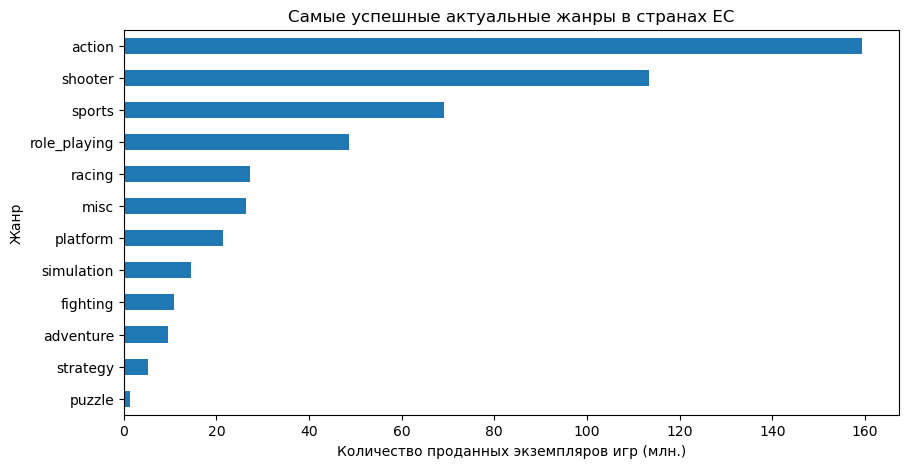

In [117]:
eu_top_actual_genres.sort_values(by='sum_sales', ascending=True). \
plot( kind = 'barh', x= 'genre', y= 'sum_sales', legend=False, figsize = (10,5))

plt.title('Самые успешные актуальные жанры в странах ЕС')
plt.xlabel('Количество проданных экземпляров игр (млн.)')
plt.ylabel('Жанр')

plt.show()

И посмотрим суммарные продажи для актуальных жанров. 

In [118]:
eu_top_actual_genres_sum = eu_top_actual_genres['sum_sales'].sum()
eu_top5_actual_genres_sum = eu_top5_actual_genres['sum_sales'].sum()

display(eu_top_actual_genres_sum)
display(eu_top5_actual_genres_sum)

506.75

417.65

По EU видим следующее:

На рынке Европы ситуция жанровых предпочтений жителей - очень похожа на Северную Америку.      
На рынке представлены все 12 жанров. Суммарные продажи составляют 507 миллионов экземпляров игр, продажи топ-5 = 418 миллионов копий игр.

При этом в топ-5 есть два более-менее значимых отличия:
    - у европейских геймеров несколько ниже популярность жанра shooter. Оставаясь вторым в рейтинге в Европе этот жанр           занимает только 27% от продаж жанров топ-5 по сравнению с 29% для США и Канады. При этом это небольшое снижение             популярности шутеров произошло за счет несколько большей популярности жанра action (на 3%) и жанра sports (на 1%);   
    - в топ-5 попал жанр racing с 27 миллионами проданных экземпляров, что составляет 5% от всех продаж, 6.5% от продаж           жанров топ-5 и 17% от лидера. Этот жанр "вытеснил" жанр misc, который с показателем 26 миллионов продаж опустился на       6-е место.
В остальном распределение объемов продаж игр по жанрам очень похоже на аналогичные показатели для Северной Америки.

Переместимся на дальний восток и посмотрим на распределение по жанрам в Японии (столбец "jp_sales").

In [119]:
# Аггрегируем по жанру и году и сохраняем результат в отдельном фрейме
jp_actual_genres = actual_games.groupby(['genre', 'year_of_release']) \
.agg({'name': ['count'], 'jp_sales': ['sum']})

# Сбрасываем индекс и переименовуем столбцы
jp_actual_genres.reset_index(inplace=True)
jp_actual_genres.columns = ['genre', 'year', 'num_games', 'sum_sales']

# Аггрегируем только по жанру и сохраняем результат в отдельном фрейме
jp_top_actual_genres = jp_actual_genres.groupby(['genre']) \
.agg({'year': ['last'], 'num_games': ['sum'], 'sum_sales': ['sum']})

# Снова сбросим индекс и переименуем столбцы поудобнее
jp_top_actual_genres.reset_index(inplace=True)
jp_top_actual_genres.columns = ['genre', 'last_year', 'num_games', 'sum_sales']

# Сделаем сортировку по объему продаж и выделим топ-5
jp_top_actual_genres = jp_top_actual_genres.sort_values(by='sum_sales', ascending=False)
jp_top5_actual_genres = jp_top_actual_genres.head(5)

# Смотрим что получилось
jp_top_actual_genres
#jp_top5_actual_genres

,genre,last_year,num_games,sum_sales
7,role_playing,2016,370,65.44
0,action,2016,1031,52.80
3,misc,2016,192,12.86
9,simulation,2016,80,10.41
2,fighting,2016,109,9.44
8,shooter,2016,235,9.23
4,platform,2016,85,8.63
1,adventure,2016,302,8.24
10,sports,2016,267,8.01
11,strategy,2016,71,2.88


Визуализируем. 

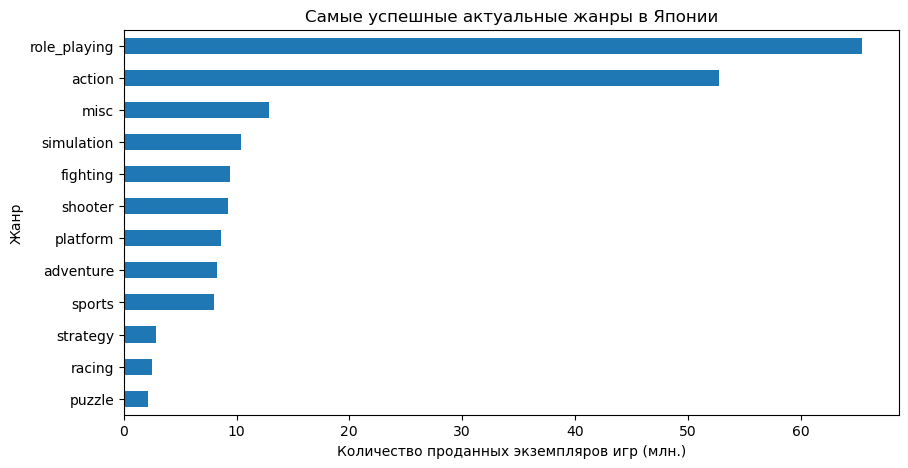

In [120]:
jp_top_actual_genres.sort_values(by='sum_sales', ascending=True). \
plot( kind = 'barh', x= 'genre', y= 'sum_sales', legend=False, figsize = (10,5))

plt.title('Самые успешные актуальные жанры в Японии')
plt.xlabel('Количество проданных экземпляров игр (млн.)')
plt.ylabel('Жанр')

plt.show()

И посмотрим суммарные продажи для актуальных жанров. 

In [121]:
jp_top_actual_genres_sum = jp_top_actual_genres['sum_sales'].sum()
jp_top5_actual_genres_sum = jp_top5_actual_genres['sum_sales'].sum()

display(jp_top_actual_genres_sum)
display(jp_top5_actual_genres_sum)

192.57999999999998

150.95

По JP видим следующее: 

На рынке Японии представлены все 12 жанров. Суммарные продажи составляют 193 миллиона экземпляров игр, продажи топ-5 = 151 миллион копий игр.

При этом как и в случае с предпочтениями по платформам мы видим, что предпочтения японцев в части жанров игр кардинально отличаются от предпочтений американцев и европейцев.

Основные отличия следующие:
    - вместо явного лидера рейтинга жанра action (в Европе он превосходил преследователя на 40%, в Америке - на 23%) видим       два жанра-лидера:            
        -- лидирующий жанр жанр role-playing ( в Европе и в Америке находящийся только на 4-м месте) с 65 миллионами                   проданных копий ( что составляет 34% от всех продаж, 43% от продаж жанров топ-5) и               
        -- находящийся только на втором месте жанр action с 53 миллионами проданных копий (что составляет 27.5% от всех               продаж, 35% от продаж жанров топ-5 и 23% отставания от лидера);              
    - в топ-5 помимо жанров - лидеров role-playing (1-е место) и action (2-е) формально входят так-же жанры misc (3-е),           simulation (4-е) и fighting (5-е место). Однако по сути их тяжело отнести к топ-5, скорее они относятся с серединке         рейтинга - к 7-ми жанрам, следующим за двумя лидерами )то есть жанры с 3-го по 9-е место), которые имеют значительно       меньший объем продаж:          
        -- даже идущий на 3-м месте жанр misc имеет всего 13 миллионов проданных копий, что составляет менее 7% от всех               продаж, менее 9% от продаж жанров топ-5 и насчитывает в 4 раза меньше проданных игр, чем жанр actions, идущий на           втором месте (не говоря уже о лидере);          
        -- объемы продаж в жанрах с 3-го по 9-й распределены довольно ровно с незначительным снижением: жанр sports,                 находящийся на 9-м месте (в отличие от Европы и Америки, где этот жанр с запасом на третьем месте) имеет 8                 миллионов проданных копий, (то есть около 4% от всех продаж, чуть более 5% от продаж жанров топ-5) и отстает от             идущего на 4-м месте жанра simulation ( а этот жанр на 8-м месте в Европе и аж на 10-м в Америке) составляет               всего 2.4 миллиона игр или 30%.             
     - явными аутсайдерами как и на рынке Европы и Америки являются жанры strategy и puzzle, однако и здесь есть особенность: на предпоследнем 11-м месте (как раз между этими аутсайдерами) находится жанр racing, который на американском рынке занимет 8-е место, а в Европе - и вовсе 5-е.                
     - стоит так-же отметить, что жанр shooter - один из лидеров и американского и европейского рынков ( уверенное второе место и там и там) на рынке Японии занимает только 6-е место с очень скромными показателями ( 9 М проданных игр или менее 5% от суммарных продаж). 
        
Таким образом предпочтения жителей Японии относительно жанров игр столь же отличаются от предпочтений европейцев и американцев, как и в части игровых платформ. По всей видимости это связано и с отличием в стиле жизни (пребывание "на людях" и соответственно - большее использование мобильных платформ), так и с национальными особенностями характера (например существенно меньшее "приятие" шутеров).

Ну и осталось посмотреть на развивающиеся рынки (столбец "other_sales").

In [122]:
# Аггрегируем по жанру и году и сохраняем результат в отдельном фрейме
rw_actual_genres = actual_games.groupby(['genre', 'year_of_release']) \
.agg({'name': ['count'], 'other_sales': ['sum']})

# Сбрасываем индекс и переименовуем столбцы
rw_actual_genres.reset_index(inplace=True)
rw_actual_genres.columns = ['genre', 'year', 'num_games', 'sum_sales']

# Аггрегируем только по жанру и сохраняем результат в отдельном фрейме
rw_top_actual_genres = rw_actual_genres.groupby(['genre']) \
.agg({'year': ['last'], 'num_games': ['sum'], 'sum_sales': ['sum']})

# Снова сбросим индекс и переименуем столбцы поудобнее
rw_top_actual_genres.reset_index(inplace=True)
rw_top_actual_genres.columns = ['genre', 'last_year', 'num_games', 'sum_sales']

# Сделаем сортировку по объему продаж и выделим топ-5
rw_top_actual_genres = rw_top_actual_genres.sort_values(by='sum_sales', ascending=False)
rw_top5_actual_genres = rw_top_actual_genres.head(5)

# Смотрим что получилось
rw_top_actual_genres
#rw_top5_actual_genres

,genre,last_year,num_games,sum_sales
0,action,2016,1031,51.14
8,shooter,2016,235,37.26
10,sports,2016,267,22.44
7,role_playing,2016,370,14.83
3,misc,2016,192,7.67
6,racing,2016,114,6.47
4,platform,2016,85,5.58
2,fighting,2016,109,4.47
1,adventure,2016,302,2.81
9,simulation,2016,80,2.19


Визуализируем. 

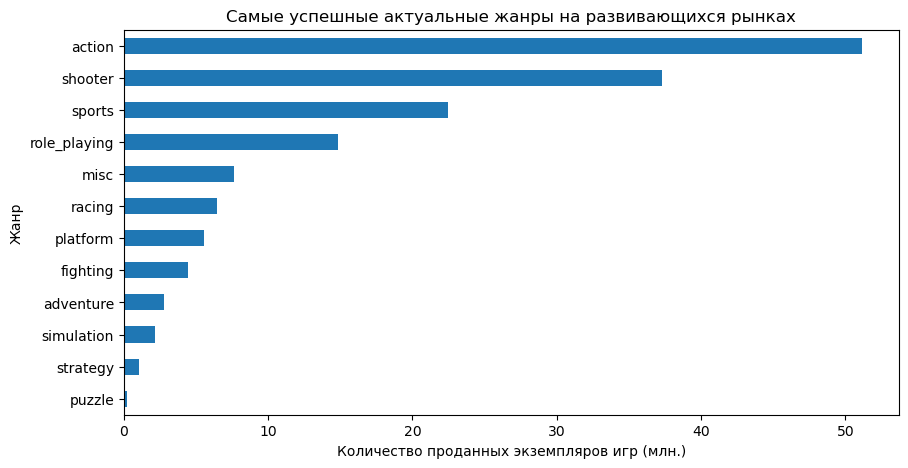

In [123]:
rw_top_actual_genres.sort_values(by='sum_sales', ascending=True). \
plot( kind = 'barh', x= 'genre', y= 'sum_sales', legend=False, figsize = (10,5))

plt.title('Самые успешные актуальные жанры на развивающихся рынках')
plt.xlabel('Количество проданных экземпляров игр (млн.)')
plt.ylabel('Жанр')

plt.show()

И посмотрим суммарные продажи для актуальных жанров. 

In [124]:
rw_top_actual_genres_sum = rw_top_actual_genres['sum_sales'].sum()
rw_top5_actual_genres_sum = rw_top5_actual_genres['sum_sales'].sum()

display(rw_top_actual_genres_sum)
display(rw_top5_actual_genres_sum)

156.14000000000001

133.34

По остальному миру видим следующее:

Снова можно повториться: возможно рынки, относящиеся в этом исследовании к развивающимся или к остальному миру могут на самом деле серьезно отличаться друг от друга с точки зрения предпочтений ( например возможно игроки в России и Китае имеют очень разные предпочтения), но консолидированно этот "макрорегион" показывает картину, сходную с Европой и Северной Америкой, при этом ближе к Европе. Отличий по сути всего два и они не представляются значительными:

- на развивающихся рынках жанры misc и racing , находящиеся на 5 и 6 местах "поменялись местами" в сравнении с европейским рейтингом и racing стал несколько ближе к Америке (здесь на 6-м месте, а там на 8-м);     
- жанр simulation находится ниже по рейтингу, чем в Европе: здесь он на 10-м месте, а в Европе - на 7-м, а в Америке - тоже на 10-м.

Во всем остальном: и расположение лидеров и аутсайдеров и примерные соотношения между долями каждого жанра - очень похожи на европейские, иногда чуть "дрейфуя" в сторону североамериканских.

Как и для платформ попробуем визуализировать это распределение долей разных жанров для всех регионов на одном графике. Тоже для украшения презентации.

Создадим "заготовку" для графика

In [125]:
# Создадим небольшой датафрейм, столбцы которого будем выводить на график
top_actual_genres_for_print = pd.DataFrame(columns=['genre', 'na_sales', 'eu_sales', 'jp_sales', 'rw_sales','total_sales', \
                                                        'na_shares', 'eu_shares', 'jp_shares', 'rw_shares', 'total_shares'])

# Наполним данными

top_actual_genres_for_print[['genre', 'total_sales']] = top_actual_genres[['genre', 'sum_sales']]

for genre in top_actual_genres_for_print['genre']:
    # Америка
    top_actual_genres_for_print.loc[top_actual_genres_for_print['genre'] == genre,'na_sales'] = \
    na_top_actual_genres.loc[na_top_actual_genres['genre'] == genre, 'sum_sales']
    # Европа
    top_actual_genres_for_print.loc[top_actual_genres_for_print['genre'] == genre,'eu_sales'] = \
    eu_top_actual_genres.loc[eu_top_actual_genres['genre'] == genre, 'sum_sales']
    # Япония
    top_actual_genres_for_print.loc[top_actual_genres_for_print['genre'] == genre,'jp_sales'] = \
    jp_top_actual_genres.loc[jp_top_actual_genres['genre'] == genre, 'sum_sales']
    # Остальной мир
    top_actual_genres_for_print.loc[top_actual_genres_for_print['genre'] == genre,'rw_sales'] = \
    rw_top_actual_genres.loc[rw_top_actual_genres['genre'] == genre, 'sum_sales']

#top_actual_genres_for_print['total_shares'] = top_actual_genres_for_print['total_sales'] / top_actual_genres_for_print['total_sales'].sum()    
top_actual_genres_for_print[['na_shares', 'eu_shares', 'jp_shares', 'rw_shares', 'total_shares']] = \
top_actual_genres_for_print[['na_sales', 'eu_sales', 'jp_sales', 'rw_sales','total_sales']] / \
top_actual_genres_for_print[['na_sales', 'eu_sales', 'jp_sales', 'rw_sales', 'total_sales']].sum()    

# Смотрим что получилось    
top_actual_genres_for_print

,genre,na_sales,eu_sales,jp_sales,rw_sales,total_sales,na_shares,eu_shares,jp_shares,rw_shares,total_shares
0,action,177.84,159.34,52.8,51.14,441.12,0.300929,0.314435,0.274172,0.327527,0.304969
8,shooter,144.77,113.47,9.23,37.26,304.73,0.24497,0.223917,0.047928,0.238632,0.210676
7,role_playing,64.0,48.53,65.44,14.83,192.80,0.108297,0.095767,0.339807,0.094979,0.133293
10,sports,81.53,69.08,8.01,22.44,181.06,0.13796,0.13632,0.041593,0.143717,0.125176
3,misc,38.19,26.32,12.86,7.67,85.04,0.064623,0.051939,0.066777,0.049123,0.058793
4,platform,25.38,21.41,8.63,5.58,61.00,0.042946,0.04225,0.044813,0.035737,0.042173
6,racing,17.22,27.23,2.5,6.47,53.42,0.029139,0.053735,0.012982,0.041437,0.036932
2,fighting,19.79,10.79,9.44,4.47,44.49,0.033487,0.021293,0.049019,0.028628,0.030758
9,simulation,7.97,14.55,10.41,2.19,35.12,0.013486,0.028712,0.054055,0.014026,0.02428
1,adventure,8.92,9.46,8.24,2.81,29.43,0.015094,0.018668,0.042787,0.017997,0.020347


Построим график распределения продаж ...

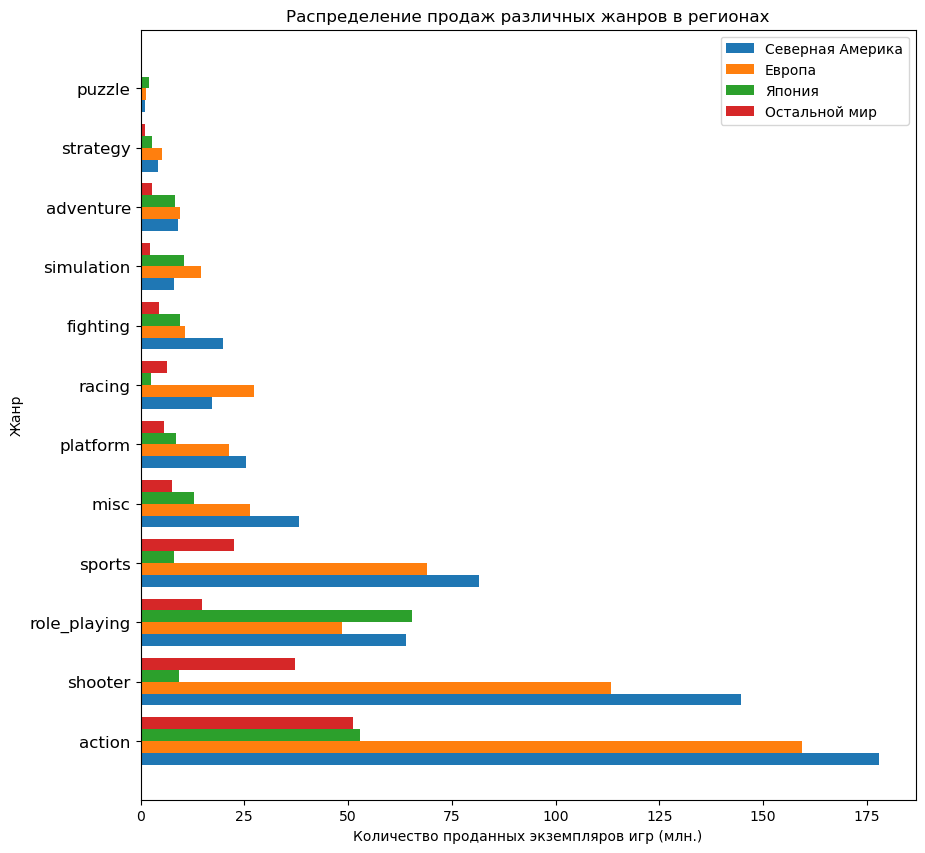

In [126]:
# Жанров у нас 12, поэтому серий будет 12
x = np.arange(12)

# Регионов у нас 4, поэтому "столбцов" в серии будет 4, но чтобы их немного "раздвинуть" возьмем ширину равной 5
bw = 1/5

# Зададим данные для графика
y_na = top_actual_genres_for_print['na_sales']
y_eu = top_actual_genres_for_print['eu_sales']
y_jp = top_actual_genres_for_print['jp_sales']
y_rw = top_actual_genres_for_print['rw_sales']

# Создадим собственно графики
plt.barh(x, y_na, bw, label='Северная Америка')
plt.barh(x+1*bw, y_eu, bw, label='Европа')
plt.barh(x+2*bw, y_jp, bw, label='Япония')
plt.barh(x+3*bw, y_rw, bw, label='Остальной мир')

# Подпишем оси и графики
plt.yticks(x+1.5*bw, top_actual_genres_for_print['genre'], fontsize=12)

plt.xlabel('Количество проданных экземпляров игр (млн.)')
plt.ylabel('Жанр')
plt.title('Распределение продаж различных жанров в регионах')

# Включим легенду
plt.legend()

# Зададим размер
plt.rcParams ['figure.figsize'] = [10, 10]

# Выведем график
plt.show()


... и график распределения долей различных жанров по регионам.

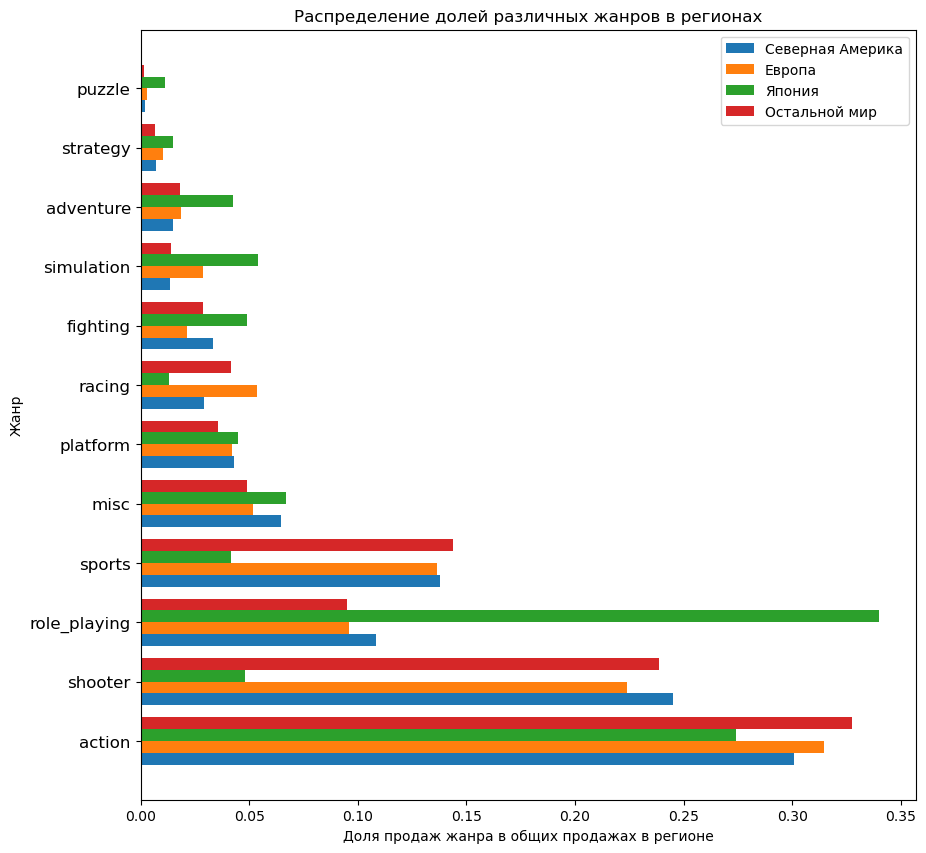

In [127]:
# Жанров у нас 12, поэтому серий будет 12
x = np.arange(12)

# Регионов у нас 4, поэтому "столбцов" в серии будет 4, но чтобы их немного "раздвинуть" возьмем ширину равной 5
bw = 1/5

# Зададим данные для графика
y_na = top_actual_genres_for_print['na_shares']
y_eu = top_actual_genres_for_print['eu_shares']
y_jp = top_actual_genres_for_print['jp_shares']
y_rw = top_actual_genres_for_print['rw_shares']

# Создадим собственно графики
plt.barh(x, y_na, bw, label='Северная Америка')
plt.barh(x+1*bw, y_eu, bw, label='Европа')
plt.barh(x+2*bw, y_jp, bw, label='Япония')
plt.barh(x+3*bw, y_rw, bw, label='Остальной мир')

# Подпишем оси и графики
plt.yticks(x+1.5*bw, top_actual_genres_for_print['genre'], fontsize=12)

plt.xlabel('Доля продаж жанра в общих продажах в регионе')
plt.ylabel('Жанр')
plt.title('Распределение долей различных жанров в регионах')

# Включим легенду
plt.legend()

# Зададим размер
plt.rcParams ['figure.figsize'] = [10, 10]

# Выведем график
plt.show()
   

### Определить влияет ли рейтинг ESRB на продажи в регионе?

Будем проводить анализ для тех же 4-х регионов, для актуальных платформ на основе датафрейма actual_games.      
Рейтинг ESRB находится в столбце "rating".     

Посмотрим какие рейтинги ESRB для актуальных игр есть в нашем датафрейме.

In [128]:
tot_actual_ratings = actual_games['rating'].value_counts(normalize=True)

tot_actual_ratings

rating
no_rating    0.389736
m            0.193481
t            0.161581
e            0.142857
e10+         0.112344
Name: proportion, dtype: float64

Посмотрим как распределены продажи по рейтингам ESRB суммарно для всего мира (столбец "total_sales").

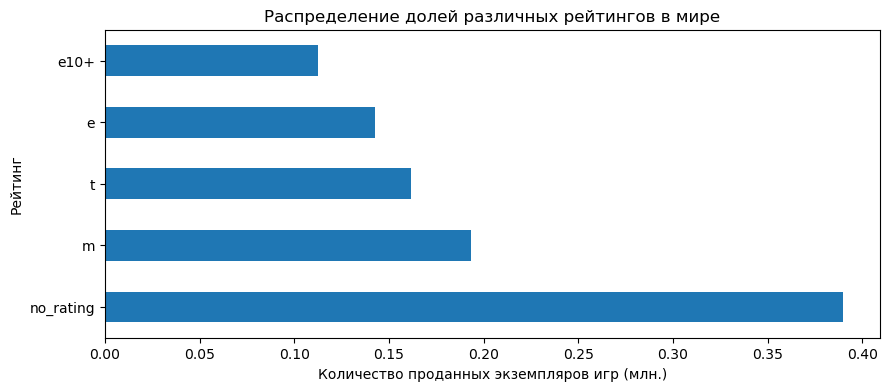

In [129]:
tot_actual_ratings.plot( kind = 'barh', x= 'rating', y= 'sum_sales', legend=False, figsize = (10,4))

plt.title('Распределение долей различных рейтингов в мире')
plt.xlabel('Количество проданных экземпляров игр (млн.)')
plt.ylabel('Рейтинг')

plt.show()

Видим 5 рейтингов,      
причем самый крупный из них: 1127 игр из 2890 или 39% - это "отсутствие рейтинга", который мы заполняли самостоятельно по отсутствующим значениям.        
Следующие в порядке убывания:        
    -  m   = игра для взрослых (старше 17 лет) - 19.3% от всех игр;       
    -  t   = игра для подростков (от 13 лет) - 16.2% от всех;       
    -  e   = игра для всех - 14.3%;       
    - e10+ = для всех от 10 лет и старше - 11.2%. 

Построим как распределены различные рейтинги в разных регионах ( столбцы 'na_sales', 'eu_sales', 'jp_sales', 'other_sales').

Сначала создадим "заготовку" для построения графика.

In [130]:
# Аггрегируем по рейтингу и игре и сохраняем результат в отдельном фрейме
actual_ratings = actual_games.groupby(['rating']) \
.agg({'na_sales': ['sum'], 'eu_sales': ['sum'], 'jp_sales': ['sum'], 'other_sales': ['sum'], 'total_sales': ['sum'] })

# Сбрасываем индекс и переименовуем столбцы
actual_ratings.reset_index(inplace=True)
actual_ratings.columns = ['rating', 'na_sales', 'eu_sales', 'jp_sales', 'rw_sales', 'total_sales' ]

# Создадим столбцы "..._shares"с долей продаж (разделим столбец "..._sales" на общую сумму продаж)
actual_ratings[['na_shares', 'eu_shares', 'jp_shares', 'rw_shares', 'total_shares']] = \
actual_ratings[['na_sales', 'eu_sales', 'jp_sales', 'rw_sales', 'total_sales']] / \
actual_ratings[['na_sales', 'eu_sales', 'jp_sales', 'rw_sales', 'total_sales']].sum()

# Сделаем сортировку по объему продаж 
actual_top_ratings = actual_ratings.sort_values(by='total_sales', ascending=False)

# Смотрим что получилось
actual_top_ratings

,rating,na_sales,eu_sales,jp_sales,rw_sales,total_sales,na_shares,eu_shares,jp_shares,rw_shares,total_shares
2,m,242.24,205.95,22.35,67.20,537.74,0.409902,0.406413,0.116056,0.430383,0.371768
0,e,117.74,115.34,29.27,32.08,294.43,0.199232,0.227607,0.151989,0.205457,0.203555
3,no_rating,83.30,70.51,103.26,20.49,277.56,0.140955,0.139142,0.536193,0.131228,0.191892
4,t,69.80,56.98,29.13,19.49,175.40,0.118111,0.112442,0.151262,0.124824,0.121263
1,e10+,77.89,57.97,8.57,16.88,161.31,0.131800,0.114396,0.044501,0.108108,0.111522


И построим график распределения долей различных рейтингов по регионам.

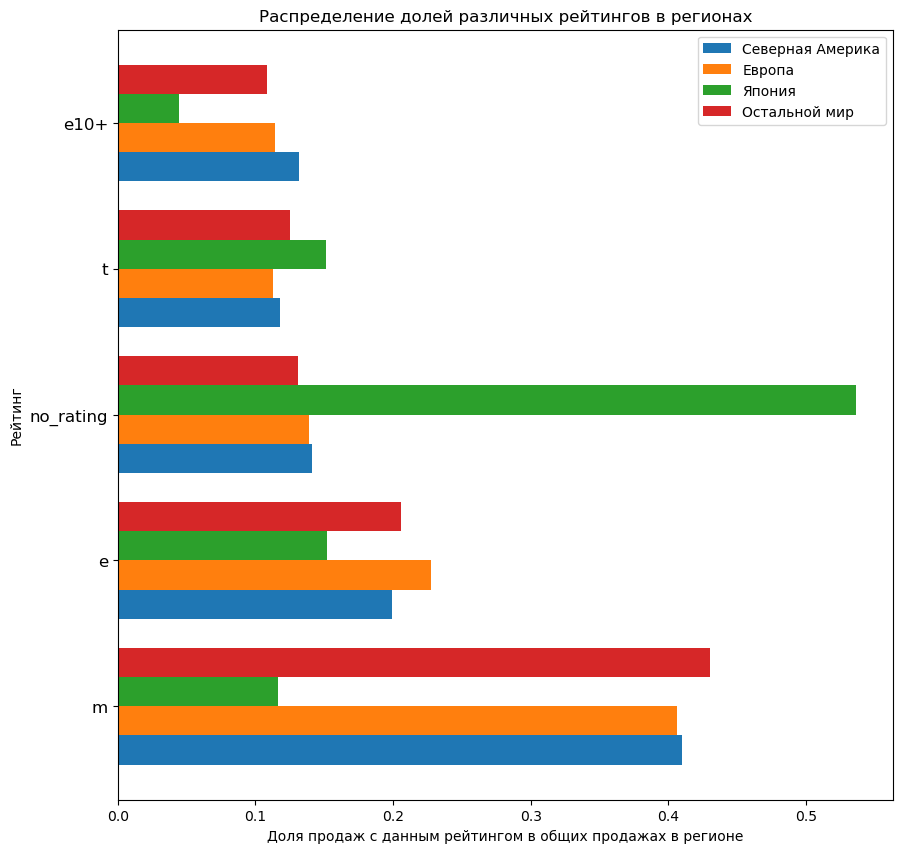

In [131]:
# Рейтингов у нас 5, поэтому серий будет 5
x = np.arange(5)

# Регионов у нас 4, поэтому "столбцов" в серии будет 4, но чтобы их немного "раздвинуть" возьмем ширину равной 5
bw = 1/5

# Зададим данные для графика
y_na = actual_top_ratings['na_shares']
y_eu = actual_top_ratings['eu_shares']
y_jp = actual_top_ratings['jp_shares']
y_rw = actual_top_ratings['rw_shares']

# Создадим собственно графики
plt.barh(x, y_na, bw, label='Северная Америка')
plt.barh(x+1*bw, y_eu, bw, label='Европа')
plt.barh(x+2*bw, y_jp, bw, label='Япония')
plt.barh(x+3*bw, y_rw, bw, label='Остальной мир')

# Подпишем оси и графики
plt.yticks(x+1.5*bw, actual_top_ratings['rating'], fontsize=12)

plt.xlabel('Доля продаж с данным рейтингом в общих продажах в регионе')
plt.ylabel('Рейтинг')
plt.title('Распределение долей различных рейтингов в регионах')

# Включим легенду
plt.legend()

# Зададим размер
plt.rcParams ['figure.figsize'] = [10, 5]

# выведем график
plt.show()

Видим: 

Судя по распределению рейтингов в различных регионах (и особенно - по доле "no_rating" среди проданных игр) видим, что как и с предпочтениями по платформам и жанрам картина рынка Японии кардинально отличается от картин в регионах Северная Америка, Европа и Остальной мир (которые весьма похожи между собой).     
По всей видимости можем утверждать, что пользователи в регионах СА, ЕС и ОМ обращают внимание на рейтинг ESRB при выборе и покупке игр. При этом картины их предпочтений весьма схожи и отличаются незначительно.    
В то же время жители Японии ориентируются на собслвенный вкус и по всей видимости не обращают внимания (или обращают очень мало внимания) на рейтинг ESRB при покупке игр.

## Шаг 5. Проверка гипотез

### Проверить гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

По всей видимости платформа Xbox One "скрывается" в нашем датасете под "псевдонимом" xone.

По рейтингам, которые мы анализировали выше xone всегда была выше в продажах, чем pc (за исключением Японии, где они были сравнимы с преимкществом тем не менее xone).       
Интуитивно есть подозрение, что и пользовательские рейтинги у платформы xone тоже выше, чем у pc.      
Поэтому в качестве альтернативной гипотезы хочется взять именно такую одностороннюю гипотезу: средний пользовательский рейтинг у платформы xone тоже выше, чем у pc. 

Поскольку и xone и pc находятся среди "актуальных" платформ - удобнее всего взять за основу датафрейм actual_games.      
Пользовательские рейтинги отображены в столбце "user_score", а перечень платформ дан в столбце "platform".

Будем считать, что оценки проставляются пользователями независимо друг от друга (строго говоря это не совсем так, поскольку насколько я понимаю оценки открыты и пользователи могут с ними знакомиться и это может влиять на их собственную оценку, однако такое влияние при наличии собственного опята игры не должно быть очень уж велико и допущение о независимости вполне уместно) и значит совокупности независимы.      
Значит мы можем применить функцию st.ttest_ind().         
В качестве аргумента array_1 будем использлвать значения столбца "user_score", сгруппированные по значению столбца "platform" равному xone,        
а в качестве array_2 - значения столбца "user_score", сгруппированные по значению столбца "platform" равному pc.     
При этом, поскольку оценки для xone идут первым массивом, а альтернативная гипотеза у нас, что среднее для xone больше - то параметр alternative выставим в положение 'greater'.         
Уровень статистической значимости alpha возьмем равным 5%. Если р-значение на выходе теста будет меньше нее, то гипотеза о равенстве средних будет отвергнута.


Но сначала создадим соответствующие массивы значений оценок пользователей для платформ xone и pc.

In [132]:
# Создаем массивы для тестирования
xone_user_scores = actual_games.loc[actual_games['platform'] == 'xone']['user_score']
pc_user_scores = actual_games.loc[actual_games['platform'] == 'pc']['user_score']

# Смотрим что получилось 
display(xone_user_scores.head(5))
display(pc_user_scores.head(5))

99     1.2
165    7.9
179    5.4
242    6.4
270    6.2
Name: user_score, dtype: float64

192     4.0
458     3.9
688     7.9
959     4.8
1095    7.9
Name: user_score, dtype: float64

Массивы созданы.    
Теперь в качестве array_1 у нас массив xone_user_scores, а в качестве array_2 - массив pc_user_scores.     

Проверим при помощи describe() насколько близки эти два массива (две выборки) по размеру ( и на всякий случай - насколько разнятся их стандартные отклонения, хотя для больших выборок это уже неважно). Если они сопоставимы - то можно будет выставлять параметр equal_var поставим равным True, если же разница велика - будем выставлять равным False.

In [133]:
display(xone_user_scores.describe())
display(pc_user_scores.describe())

count    247.000000
mean       5.602632
std        2.610326
min        0.000000
25%        5.000000
50%        6.400000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

count    249.000000
mean       5.494177
std        2.630730
min        0.000000
25%        4.000000
50%        6.300000
75%        7.600000
max        9.300000
Name: user_score, dtype: float64

Массивы сопоставимы.    
Поэтому можем выставлять параметр equal_var поставим равным True.

Итак,    

Проверяем следующее:         
Нулевая гипотеза: средний пользовательский рейтинг для платформ xone и pc равны;
Альтернативная односторонняя гипотеза: средний пользовательский рейтинг для платформы xone статистически значимо больше чем средний пользовательский рейтинг для pc.

Проверяем при помощи функции st.ttest_ind() для значений массивов array_1 = xone_user_scores и array_2 = pc_user_scores, значение параметра equal_var ставим равным True а параметр alternative выставляем в положение 'greater'.      
Уровень статистической значимости alpha возьмем равным 5%.

In [125]:
alpha = 0.05

results = st.ttest_ind( xone_user_scores, pc_user_scores, equal_var = True, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.3225553647827667
Не получилось отвергнуть нулевую гипотезу


Вывод:

Наши интуитивные предположения оказались неверны:        
Нулевая гипотеза о том, что средний пользовательский рейтинг для платформ xone и pc равны НЕ была отвергнута.    
Причем мы могли бы взять и на порядок меньшее значение alpha и все равно нулевую гипотезу отвергнуть не получилось бы - нстолько близки средние оценки у этих двух платформ.   
Таким образом мы можем статистически значимо утверждать, что средние пользовательские рейтинги платформ Xbox One и PC совпадают.

### Проверить гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные.

По рейтингам, которые мы анализировали выше жанр action всегда лидировал в продажах и был выше жанра sport. Резонно было бы ожидать, что и оценки пользователей у этого жанра будут заметно выше. Однако мы уже только что "обожглись" с аналогичным априорным предположением для платформ. Поэтому проверим.

Возьмем за основу датафрейм actual_games. Пользовательские рейтинги отображены в столбце "user_score", а перечень жанров дан в столбце "genre".

Так же, как и для платформ будем считать, что оценки проставляются пользователями независимо друг от друга и совокупности данных независимы. То есть применять снова будем функцию st.ttest_ind().         
В качестве аргумента array_1 будем использлвать значения столбца "user_score", сгруппированные по значению столбца "genre" равному action, а в качестве array_2 - значения столбца "user_score", сгруппированные по значению sports.     

В качестве нулевой гипотезы удобнее выдвинуть гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports равны.      
Поскольку в постановке заказчика необходимо проверить, что пользовательские рейтинги этих жанров просто разные (неважно в какую сторону), то параметр alternative можно не выставлять (он two-sided по умолчанию)
        
Уровень статистической значимости alpha возьмем равным 5%. Если р-значение на выходе теста будет меньше нее, то гипотеза о равенстве средних будет отвергнута.

Создадим соответствующие массивы значений оценок пользователей для жанров action и sports.

In [134]:
# Создаем массивы для тестирования
action_user_scores = actual_games.loc[actual_games['genre'] == 'action']['user_score']
sports_user_scores = actual_games.loc[actual_games['genre'] == 'sports']['user_score']

# Смотрим что получилось 
display(action_user_scores.head(5))
display(sports_user_scores.head(5))

16     8.2
23     8.1
42     8.3
81     6.6
127    6.9
Name: user_score, dtype: float64

77     4.3
94     5.0
126    4.3
143    5.7
264    4.5
Name: user_score, dtype: float64

Массивы созданы.    
Теперь в качестве array_1 у нас массив action_user_scores, а в качестве array_2 - массив sports_user_scores.     

Проверим при помощи describe() насколько близки эти два массива (две выборки) по размеру.

In [135]:
display(action_user_scores.describe())
display(sports_user_scores.describe())

count    1031.000000
mean        4.117944
std         3.402726
min         0.300000
25%         0.300000
50%         5.300000
75%         7.400000
max         9.100000
Name: user_score, dtype: float64

count    267.000000
mean       4.495318
std        2.520910
min        0.200000
25%        3.050000
50%        5.200000
75%        6.550000
max        8.800000
Name: user_score, dtype: float64

В этом случае сравниваемые массивы существенно разные по размеру (в четыре раза).    
Поэтому правильным будет выставить параметр equal_var поставим равным False.

Итак,    

Проверяем следующее:         
Нулевая гипотеза: средний пользовательский рейтинг для жанра action статистически значимо равен среднему пользовательскому рейтингу для жанра sports;         
Альтернативная двухсторонняя гипотеза: средние пользовательские рейтинги жанров action и sports не равны.

Проверяем при помощи функции st.ttest_ind() для значений массивов array_1 = action_user_scores и array_2 = sports_user_scores;    
значение параметра equal_var ставим равным False;       
параметр alternative не выставляем или высьавляем в положение 'two-sided';      
уровень статистической значимости alpha берем равным 5%.

In [136]:
alpha = 0.05

results = st.ttest_ind( action_user_scores, sports_user_scores, equal_var = False, alternative = 'two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.04426559353624639
Отвергаем нулевую гипотезу


Вывод:

Нулевая гипотеза о том, что средний пользовательский рейтинг для для жанра action статистически значимо равен среднему пользовательскому рейтингу для жанра sports Не была отвергнута.    
Это означает, что пользовательские оценки для игр этих жанров настолько близки, что мы не можем утверждать, что они в среднем не равны.   
Таким образом мы можем статистически значимо утверждать, что гипотеза о том, что средние спользовательские рейтинги жанров Action и Sports разные НЕ подтверждается.

### Общие выводы:

#### Проект заказан интернет-магазином «Стримчик», который продаёт по всему миру компьютерные игры.

#### Были проанализированы исторические данные до 2016 года из открытых источников о продажах игр, оценке пользователей и экспертов, распределении игр по жанрам и платформам.  

Информация была предствлена в едином датасете и представляла набор данных о 11559 играх на 31 игровой платформе, представляющих 12 различных жанров, выпущенных в одном или нескольких релизах в период с 1980 по 2016 год.      
Помимо наименования игры, ее платформы и жанра датасет включал в себя данные о продажах всех игр по релизам ( а не в разбивке по годам), выраженные в миллионах проданных копий игр в разбивке по четырем регионам: Северной Америке, Европе (Евросоюзу), Японии и Остальному миру.      
Были так-же представлены данные об оценках, которые были даны игре экспертами (критиками) и пользователями (игроками).     
Кроме того были представлен ванные о возрастном рейтинге, присвоенной игре ESRB (Entertainment Software Rating Board) - всемирной ассоциацией, которая определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.     

В целом представленная выборка была полна и репрезентетивна. Нестыковок и возможных ошибок, существенно влияющих на качество анализа не выявлено (явных дубликатов например выявлено всего 4).      
Тем не менее было обнаружено, что в отдельных категориях отсутствует значительный объем данных. При общем размере датафрейма в 16715 строк (данных о релизах игр)
    - показатели по оценкам наличествуют только чуть больше, чем у половины игр: оценки экспертов (столбец "Critic_Score")  для 8137 игр, оценки пользователей ("User_Score") для 10014 игр. В целях дальнейшего анализа было принято предположение, что отсутствие данных означает отсутствие оценки, а отсутствие оценки означает минимально возможную оценку 0.
    - в графе с данными о рейтинге ESRB (столбец "Rating") было заполнено только 9949 значений. В этом случае было так-же принято предположение, что рейтинг отсутствует и в целях проведения анализа введен специальный показатель - "отсутствие рейтинга".
    - показатели по году выпуска игры так-же присутствовали не для всех игр, а только в 16446 строках, то есть были пропуски в 269 строках. Без кардинального аналтиза сторонних источников заполнить эти "пробелы" было невозможно. Однако количество пропусков относительно невелико и было принято предположение, что отсутствие этой информации существенно не повлияет на качетсво исследования.

Самой распространенной в мире игрой оказалась "Need for Speed".

##### Была проведена необходимая предобработка данных для проведения анализа:
Были приведены в порядок наименовния столбцов, заменены на "правильные" типы данных в датафрейме, обработаны пропуски и дубликаты.      
Отдельно обработано значение "tbd" как параметр пользовательского рейтинга, который в остальных случаях представляет собой оценку по десятибальной шкале: было сделано предпололожение, что "tbd" означает to be determined - аналог "пока рано оценивать" и что в этом случае логично заменить такую оценку на минимальную в жанре. Что и было сделано.

#### Были посчитаны суммарные продажи игр во всех регионах:    
Суммарные продажи всех игр за все 37 лет по всем регионам составили около 8.8 миллиардов проданных экземпляров игр. За это же время выпущено 16455 релизов различных игр.

#### Были проанализированы параметры распределения выпуска игр по годам. Выявлено следующее:    
1. Распределение выпуска игр по годам имеет форму нормального распределения, с центром около конца нулевых годов, немного "скошенного вправо" - в более позднюю сторону; 

2. За рассматриваемый период (с 1980 по 2016 включительно) ежегодно в среднем выпускалось 445 игр. Продавалось же 238 миллионов копий.      

3. Максимальное количество выпускаемых игр наблюдалось в 2008 и 2009 годах на уровне 1427 выпущенных игр в год, максимум продаж наблюдался в эти же годы на уровне 672 и 659 миллионов проданных экземпляров ежегодно. 

4. Исторически можно проследить следующие основные периоды развития индустрии выпуска игр:
    - в ранний период - все 80-е и самое начало 90-х годов количествовыпускаемых игр было минимально (около 15 игр ежегодно);          
    - резкий рост начался с 1993 года, что хорошо соответствует изобретению и взрывному росту популярности интернета (1991 год создания). На этом этапе роста довольно четко прослеживается всплеск в 2002 году (с 482 до 829 выпущенных за год игр) и последующий после этого локальный спад в 2003-04 годах (до 775 и 762 выпущенных игр соответственно). Это соответствует надуванию и последующему сдутию "пузыря доткомов";
    - как уже отмечалось максимум в 1427 игр достигнут в 2008-09 годах. После 2009 года наблюдается снижение выпуска игр вплоть до локального минимума в 541 выпущенную игру в 2013 году. Это снижение может быть объяснено как общим начыщением рынка на существующих технологиях, так и заметным влиянием на отрасль экономического кризиса 2008-09 годов;
    - после локального минимума в 2013 году в мы наблюдаем рост ( до 606 выпущенных игр в 2015), что возможно объясняется бурным развитием рынка смартфонов и разработки мобильных игр. Данные за 2016 год неполны, поэтому не подтверждают этот рост.       
При этом график объемов продаж фактически повторяет и по форме и по этапам график выпуска игр, с поправкой на то, что последний по времени рост (2012-15 годов) не столь явно выражен.

#### Были проанализированы параметры распределения выпуска  и продаж игр  на различных платформах за весь период с 1980 по 2016 год . Выявлено следующее:     
1. Всего за период с 1980 по 2016 год выпускались и продавались игры всего на 31 платформе.    

2. Лидерами по производству игр (топ-5) за все время являются платформы:
    - ps2  - 2162 выпущенные игры, 
    - ds   - 2151 игра,
    - ps3  - 1332 игры,
    - wii  - 1320 игр,
    - x360 - 1263 игры.

3. Лидерами продаж игр (топ-5) за все время являются следующие платформы: 
    - ps2 - 1233.6 миллиона проданных экземпляров игр, 
    - x360 - 961.3 миллиона экземпляров игр,
    - ps3 - 931.4 миллиона копий игр,
    - wii - 891.2 миллиона игр,
    - ds - 802.8 миллиона.

4. Представленные платформы разделяются по объемам продаж довольно четко на три категории:
    - платформы, которые "жили" в 80-90-е годы и прекратили свое существование или до начала нулевых, или в начале нулевых, по всей видимости в результпте обвала доткомов. Таких платформ 15.
    - платформы, которые "родились" в 90-е или начале 2000-х и просуществовали до начала десятых годов. Прекращение их деятельности можно объяснить скорее бурным ростом смартфонов как конкурента и превращением их в платформу для игр; однако для некоторых возможно влияние экономического кризиса 2008-09 годов. Таких платформ 6.
    - платформы, которые возникли в начале или середине нулевых и существуют до сих пор. Таких платформ 10. 

##### Исходя из анализа приведенных крафиков "характерный срок жизни" платформы видится равным 8-12 лет (в среднем - 10 лет). За этот срок большинство платформ "умирают" и на их смену приходят новые.
Исключением здесь являются персональные компьютеры как плтформа для игр. Они появились в качестве платформы вскоре после своего появления и распространения ( в 1985-м году) и продолжают оставаться одной из основных платформ для игр на конец 2016-го года.

#### Был проанализирован вопрос о ценности данных за все периоды. Выявлено следующее:
1. Поскольку исторически условия в отрасли меняются достаточно динамично, то большинство выпущенных ранее игр к 2017 фактически прекратило свое существование: в 2016 сохранили хоть какие-то продажи только 2890 из 16455 выпущенных игр.
2. Поэтому реальной ценностью для прогноза на 2017 и далее обладают данные за 2012-2015 годы и частично - за 2016 (но осторожно - они неполны).          
Именно в этот период отрасль преодолев кризис по всей видимости вышла на подъем, сформированы все технологические основы создания игр (компьютерные и платформенные с хорошей графикой, мобильные с элементами сетевой игры на 4G и т.д.), но в то же время никаких "революционных" изобретений (как то какие-то принципиально новые платформы, ИИ или дополненная реальность) - пока в нет на массовом рынке.
3. В дальнейшем основное внимание в исследовании будет уделено именно этому "актуальному "периоду - с 2012 по 2016 годы включительно.  

#### Были проанализированы параметры распределения продаж игр  на различных платформах за "актуальный период" - с 2012 по 2016 год . Выявлено следующее:      
1. Количество "актуальных" платформ, то есть платформ,  сохранивших продажную активность до 2016 года - равно 11 платформам Суммарные продажи на этих  11-ти актуальных платформах составили 1447 миллионов экземпляров игр за 5 лет (с 2012 по 2016 включительно). 

2. Самой коммерчески успешной платформой можно считать ps4. Ее средние продажи составляют 78 миллионов экземпляров, медиана равна 104 М, межквартильный размах ок. 47 М и усы ок 90 М. С учетом того, что как мы отмечали ранее эта платформа появилась в 2013 году и с тех пор демонстрирует стабильный рост продаж - ее можно считать неоспоримым лидером.

3. В топ-5 актуальных платформ, которые показали самые крупные продажи игр суммарно за последние 5 лет входят: ps4, ps3, x360 3ds и xone.
Отметим что pc как игровая платформа находится в этом списке только на 7-м месте.

4. С точки зрения динамики продаж - из топ-5 коммерчески успешных современных платформ - ps4, ps3, x360 3ds и xone: 
    - у ps3 и x360 продажи стабильно снижались с 2013-го года и в 2016-м упали практически до нуля. Думаестя, что вариантов       какого-либо восстановления продаж на этих платформах нет; 
    - платформа 3ds хоть и не "уронила" продажи до нуля, однако на протяжении 2013-16 годов демонстрирует стабильный спад         продаж, который вероятнее всего продолжится и в 2017-м году;
    - платформы xone и ps4 показывали стабильный рост продаж на протяжении 2013-15 годов. Данные за 2016-й год показывают снижжение, но нужно иметь вииду, что данные за этот год могут быть неполны.
    
5. С точки зрения разброса параметров внутни платформ - из топ-5 платформ:
    - платформа ps4 имеет средний объем продаж на уровне от 78.5 миллионов экземпляров игр при медиане 84.6 миллионов
    - платформы 3ds, ps3, x360 и xone, имеют средний объем продаж на уровне от 35 до 60 миллионов экземпляров игр, медианы       на уровне от 35 до 48 М и подразделяются на две части по две платформы:
        - ps3 и x360 деманстрируют отличающиеся средние (57 и 47 М соответственно), столь же разные медианы (48 и 35 М) и             довольно значительный "разброс" - межквартильный размах на уровне 90 и 75 М соответственно и "усы" - около 100             миллионов;
        - 3ds и xone имеют средние чуть пониже (около 40 М), но являются довольно стабильными с небольшим межквартильным             размахом (чуть больше 20 М) и "усами" (около 40 М).
        
6. Нужно иметь ввиду что практически на каждой платформу очень много "выбросов вверх". По всей видимости это свидетельствует о том, что игры - это продукт "эмоциональный", которому свойственен разброс эмоционального восприятия отдельных игр и элементы ажтотажа.
###### Таким образом есть смысл считать перспективными и потенциально прибыльными на период 2017 и далее платформы  ps4, xone и возможно не сбрасывать со счетов pc как наиболее "универсальную" платформу.
  
#### Было исследовано как влияют на продажи игр на популярных платформах отзывы критиков и пользователей. 
В качестве "подопытного кролика" предлагается взять например платформу 3ds: эта платформа возможно все еще актуальна (она имеет ненулевые продажи в 2016-м году), она входит в топ-5, она на протяжении полседних 5 лет демонстрировала и увеличение и спад продаж ( в отличие от ps4 и xone, которые демонстрируют стабильный рост и от ps3 и x360, которые стабильно "падают") и на ней продавалось 397 игр (ежегодно около 80-90 игр), что даст хороший базис для сопоставления.       
При этом выводы, сделанные на основе этой платформы были проверены и соотнесены на остальные плтформы из топ-5.
##### Выявлено следующее:
1. Коэффициент корреляции между оценкой критиков и количеством проданных экземпляров игр равен 0.19, а между тем же количеством проданных копий и оценкой пользователей - 0.13;        
2. Диаграммы рассеяния подтверждают вывод о том, что оценки как критиков, так и пользователей на продажи практически не влияют;          
3. Остальные платформы из топ-5 только подтвердили неутешительный вывод, который мы сделали на основании анализа платформы 3ds:
    - коэффициенты корреляции для оценок критиков варьируются от 0.23 до 0.31, а для оценок пользователей - от 0.06 до           0.22;
    - этот же вывод подтверждает и вид диаграмм рассеяния, на которых не наблюдается никакой формы.
###### Таким образом можно предполагать, что объем продаж никак не зависит от оценок как экспертов, так и пользователей.


#### Были проанализированы параметры распределения продаж игр  разных жанров с 2012 по 2016 год . Выявлено следующее:      
1. Количество "актуальных" жанров, то есть жанров, в которых есть продажная активность в период 12-16 годов - 12 жанров Суммарные продажи игр этих жанров составили за 5 лет 1447 миллионов экземпляров. 

2. В топ-5 лидерующих жарнов входят жанры: "action", "shooter", "role-playing", "sports" и "misc".  Суммарные продажи в этих жанрах за 5 лет  составили 1205 миллионов копий.   

3. Все 12 представленных жанры разделяются по объемам продаж довольно четко на четыре выраженных категории:         
    - Явного лидера продаж - жанр action с 1033 играми в этом жанре и 441 миллионом проданных копий этих игр;
    - Ближайших преследователей, которые представлены четырьмя жанрами
        - ближайший преследователь - жанр shooter с 235 играми в этом жанре и 305 миллионами проданных копий,
        - занимающий третье место жанр - role-playing, с 370 играми и 193 миллионами проданных экземпляров,
        - и наконец четвертый жанр - sports, который насчитывает 268 игр и 181 миллион продаж;
        - к этой же группе есть смысл отнести и жанр misc, который хоть и уступает остальным в количестве игр (их 193) и             объеме продаж (85 миллионов копий), но по крайней мере входит в топ-5 и в нем еще может что-то произойти.
    - Жанры, которые можно назвать "середняками" или "болотом". Это обладают гораздо объемами продаж, вдвое меньшими, чем у       категории "преследователей" - от 30 до 61 миллионов. Таких жанров 5. При этом количество игр в этих жанрах                 варьируется от 80 в жанре simulation до 303 в жанре adventure. 
    - Два явных аутсайдера - жанры, продажи у которых в разы меньше, чем даже у предыдущей категории - "середнячков". Это
        - strategy с 71 представленной игрой и 13 миллионами проданных копий, 
        - puzzle c 28 играми и 5-ю миллионами продаж.
При этом разрыв в продажах между первыми двумя группами и всеми остальными таков, что возникают большие сомнения, что игры  в этих жанрах групп "середнячки" и "аутсайдеры" смогут когда-нибудь вырваться в топ.

4. С точки зрения перспективности нужно учитывать, что в качестве перспективных есть смысл брать жанры, в которых игры        стабильно приносят высокий доход, то есть жанры с высоким средним доходом на игру и с малым количеством "выбросов" в        распределении. Невзирая на то, что явным лидером продаж является жанр "action", тем не менее можно предложить самыми        песпективными играми на 2017 считать следующие: "shooter", "platform", "role-playing" и "sports". Даже в качестве          "запасного" есть смысл взять не жанр "action", показывающий высокую волатильность и довольно среднюю доходность на игру,    а например жанр "racing" или "misc", демонстрирующих большую доходность на игру и большую "компактность".
###### С учетом всего отмеченного выше реальной ценностью для прогноза на 2017 обладают следующие 4 жанра:  "shooter", "platform", "role-playing" и "sports".     
   
#### Были проанализированы предпочтения пользователей различных регионов относительно игровых платформ. 
Анализ проводился для следующих регионов:
    - Северная Америка = США и Канада,
    - Европа = Евросоюз,
    - Япония,
    - и весь остальной мир.
Данные анализировались за актуальный период с 2012 по 2016 год, по 11 платформам.
##### Выявлено следующее:
1. Суммарные продажи на 11-ти актуальных платформах составили:
    - по региону Северная Америка - 591 миллион экземпляров игр, что составляет 40.8% от общемировых,
    - по региону Европа - 507 миллион экземпляров игр (это несколько ниже чем в США и Канаде), что составляет 35.0% от           общемировых,
    - в Японии - 193 миллиона экземпляров игр что составляет 13% от общемировых продаж, 38% от европейских продаж и 33% -         от североамериканских,
    - в остальном мире - 156 миллионов экземпляров игр, что составляет 11% от общемировых продаж.
    
2. Продажи на топ-5-и платформах составили:
    - по региону Северная Америка - 501 миллион копий игр, то есть 42% от общемировых (1194 М),
    - в Европе - 417 миллионов копий, что составляет 35% от мировых и на 17% меньше, чем в Северной Америке,
    - в Японии - 173 миллиона игр,
    - в остальном мире - 135 миллионов.

3. Особенности регионов с точки зрения предпочтений их жителей при выборе игровой платформы следующие:
    - по региону Северная Америка:
        - если в глобальном рейтинге явным лидером является платформа ps4, то в североамериканском - платформа x360; 
        - примерно в таком же положении находятся платформы, занимающие 4 и 5 места - 3ds и xone.;
        - кроме того стоит отметить, что популярность платформы wii в Северной Америке существенно выше, чем в общем в               мире;          
      Таким образом жители Северной Америки предпочитают современные игровые платформы от американской Microsoft (x360 и         xone) и японских Sony (ps3, ps4) и Nintendo (3ds).
      При этом в лидерах приставки, предназначенные для игр дома перед телевизором, а не "на бегу" в городе. Соответственно       американцы и канадцы в основном предпочитают играть дома, в спокойной обстановке и на хорошем экране.         
    - по Европе:
        - в топ-5 платформ входят те же самые платформы, что и в Северной Америке и мировом рейтинге;
        - распределение среди 11 платформ по местам и соотношение продаж между платформами в EU похоже на общемировой                 рейтинг в верхней части и скорее ближе к американском - в нижней части;        
      Все говорит о том, что с точки зрения предпочтений жителей в части игровых платформ Европа представляет из себя нечто       среднее, между Америкой и остальным миром, но больше все-таки склоняясь к Америке.
    - по Японии:
        - Японский рынок кардинально отличается от европейского и североамериканского;
        - в топ-5 платформ уже не входят платформы те же самые платформы x360 и xone, их места в пятерке заняли psv с                 объемом продаж 21 миллион экземпляров (то есть 11% от всех продаж против 2% например в Европе) и wiiu с объемом             продаж в 13 миллионов ( 7% от всего объема против 5 в Европе);
        - Остальные три платформы - лидеры мирового рейтинга ps4, ps3 и 3ds присутствуют и в топе японского рейтинга.                 Однако распределение платформ по местам (и соответственно - долям в общей массе продаж по рынку) существенно               отличаются от уже рассмотренных: 
            - в то время, как в Америке ps4 и ps3 от Сони довольно близко следуют за х360, составляя от ее объемов 78% и                 73% соответственно, а в Европе эти платформы уверенно занимают первые места 
            - в Японии продажи ps4 и ps3 не превышают 18% и 40% от лидера соответственно; 
            - а вот 3ds от Nintendo уверенно  лидироует в Японии с объемом продаж в 88 миллионов копий, больше чем в два                 раза превосходя ближайшего конкурента;
        - интересными фактами так-же являются следующие: 
            - в топ-5 японского рейтинга ps3 пратктически вдвое опережает продажи своего последователя - ps4; 
            - pc как платформа для игр находится на последнем месте с ищезающе малым объемом продаж.
      Таким образом мы можем предположить:
      - что в подавляющем большинстве японцы предпочитают играть не сидя за компьютером или перед телевизором, а в движении         и "между делом": в дороге, на улице, в транспорте и т.д;
      - что японцы не только покупают более дешевые мобильные платформы, но и проявляют определенный консерватизм и не             спешат "гнаться" за последними новинками (продажи на платформе ps3 превышают продажи на ps4 больше чем в два раза).
    - по Остальному миру:
        - Рынки представлены консолидированно, хотя интуитивно можно допустить, что внутри этого макрорегиона существуют             большие отклонения в предпочтениях на уровне стран и субрегионов;   
        - В топ-5 платформ входят те же платформы, что и в Европе: ps4, ps3, x360 3ds и xone;
        - распределение платформ по местам и соотношение продаж между платформами так-же очень похоже на европейский рынок,           с той только разницей, что "преимущество" лидирующих платформ ps4 и ps3 по отношению к остальным платформам более           весомо.
       Таким образом предпочтения жителей региона очень похожи на предпочтения жителей Европы и Америки: люди больше              предпочитают играть дома перед телевизором, чем не "на бегу" в городе, и  для этого выбирают платформы те же, что          выбирают американцы или европейцы, отдавая чуть больше предпочтерия продукции фирмы Сони, возможно просто обладающей        большей узнаваемостью на этих рынках. 
#####  В целом рынки Америки, Европы и Остального мира имеют ряд общих черт, сводящихся к предпочтениям "домашних" игр            и "жаждой новинок".
#####  При этом рынок Японии проявляет практически диаметрально противоположные свойства, по всей видимости             связанные с  национальным характером (консерватизмом прежде всего) и более "социальным" стилем жизни ( о чем говорит предпочтение мобильных платформ).
  
#### Были проанализированы предпочтения пользователей различных регионов относительно жанров игр .    
Анализ проводился для тех же четырех регионов:
    - Северная Америка = США и Канада,
    - Европа = Евросоюз,
    - Япония,
    - и весь остальной мир.
и за тот же период с 2012 по 2016 год, по 12 жанрам.
##### Выявлено следующее:
1. Суммарные продажи в 12-ти актуальных жанрах составили:
    - по региону Северная Америка - 591 миллион экземпляров игр,
    - по региону Европа - 507 миллион экземпляров игр,
    - в Японии - 151 миллиона экземпляров игр,
    - в остальном мире - 156 миллионов экземпляров игр.
    
2. Продажи на топ-5-и платформах составили:
    - по региону Северная Америка - 506 миллион копий игр,
    - в Европе - 418 миллионов копий,
    - в Японии - 173 миллиона игр,
    - в остальном мире - 133 миллионов.

3. Особенности регионов с точки зрения предпочтений их жителей при выборе жанра игры следующие:
    - по региону Северная Америка:
        - вместо одного явного лидера рейтинга видим два жанра-лидера: жанр action с 178 миллионом проданных копий игр и             приближающийся к нему жанр shooter с 145 миллионами проданных копий. Напару эти два жанра дают 55% от общего               объема продаж в регионе и 64% от продаж жанров из топ-5;
        - их ближайший преследователь - это не жанр role-playing, находящийся на третьем месте в мировом рейтинге, а жанр             sports. Однако объем его продаж сосавляет 82 миллиона экземпляров, то есть 14% от всех продаж, 16% от продаж               жанров топ-5, 46% от лидера и 57% от второго места;
        - в результате жанр role-playing переместился на червертое место с 64 миллионами продаж ( 11% от овсех продаж, 13%           от продаж жанров топ-5 и 36% от лидера); - замыкает пятерку лидеров жанр misc, который уступает вышестоящему               жанру role-playing 41% , составляя 6.4% от овсех продаж и 7.5% от суммарных продаж топ-5; в то же самое время он           в полтора раза опережает "преследующий его" жанр platform (на 13 М проданных копий);
        - 5 жанров, следующие за топ-5 представляют собой "болото" с суммарными объемами продаж этой группы 79 миллионов             проданных экземпляров игр, что меньше, чем объем продаж жанра sports, находящегося на третьем месте и составляет           лишь 44% от продаж лидера рейтинга - жанра action; 
        - как и в мировом рейтинге, явные аутсайдера - это жанры strategy с 4 миллионами проданных копий и puzzle c 1 млн.
      Таким образом жители Северной Америки оказались "типичными представительями мировой цивилизации" с точки зрения своих       предпочтений по жанрам игр, отдав предпочтения жанрам action и shooter, однако в отличие от других регионов поставив       жанр sport на почетное третье место.
    - по Европе:
        - в целом ситуция жанровых предпочтений жителей - очень похожа на североамериканскую и общемировую;
        - в топ-5 есть только два более-менее значимых отличия:
            - у европейских геймеров несколько ниже популярность жанра shooter. Оставаясь вторым в рейтинге в Европе этот                 жанр занимает только 27% от продаж жанров топ-5 по сравнению с 29% для США и Канады,
            - в топ-5 попал жанр racing с 27 миллионами проданных экземпляров, что составляет 5% от всех продаж, 6.5% от                 продаж жанров топ-5 и 17% от лидера. Этот жанр "вытеснил" жанр misc, который с показателем 26 миллионов                     продаж опустился на 6-е место;
        - в остальном распределение объемов продаж игр по жанрам очень похоже на аналогичные показатели для Северной                 Америки.
    - по Японии:
        - японский рынок как и в случае с выбором платформ кардинально отличается от европейского и североамериканского;
        - вместо явного лидера рейтинга жанра action (в Европе он превосходил преследователя на 40%, в Америке - на 23%)             здесь два жанра-лидера:
            - лидирующий жанр жанр role-playing ( в Европе и в Америке находящийся только на 4-м месте) с 65 миллионами                   проданных копий и
            - находящийся только на втором месте жанр action с 53 миллионами проданных копий;
        - в топ-5 помимо жанров - лидеров role-playing (1-е место) и action (2-е) формально входят так-же жанры misc (3-е),           simulation (4-е) и fighting (5-е место). Однако по сути их тяжело отнести к топ-5, скорее они относятся с                   серединке рейтинга;
        - следующие за парой лидеров 7 рейтингов имеют примерно равные объемы, существенно уступающие лидерам: 
            - даже идущий на 3-м месте жанр misc насчитывает в 4 раза меньше проданных игр, чем жанр actions, идущий на                   втором месте,
            - жанр sports, находящийся на 9-м месте (в отличие от Европы и Америки, где этот жанр с запасом на третьем                   месте) имеет 8 миллионов проданных копий и отстает от идущего на 4-м месте жанра simulation всего на 2.4                   миллиона игр;
        - явными аутсайдерами как и на рынке Европы и Америки являются жанры strategy и puzzle, однако и здесь есть                   особенность: на предпоследнем 11-м месте (как раз между этими аутсайдерами) находится жанр racing, который на               американском рынке занимет 8-е место, а в Европе - и вовсе 5-е
      Таким образом предпочтения жителей Японии относительно жанров игр столь же отличаются от предпочтений европейцев и         американцев, как и в части игровых платформ.
    - по Остальному миру:
        - этот "макрорегион" показывает картину, сходную с Европой и Северной Америкой, при этом ближе к Европе;
        - отличий по сути всего два и они не представляются значительными:
            - на развивающихся рынках жанры misc и racing , находящиеся на 5 и 6 местах "поменялись местами" в сравнении с               европейским рейтингом и racing стал несколько ближе к Америке (здесь на 6-м месте, а там на 8-м);
            - жанр simulation находится ниже по рейтингу, чем в Европе: здесь он на 10-м месте, а в Европе - на 7-м, а в                 Америке - тоже на 10-м;
        - во всем остальном: и расположение лидеров и аутсайдеров и примерные соотношения между долями каждого жанра -               очень похожи на европейские, иногда чуть "дрейфуя" в сторону североамериканских.

#####  В целом рынки Америки, Европы и Остального мира показывают очень сходную картину, выбирая  динамичные игры с хорошим визуальным рядом и опять же "жаждой новинок".
#####  При этом рынок Японии проявляет практически существенные отличия, отдавая предпочтение role-playing  играм и играм  более "спокойным"  ( о чем говорит существенно меньшее "приятие" шутеров и гонок).

#### Было проверено - одинаковы ли  средние пользовательские рейтинги платформ Xbox One и PC. Выявлено следующее:       
Нулевая гипотеза о том, что средний пользовательский рейтинг для платформ Xbox One и PC равны НЕ была отвергнута.
Таким образом мы можем статистически значимо утверждать, что средние пользовательские рейтинги платформ Xbox One и PC совпадают.

#### Было проверено - разные ли  средние пользовательские рейтинги жанров Action и Sports.  Выявлено следующее: 
Нулевая гипотеза о том, что средний пользовательский рейтинг для для жанра Action статистически значимо равен среднему пользовательскому рейтингу для жанра Sport Не была отвергнута.
Таким образом мы можем статистически значимо утверждать, что гипотеза о том, что средние спользовательские рейтинги жанров Action и Sports разные - НЕ подтверждается.


#### Рекомендации по построению прогноза на 2017 годследующее:
1. К прогнозированию продаж на 2017 нужно подходить с осторожностью: 
    - рынок выпуска на рынок новых игр растет с 2013 года примерно на  примерно 6% ежегодно. Это увеличивает предложение         игр и расширяет ассортимент продаж. При тщательном анализе можно рассичтывать на увеличение продаж за счет новинок;
    - с другой стороны объемы продаж по всему миру стабильно снижаются с того же 2013 года тампами около 10%, поэтому             расчитывать на увеличение продаж за счет "органического роста рынка" явно не стоит.
2. Наиболее "интересными" и перспективнями игровыми платформами могут быть ps4 и xone. Возможно не стоит сбрасывать со        счетов pc как наиболее "универсальную" платформу. Тем более, что поьзовательский рейтинг у этой плтформы такой-же, как и    у нашего перспективного "игрока первой пятерки" - платформы xone.
3. Можно предложить самыми песпективными играми на 2017 считать следующие: "shooter", "platform", "role-playing" и            "sports". При этом в отношении "shooter" и "role-playing" нужно иметь ввиду, что у них бывают "выбросы вниз" (то есть      провалы продаж). Даже в качестве "запасного" есть смысл взять жанр "racing" или "misc".
4. Вкладывать деньги в PR с точки зрения "раскручивания" мнений экспертов или "накрутки" рейтинга от игроков представляется    занятием сомнительным, поскольку данные показывают, что оценки как критиков, так и пользователей никак на влияют на        продажи игр.
5. С точки зрения региональных предпочтений игроков есть смысл ориентироваться прежде всего на "двух китов" - рынки            Северной Америки и Европы. Эти регионы сами по себе занимают доминирующее положение на рынке игр, предпочтения игроков в    этих регионах схожи, более того - предпочтения игроков на развивающихся рынках тоже очень похожи на предпочтения            жителей этих регионов (но регион развивающихся рынков большой и разнообразный и здесь возможны страновые особенности).
   Основные предпочтения пользователей в Америке, Европе и остальном мире (за исключением Японии) - это выбор "домашних"      платформ и динамичных жанров.
6. Рынок Японии сильно отличается по приоритетам своих пользователей от остальных рынков. Здесь люди предпочитают больше      мобильные платформы, role-playing  игры более "спокойным" игры ( там существенно меньшее любят шутеры и гонки). При попытке выйти и развиваться на этом рынке необходимо провести отдельное более глубокое исследование.



#### Анализ провел Александр Кийко.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера__


Всё чудно😊
    
    
Твой проект так и просится на github =) 
    
Поздравляю с успешным завершением проекта 😊👍
И желаю успехов в новых работах 😊</div>